# Game of Thrones

A project idea from our Self-Taught Systems course about Machine Learning algorithms, the objective was to predict the survivance of a Game of Thrones character using different Machine Learning Techniques.

Mainly, at least one of the following:

- Supervised Models
- Unsupervised Models
- Deep Learning Models
- Clustering Models

It is a popular Books and TV Series that I know nothing of, looking for reference, or analyzing what other's came to helped me understand some of the key concepts for this project.

## References

The original Kaggle page

* https://www.kaggle.com/datasets/mylesoneill/game-of-thrones

### Inspiration

*   https://www.kaggle.com/shaildeliwala/exploratory-analysis-and-predictions/notebook#Exploratory-Analysis
*   https://www.kaggle.com/gowrishankarin/analysis-on-got-battles-kaggle-script-of-the-week/report

As to understand ways to the solution, this notebooks helped as a starting point, but just that. I did not like the idea of copying or getting too much "inspiration" from these conclusions.




## Ideas and Objectives

- Predict the survival of a person, not the percentage, only if they will remain alive
- Try to predict the family to which it may belong. **Disregarded**
- Find out which family is the most likely to die, that is, or the one that has died the most times. Statistics more than anything else.
- Get some overall statistics insights about Game of Thrones
- Forecast of how many characters die per season. **Disregarded**
- Cross validation. A really poor approach, but there was some sort of regularization and validation checks.
- Put together several plots of confusion matrix and make functions to test different things at once in a much simpler way, for the classification predictions. Basically, automate some of the tedious processes

## Initialization

In [1]:
RANDOM_SEED = 0 #@param {type:'integer'}
DEVELOPMENT_ENVIRONMENT = False #@param {type:'boolean'}
if DEVELOPMENT_ENVIRONMENT:
  RANDOM_SEED = 42

### Mount Google's Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [3]:
import pandas as pd
import numpy as np
np.random.seed(RANDOM_SEED)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.patches as mpatches
sns.set_style("white")
from typing import List, Tuple

### Load the Dataset

Move to the data directory, in my case, this was the path

In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks/Sistemas de Aprendizaje Automático/[OPCIONAL] - Game of Thrones'

/content/drive/MyDrive/Colab Notebooks/Sistemas de Aprendizaje Automático/[OPCIONAL] - Game of Thrones


Load the actual dataset. There were three datasets:

- battles.csv
- character-deaths.csv
- character-predictions.csv

Being the latter the one with the most quality information and rows as to have some real conclusions after cleansening and adjusting the distribution.

In [5]:
df_character_predictions = pd.read_csv('character-predictions.csv')

And we define the dependant variable we want to predict

In [6]:
# TARGET_VARIABLE = 'actual' #@param {type:'string'}
TARGET_VARIABLE = 'isAlive' #@param {type:'string'}
# TARGET_VARIABLE = 'culture' #@param {type:'string'}

Let's create a dictionary that we'll need for later, straigh from shaildeliwala's notebook:

In [7]:
CULTURE_DICT = {
  'Summer Islands': ['summer islands', 'summer islander', 'summer isles' ],
  'Ghiscari':       ['ghiscari',       'ghiscaricari',    'ghis'         ],
  'Asshai':         ["asshai'i",       'asshai'                          ],
  'Lysene':         ['lysene',         'lyseni'                          ],
  'Andal':          ['andal',          'andals'                          ],
  'Braavosi':       ['braavosi',       'braavos'                         ],
  'Dornish':        ['dornishmen',     'dorne',           'dornish'      ],
  'Myrish':         ['myr',            'myrish',          'myrmen'       ],
  'Westermen':      ['westermen',      'westerman',       'westerlands'  ],
  'Westerosi':      ['westeros',       'westerosi'                       ],
  'Stormlander':    ['stormlands',     'stormlander'                     ],
  'Norvoshi':       ['norvos',         'norvoshi'                        ],
  'Northmen':       ['the north',      'northmen'                        ],
  'Free Folk':      ['wildling',       'first men',       'free folk'    ],
  'Qartheen':       ['qartheen',       'qarth'                           ],
  'Reach':          ['the reach',      'reach',           'reachmen'     ],
}

## **EDA** (**E**xploratory **D**ata **A**nalysis)

Is a way to analyze the data as to find any sort of abnormal patterns, or values, to know what data are we working with, how is it distributed, etc.

### General view

A very basic lookup into what we'll be working with

In [8]:
df_character_predictions.head(5)

S.No  actual  pred  alive   plod                  name  \
0     1       0     0  0.054  0.946  Viserys II Targaryen   
1     2       1     0  0.387  0.613           Walder Frey   
2     3       1     0  0.493  0.507          Addison Hill   
3     4       0     0  0.076  0.924           Aemma Arryn   
4     5       1     1  0.617  0.383        Sylva Santagar   

                  title  male   culture  dateOfBirth  ...  isAliveHeir  \
0                   NaN     1       NaN          NaN  ...          0.0   
1  Lord of the Crossing     1  Rivermen        208.0  ...          NaN   
2                   Ser     1       NaN          NaN  ...          NaN   
3                 Queen     0       NaN         82.0  ...          NaN   
4            Greenstone     0   Dornish        276.0  ...          NaN   

  isAliveSpouse isMarried isNoble   age numDeadRelations  boolDeadRelations  \
0           NaN         0       0   NaN               11                  1   
1           1.0         1       1  97.0                1                  1   
2           NaN         0       1   NaN                0                  0   
3           0.0         1       1  23.0                0                  0   
4           1.0         1       1  29.0                0                  0   

   isPopular  popularity  isAlive  
0          1    0.605351        0  
1          1    0.896321        1  
2          0    0.267559        1  
3          0    0.183946        0  
4          0    0.043478        1  

[5 rows x 33 columns]

The statistics of our dataset, this can help us look into some abnormal values or distributions, having a high standard deviation should be a warning, mins and maxs that are wether too high or too low, are also something to look for

In [9]:
df_character_predictions.describe().transpose()

count         mean           std       min         25%  \
S.No               1946.0   973.500000    561.906131       1.0  487.250000   
actual             1946.0     0.745632      0.435617       0.0    0.000000   
pred               1946.0     0.687050      0.463813       0.0    0.000000   
alive              1946.0     0.634470      0.312637       0.0    0.391250   
plod               1946.0     0.365530      0.312637       0.0    0.101000   
male               1946.0     0.619219      0.485704       0.0    0.000000   
dateOfBirth         433.0  1577.364896  19565.414460     -28.0  240.000000   
DateoFdeath         444.0  2950.193694  28192.245529       0.0  282.000000   
book1              1946.0     0.198356      0.398864       0.0    0.000000   
book2              1946.0     0.374615      0.484148       0.0    0.000000   
book3              1946.0     0.480473      0.499747       0.0    0.000000   
book4              1946.0     0.591984      0.491593       0.0    0.000000   
book5              1946.0     0.395170      0.489013       0.0    0.000000   
isAliveMother        21.0     0.714286      0.462910       0.0    0.000000   
isAliveFather        26.0     0.192308      0.401918       0.0    0.000000   
isAliveHeir          23.0     0.652174      0.486985       0.0    0.000000   
isAliveSpouse       276.0     0.778986      0.415684       0.0    1.000000   
isMarried          1946.0     0.141829      0.348965       0.0    0.000000   
isNoble            1946.0     0.460946      0.498601       0.0    0.000000   
age                 433.0 -1293.563510  19564.340993 -298001.0   18.000000   
numDeadRelations   1946.0     0.305755      1.383910       0.0    0.000000   
boolDeadRelations  1946.0     0.074512      0.262669       0.0    0.000000   
isPopular          1946.0     0.059096      0.235864       0.0    0.000000   
popularity         1946.0     0.089584      0.160568       0.0    0.013378   
isAlive            1946.0     0.745632      0.435617       0.0    0.000000   

                          50%          75%       max  
S.No               973.500000  1459.750000    1946.0  
actual               1.000000     1.000000       1.0  
pred                 1.000000     1.000000       1.0  
alive                0.735500     0.899000       1.0  
plod                 0.264500     0.608750       1.0  
male                 1.000000     1.000000       1.0  
dateOfBirth        268.000000   285.000000  298299.0  
DateoFdeath        299.000000   299.000000  298299.0  
book1                0.000000     0.000000       1.0  
book2                0.000000     1.000000       1.0  
book3                0.000000     1.000000       1.0  
book4                1.000000     1.000000       1.0  
book5                0.000000     1.000000       1.0  
isAliveMother        1.000000     1.000000       1.0  
isAliveFather        0.000000     0.000000       1.0  
isAliveHeir          1.000000     1.000000       1.0  
isAliveSpouse        1.000000     1.000000       1.0  
isMarried            0.000000     0.000000       1.0  
isNoble              0.000000     1.000000       1.0  
age                 27.000000    50.000000     100.0  
numDeadRelations     0.000000     0.000000      15.0  
boolDeadRelations    0.000000     0.000000       1.0  
isPopular            0.000000     0.000000       1.0  
popularity           0.033445     0.086957       1.0  
isAlive              1.000000     1.000000       1.0

In [10]:
df_character_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S.No               1946 non-null   int64  
 1   actual             1946 non-null   int64  
 2   pred               1946 non-null   int64  
 3   alive              1946 non-null   float64
 4   plod               1946 non-null   float64
 5   name               1946 non-null   object 
 6   title              938 non-null    object 
 7   male               1946 non-null   int64  
 8   culture            677 non-null    object 
 9   dateOfBirth        433 non-null    float64
 10  DateoFdeath        444 non-null    float64
 11  mother             21 non-null     object 
 12  father             26 non-null     object 
 13  heir               23 non-null     object 
 14  house              1519 non-null   object 
 15  spouse             276 non-null    object 
 16  book1              1946 

### Dependant variables

This dataset has two possible dependant variables, which is usually not the case, so let's look further as to which one to pick. The number/distribution of the possible dependant variables

Actual, as in current status

In [11]:
df_character_predictions['actual'].value_counts()

1    1451
0     495
Name: actual, dtype: int64

Is alive

In [12]:
df_character_predictions['isAlive'].value_counts()

1    1451
0     495
Name: isAlive, dtype: int64

The difference between them

In [13]:
dependant_equal_values = df_character_predictions['actual'].values == df_character_predictions['isAlive'].values
different_dependant_values = list(filter(lambda x: x != True, dependant_equal_values))
len(different_dependant_values)

2

As we can see, they're one and the same so it wouldn't really matter which one to pick, well, almost!

In [14]:
character_details = ['S.No', 'actual', 'plod', 'name', 'title', 'male', 'isAlive']
df_character_predictions[ df_character_predictions['actual'] != df_character_predictions['isAlive'] ][character_details]

S.No  actual   plod                  name title  male  isAlive
846   847       0  0.953  Pate (Night's Watch)   NaN     0        1
848   849       1  0.032      Pate (Standfast)   NaN     1        0

#### Culture as a dependant variable

In [15]:
df_character_predictions[df_character_predictions['culture'].isna() == False]

S.No  actual  pred  alive   plod                 name  \
1        2       1     0  0.387  0.613          Walder Frey   
4        5       1     1  0.617  0.383       Sylva Santagar   
6        7       0     0  0.014  0.986     Valarr Targaryen   
15      16       1     1  0.996  0.004          Will Humble   
25      26       0     0  0.217  0.783     Willow Witch-eye   
...    ...     ...   ...    ...    ...                  ...   
1933  1934       1     1  0.767  0.233                Temmo   
1935  1936       1     1  0.930  0.070  Gormond Goodbrother   
1936  1937       1     1  0.847  0.153        Walder Rivers   
1940  1941       0     0  0.003  0.997       Laena Velaryon   
1941  1942       0     1  0.803  0.197                Luwin   

                     title  male    culture  dateOfBirth  ...  isAliveHeir  \
1     Lord of the Crossing     1   Rivermen        208.0  ...          NaN   
4               Greenstone     0    Dornish        276.0  ...          NaN   
6         Hand of the King     1   Valyrian        183.0  ...          NaN   
15                     NaN     1   Ironborn          NaN  ...          NaN   
25                     NaN     0  Free Folk          NaN  ...          NaN   
...                    ...   ...        ...          ...  ...          ...   
1933                  Khal     1   Dothraki          NaN  ...          NaN   
1935                   NaN     1   Ironborn        282.0  ...          NaN   
1936                   Ser     1   Rivermen          NaN  ...          NaN   
1940                   NaN     0   Valyrian         93.0  ...          NaN   
1941                   NaN     1   Westeros          NaN  ...          NaN   

     isAliveSpouse isMarried isNoble   age numDeadRelations  \
1              1.0         1       1  97.0                1   
4              1.0         1       1  29.0                0   
6              1.0         1       1  26.0                0   
15             NaN         0       0   NaN                0   
25             NaN         0       0   NaN                0   
...            ...       ...     ...   ...              ...   
1933           NaN         0       0   NaN                0   
1935           NaN         0       0  23.0                0   
1936           1.0         1       1   NaN                0   
1940           0.0         1       0  27.0                0   
1941           NaN         0       0   NaN                0   

      boolDeadRelations  isPopular  popularity  isAlive  
1                     1          1    0.896321        1  
4                     0          0    0.043478        1  
6                     0          1    0.431438        0  
15                    0          0    0.013378        1  
25                    0          0    0.050167        0  
...                 ...        ...         ...      ...  
1933                  0          0    0.020067        1  
1935                  0          0    0.040134        1  
1936                  0          0    0.080268        1  
1940                  0          0    0.140468        0  
1941                  0          1    0.351171        0  

[677 rows x 33 columns]

### Title

Title does seem to be some sort of Royal Title, but after some quick inspection, they seem to be surnames/nicknames given or inherited to people

We know that there's a finite number of titles

In [16]:
total_unique_titles = list(df_character_predictions['title'].unique())
len(total_unique_titles)

263

In [17]:
pd.DataFrame(total_unique_titles).head(5)

0
0                   NaN
1  Lord of the Crossing
2                   Ser
3                 Queen
4            Greenstone

There's quite an amount of missing values for the title, but we could assume that not all of the characters were worthy of one

In [18]:
df_character_predictions['title'].isna().sum() * 100 / len(df_character_predictions['title'])

51.798561151079134

So now that we know they're titles, we can see how many of them actually have that title

In [19]:
df_grouped_by_title = df_character_predictions.groupby('title')['title']
df_grouped_by_title.count().sort_values(ascending=False).head(20)

title
Ser                                    384
Maester                                 39
Archmaester                             21
Lord                                    20
Septon                                  18
Winterfell                              17
Princess                                16
Lady                                    12
Septa                                   10
Prince                                   9
Lord Commander of the Night's Watch      9
King in the North                        9
Grand Maester                            8
Cupbearer                                8
Khal                                     7
Bloodrider                               6
Casterly Rock                            5
Eyrie                                    5
Knight                                   5
Wisdom                                   5
Name: title, dtype: int64

In [20]:
# print(df_character_predictions.columns)
# plt.hist(df_character_predictions['house'])
# plt.grid()
# plt.show()

### The data distribution

It is important that our Dataset is not biased towards any side, it should be as even as possible

A subplotting helper function

In [21]:
from math import ceil

def subplot_grid(
  dataframe: pd.DataFrame,
  plot_fn: callable,
  n_cols: int = 4,
  distribution_plot_width: float = 6.5,
  distribution_plot_height: float = 5,
  wspace: float = .25,
  hspace: float = .25,
  verbose: int = 1
) -> None:
  df_subplots = dataframe.select_dtypes(include=np.number).copy()

  distribution_columns = df_subplots.columns

  # grid calculus
  n_distribution_cols = len(distribution_columns)
  n_rows = ceil(n_distribution_cols / n_cols)

  # plot sizing
  distribution_figsize = (
    n_cols * distribution_plot_width,
    n_rows * distribution_plot_height,
  )

  # actual subplot
  fig, axes = plt.subplots(n_rows, n_cols, figsize=distribution_figsize)
  plt.subplots_adjust(wspace=wspace, hspace=hspace)

  # the subplotting
  for index, column in enumerate(distribution_columns):
    plot_fn(
      index,
      df_subplots[column],
      axes[
        index // n_cols,
        int(index % n_cols),
      ],
      column,
    )
    if verbose > 0:
      progress_percentage = (index + 1) * 100 / n_distribution_cols
      print(f'{round(progress_percentage, 2)}% - Column {column} plotted')
    # plt.title(column.title())
    # plt.show()

The KDE distribution plot

4.0% - Column S.No plotted
8.0% - Column actual plotted
12.0% - Column pred plotted
16.0% - Column alive plotted
20.0% - Column plod plotted
24.0% - Column male plotted
28.0% - Column dateOfBirth plotted
32.0% - Column DateoFdeath plotted
36.0% - Column book1 plotted
40.0% - Column book2 plotted
44.0% - Column book3 plotted
48.0% - Column book4 plotted
52.0% - Column book5 plotted
56.0% - Column isAliveMother plotted
60.0% - Column isAliveFather plotted
64.0% - Column isAliveHeir plotted
68.0% - Column isAliveSpouse plotted
72.0% - Column isMarried plotted
76.0% - Column isNoble plotted
80.0% - Column age plotted
84.0% - Column numDeadRelations plotted
88.0% - Column boolDeadRelations plotted
92.0% - Column isPopular plotted
96.0% - Column popularity plotted
100.0% - Column isAlive plotted


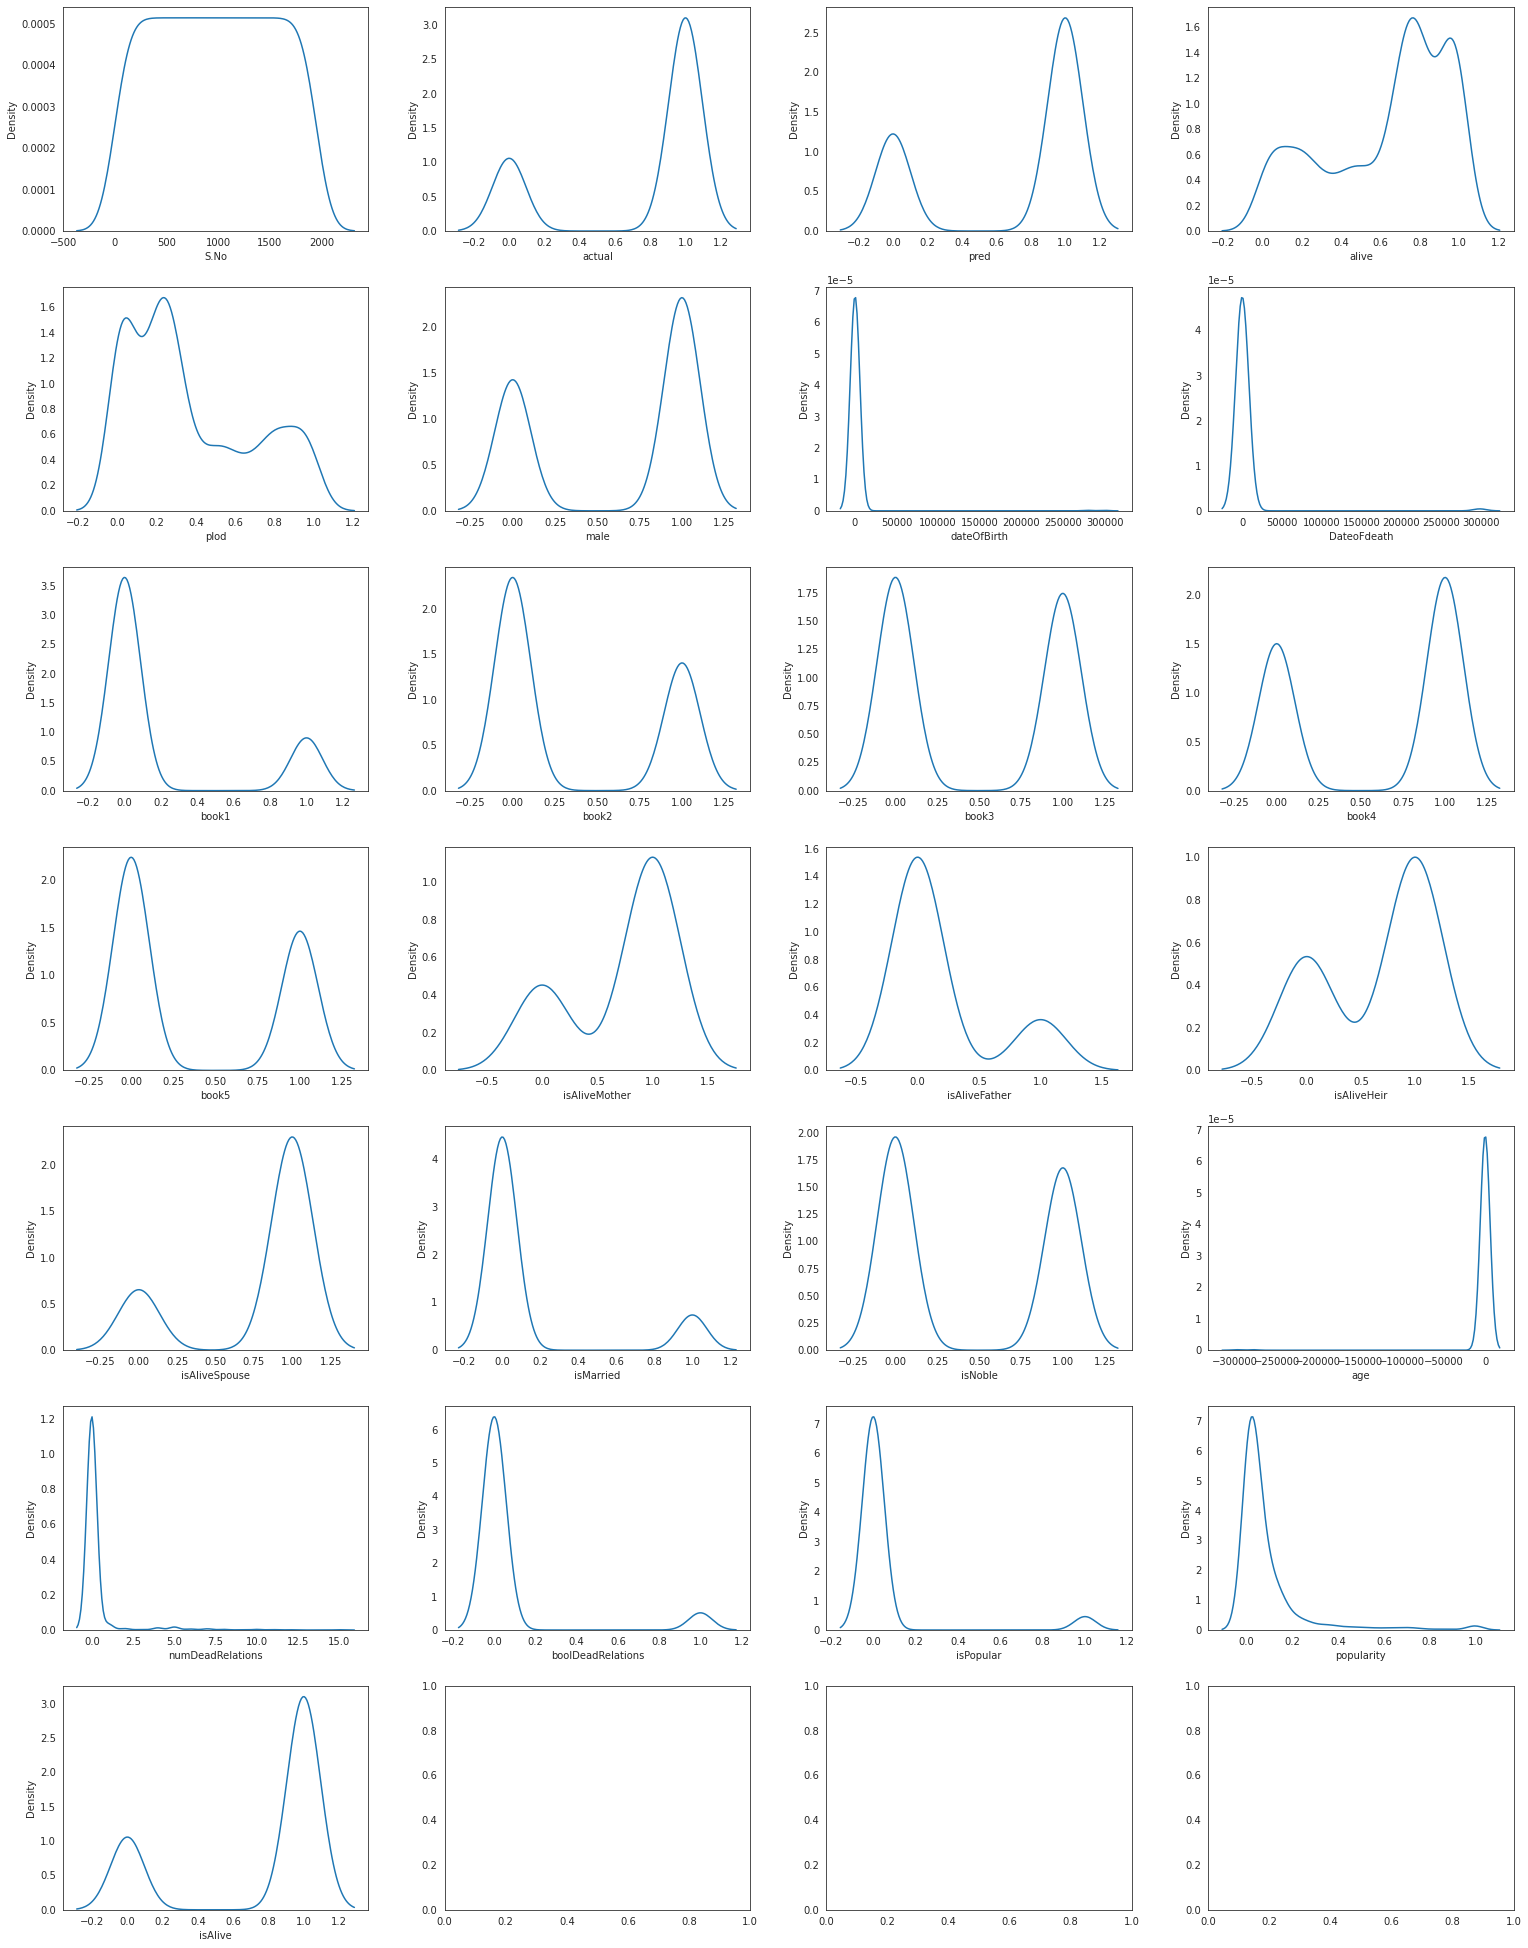

In [22]:
subplot_grid(
  df_character_predictions.select_dtypes(include=np.number),
  lambda index, df_column, ax, column: sns.kdeplot(df_column, ax=ax)
)

Histplot, previously named in Seaborn as displot, helps us see the distribution and bars, it is visually clearer to a certain degree

In [23]:
def plot_distribution(dataframe: pd.DataFrame) -> None:
  def plot_single_distribution(
    index: int,
    df_col: pd.DataFrame,
    ax,
    column: str
  ):
    discrete = False if len(df_col.unique()) > 2 else True
    graphic = sns.histplot(
      df_col,
      ax=ax,
      discrete=discrete,
    )
    graphic.set_title(column.title())
    plt.title(column.title())

  subplot_grid(dataframe, plot_single_distribution)

In [24]:
# Careful!! It takes a lot of time to compute
hist_distribution_cols_ignore = [
  'dateOfBirth',
  'DateoFdeath',
  'age'
]
plot_distribution(
  df_character_predictions[
    [ col for col in df_character_predictions.columns if col not in hist_distribution_cols_ignore ]
  ].select_dtypes(include=np.number)
)

4.55% - Column S.No plotted
9.09% - Column actual plotted
13.64% - Column pred plotted
18.18% - Column alive plotted
22.73% - Column plod plotted
27.27% - Column male plotted
31.82% - Column book1 plotted
36.36% - Column book2 plotted
40.91% - Column book3 plotted
45.45% - Column book4 plotted
50.0% - Column book5 plotted
54.55% - Column isAliveMother plotted
59.09% - Column isAliveFather plotted
63.64% - Column isAliveHeir plotted
68.18% - Column isAliveSpouse plotted
72.73% - Column isMarried plotted
77.27% - Column isNoble plotted
81.82% - Column numDeadRelations plotted
86.36% - Column boolDeadRelations plotted
90.91% - Column isPopular plotted
95.45% - Column popularity plotted
100.0% - Column isAlive plotted


Seeing the distribution with a boxplot, while maybe not as clear as the KDE, it helps us identify the outliers, and the amount

4.0% - Column S.No plotted
8.0% - Column actual plotted
12.0% - Column pred plotted
16.0% - Column alive plotted
20.0% - Column plod plotted
24.0% - Column male plotted
28.0% - Column dateOfBirth plotted
32.0% - Column DateoFdeath plotted
36.0% - Column book1 plotted
40.0% - Column book2 plotted
44.0% - Column book3 plotted
48.0% - Column book4 plotted
52.0% - Column book5 plotted
56.0% - Column isAliveMother plotted
60.0% - Column isAliveFather plotted
64.0% - Column isAliveHeir plotted
68.0% - Column isAliveSpouse plotted
72.0% - Column isMarried plotted
76.0% - Column isNoble plotted
80.0% - Column age plotted
84.0% - Column numDeadRelations plotted
88.0% - Column boolDeadRelations plotted
92.0% - Column isPopular plotted
96.0% - Column popularity plotted
100.0% - Column isAlive plotted


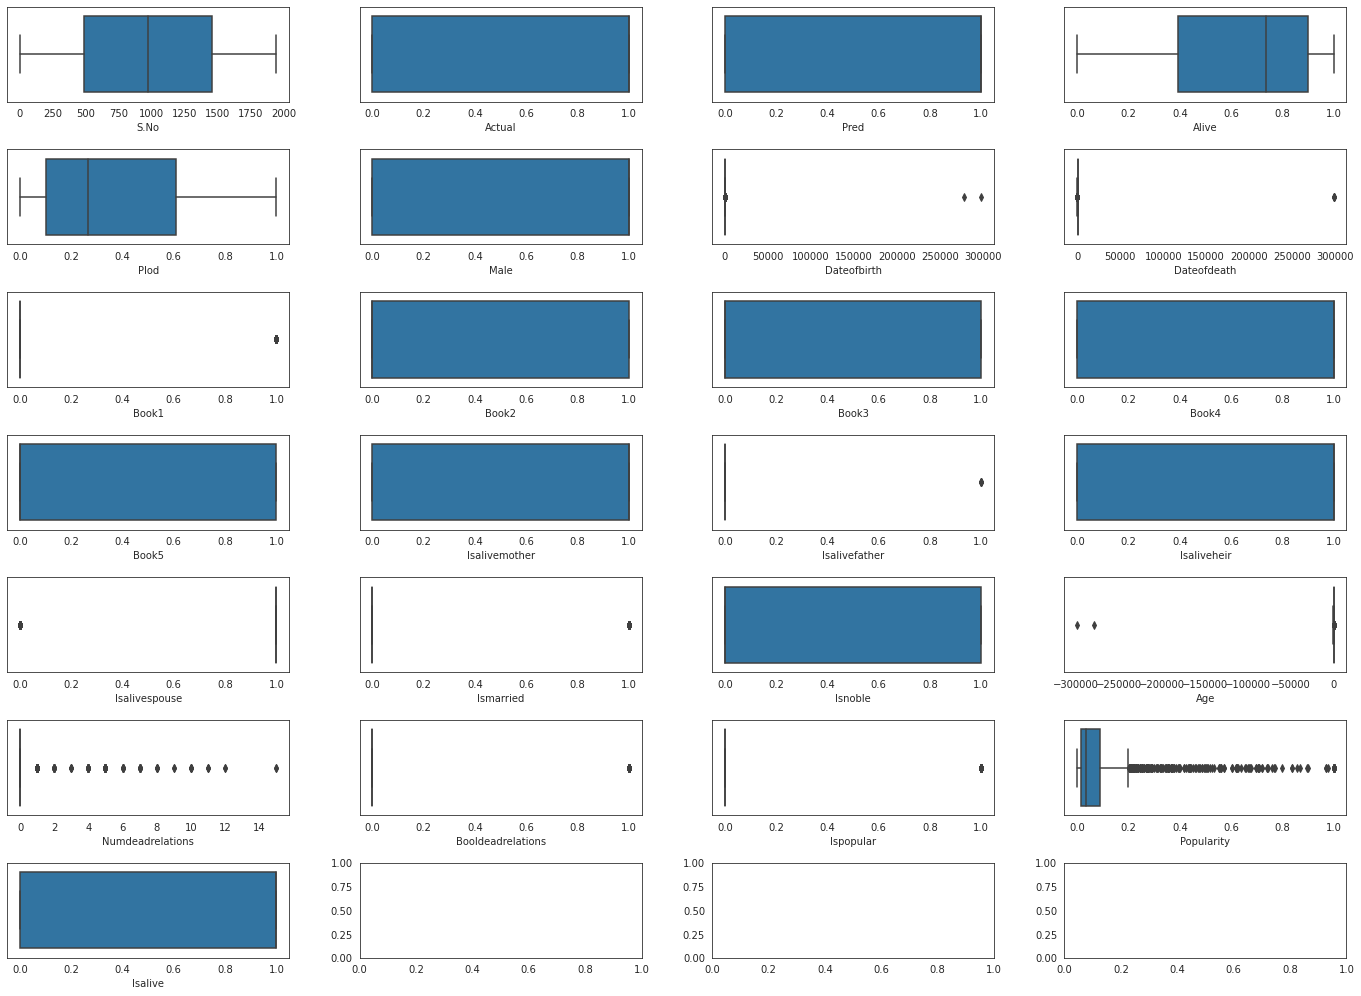

In [25]:
def subplot_distribution_boxplot(index, df_column, ax, column):
  g = sns.boxplot(
      data=df_character_predictions,
      x=column,
      ax=ax,
    )
  g.set_xlabel(column.title())

subplot_grid(
  df_character_predictions.select_dtypes(include=np.number),
  subplot_distribution_boxplot,
  distribution_plot_height=2.5,
  distribution_plot_width=6,
  # wspace=.5,
  hspace=.5,
)

### Correlation

Correlation statistically represents how dependant is one value of the other, or how much information is similar between pairs, if a pair is too close to 1 or -1, they're representing the exact information

In [26]:
def plot_correlation(
  dataframe: pd.DataFrame,
  plot: bool = True
) -> pd.Series:
  correlation = dataframe.corr()

  if plot:
    sns.set(rc={'figure.figsize':(20,15)})
    sns.heatmap(correlation, cmap="YlGnBu", annot=True)

  return correlation

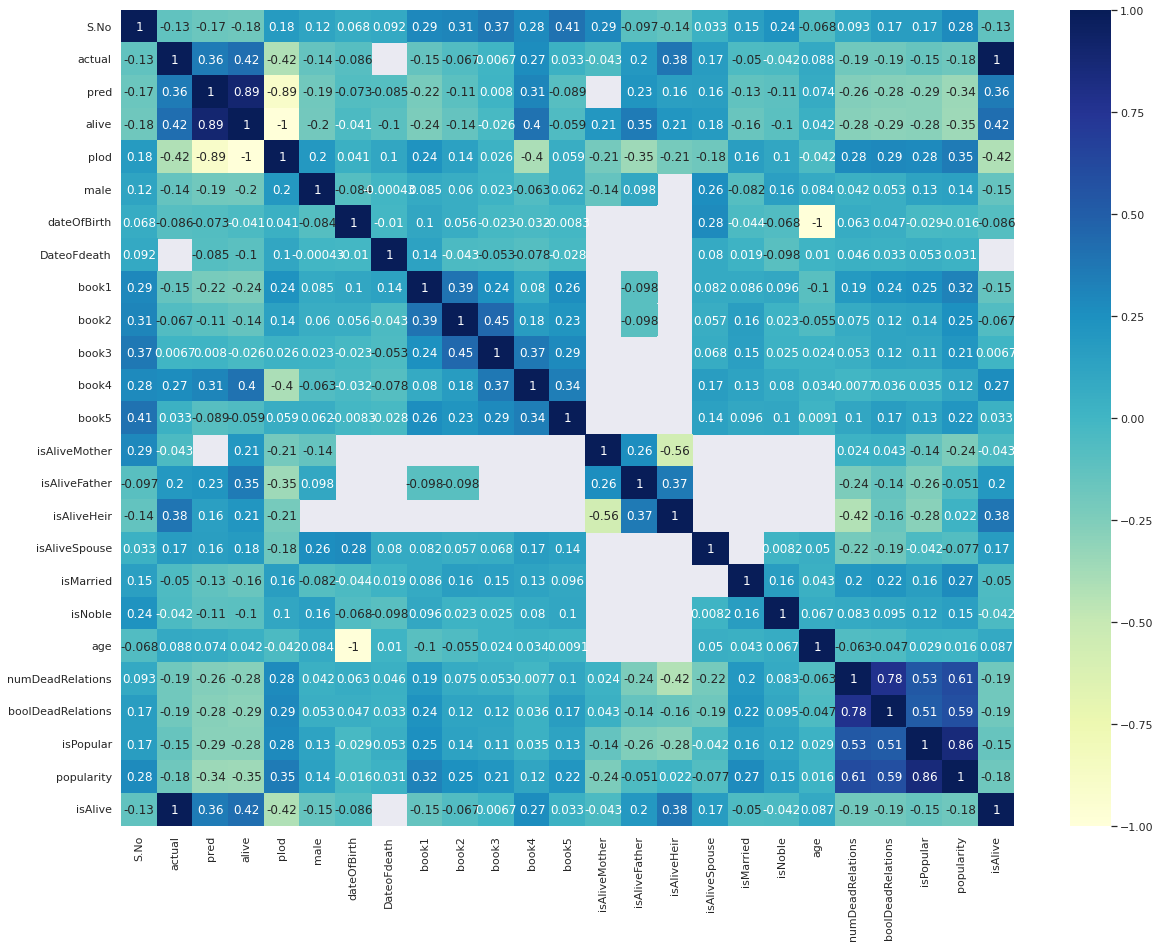

In [27]:
correlation = plot_correlation(df_character_predictions)

In [28]:
pd.DataFrame(correlation[TARGET_VARIABLE].abs().sort_values(
  ascending=False
))

isAlive
isAlive            1.000000
actual             0.997291
alive              0.417318
plod               0.417318
isAliveHeir        0.384900
pred               0.356483
book4              0.268975
isAliveFather      0.195992
boolDeadRelations  0.193736
numDeadRelations   0.192444
popularity         0.183223
isAliveSpouse      0.174275
isPopular          0.153860
book1              0.147401
male               0.146982
S.No               0.128712
age                0.087264
dateOfBirth        0.085863
book2              0.067200
isMarried          0.050037
isAliveMother      0.043033
isNoble            0.042211
book5              0.032846
book3              0.006693
DateoFdeath             NaN

### Dependant Variable insights

Let's see some general details about the dependant variable

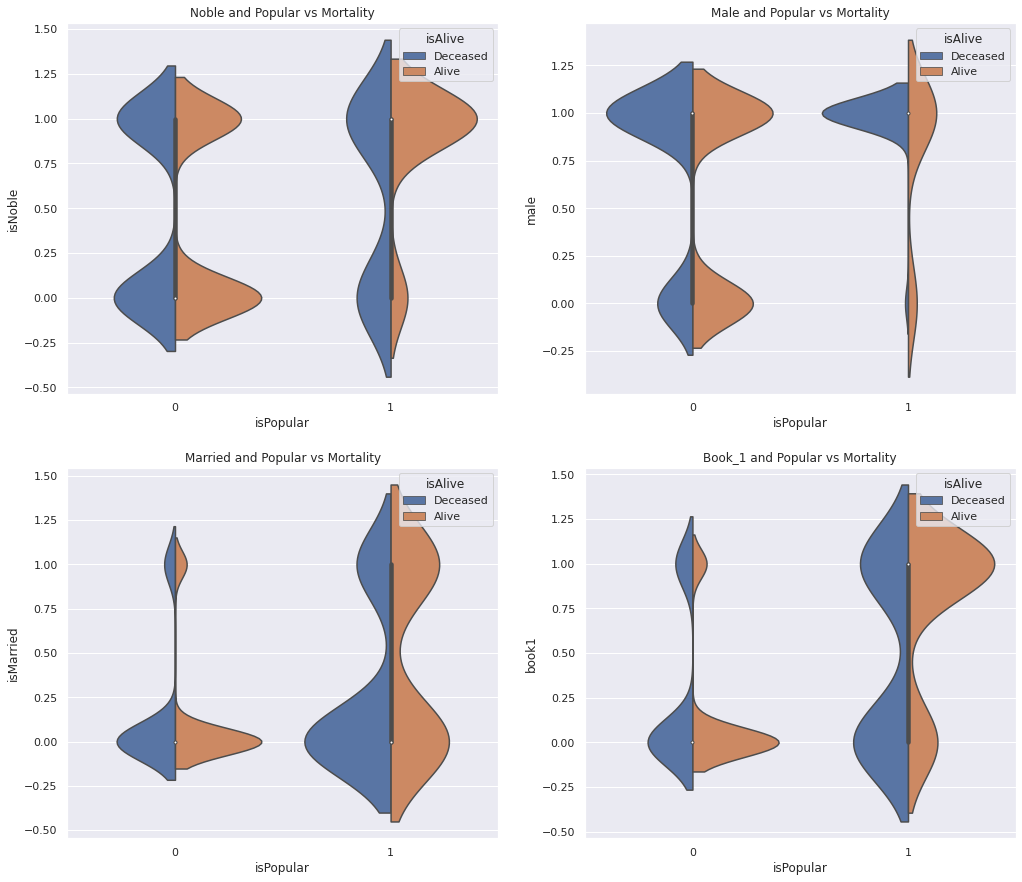

In [29]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  import warnings
  warnings.filterwarnings('ignore')

  fig, axes = plt.subplots(2,2,figsize=(17,15))

  df_violinplot = df_character_predictions.copy()
  survival_dict = {
    0: 'Deceased',
    1: 'Alive',
  }
  df_violinplot[TARGET_VARIABLE] = df_violinplot[TARGET_VARIABLE].apply(lambda x: survival_dict[x])

  sns.violinplot("isPopular", "isNoble", hue=TARGET_VARIABLE, data=df_violinplot,split=True, ax=axes[0, 0])
  axes[0, 0].set_title('Noble and Popular vs Mortality')

  sns.violinplot("isPopular", "male", hue=TARGET_VARIABLE, data=df_violinplot ,split=True, ax=axes[0, 1])
  axes[0, 1].set_title('Male and Popular vs Mortality')

  sns.violinplot("isPopular", "isMarried", hue=TARGET_VARIABLE, data=df_violinplot,split=True, ax=axes[1, 0])
  axes[1, 0].set_title('Married and Popular vs Mortality')

  sns.violinplot("isPopular", "book1", hue=TARGET_VARIABLE, data=df_violinplot ,split=True, ax=axes[1, 1])
  axes[1, 1].set_title('Book_1 and Popular vs Mortality')

  plt.show()

Per culture

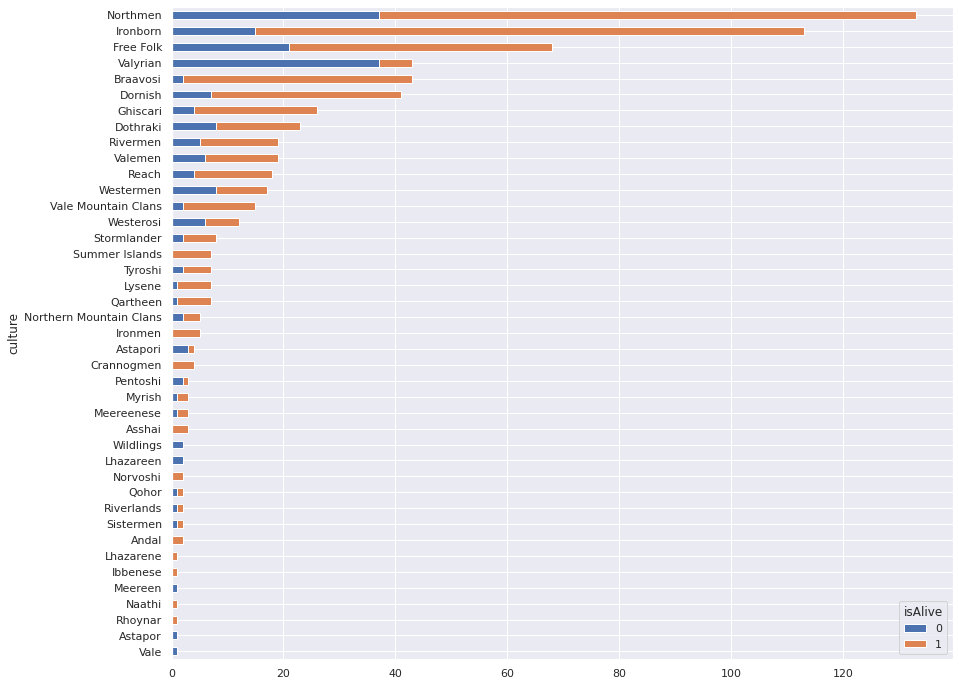

In [30]:
df_culture = df_character_predictions.copy()

def get_cult(value):
  value = value.lower()
  v = [k for (k, v) in CULTURE_DICT.items() if value in v]
  return v[0] if len(v) > 0 else value.title()

df_culture.loc[:, "culture"] = [get_cult(x) for x in df_culture.culture.fillna("")]
data = df_culture.groupby(["culture", "isAlive"]).count()["name"].unstack().copy(deep = True)
data.loc[:, "total"]= data.sum(axis = 1)
p = data[data.index != ""].sort_values("total")[[0, 1]].plot.barh(stacked = True, rot = 0, figsize = (14, 12),)

Some correlation plots

<Figure size 1440x720 with 0 Axes>

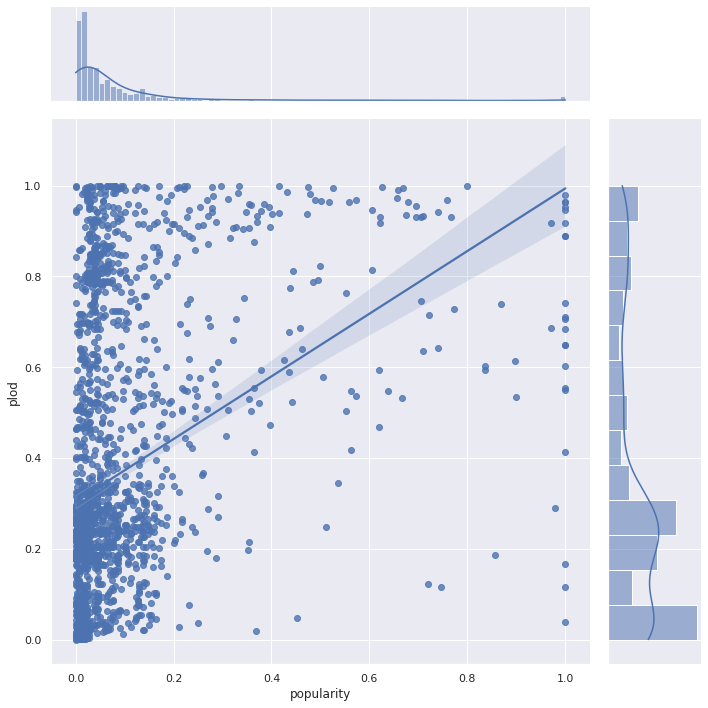

In [31]:
plt.figure(figsize=(20, 10))
_ = sns.jointplot(
  data=df_violinplot,
  x='popularity',
  y='plod',
  # hue=TARGET_VARIABLE,
  kind='reg',
  height=10,
)

Popularity has an inverse correlation with the Percentage Likelyhood of Death, which is a metric, not a real value, but it helps as understand that, sort of, the most popular a person is, the less change of dying they may have.

The age and the popularity, if popularity has some sort of correlation with the dependant, means that age having correlation with popularity may help predict the dependant variable

<Figure size 1440x720 with 0 Axes>

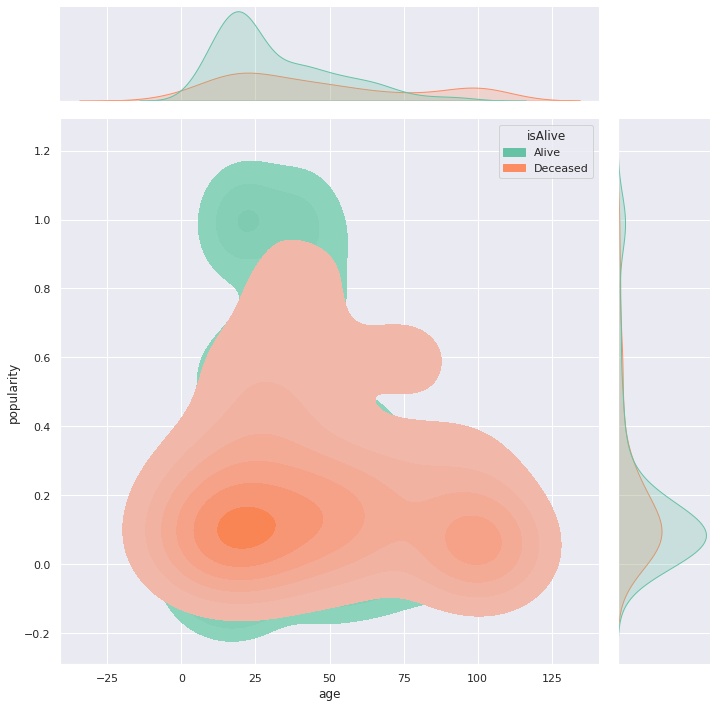

In [32]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  plt.figure(figsize=(20, 10))
  _ = sns.jointplot(
    data=df_violinplot[ df_violinplot['age'] >= 0.0 ],
    x='age',
    y='popularity',
    height=10,
    kind='kde',
    hue=TARGET_VARIABLE,
    palette=sns.color_palette('Set2', 2),
    fill=True # just wanted to add this filler
  )

It may be a little confusing, but there is some sort of correlation, but we can get some conclusions suchs:

- The older the people are, the less they survive
- Surprisingly, popular people die "sooner" (younger) than non-popular folks
- Amoung the younger ones, the most popular have a higher chance of survival
- The most deaths happend to non-popular people at a young age, but, on the contrary, they're also the oldest ones to remain alive

### Pairplot

A correlation plot, but with plotting visuals

In [33]:
numeric_columns = df_character_predictions.select_dtypes(include=np.number).columns
# _ = sns.pairplot(df_character_predictions[ numeric_columns[:5] ])
# _ = sns.pairplot(df_character_predictions[ ['isMarried', 'isPopular', 'age'] ])

### What's the house with the most "survivors"?

In [34]:
len(df_character_predictions.house.unique())
df_character_predictions[ df_character_predictions['house'].isna() == False ].head(5)['house']

1         House Frey
2        House Swyft
3        House Arryn
4     House Santagar
6    House Targaryen
Name: house, dtype: object

First, we create the dataset, we're hardcoding it to be used only when the target variable is `actual` or `isAlive` as to avoid further problems down the line, but it could be changed to analyze other features.

In [35]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  df_group_by_house = df_character_predictions.groupby('house')
  df_group_by_house_recount = df_group_by_house[TARGET_VARIABLE].value_counts()

Let's get a sneak peak

In [36]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  display(df_group_by_house_recount.sort_values(ascending=False))
  df_group_by_house_recount['House Frey']

house            isAlive
House Frey       1          83
Night's Watch    1          60
House Stark      1          50
Night's Watch    0          45
House Targaryen  0          41
                            ..
House Horpe      1           1
House Hollard    0           1
House Hogg       1           1
House Hoare      1           1
wildling         0           1
Name: isAlive, Length: 457, dtype: int64

We now join together those values

In [37]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  survival_recount_dict = df_group_by_house_recount.to_dict()

  survival_recount_grouped_dict = dict()

  survival_conversion_dict = {
    0: 'Deceased',
    1: 'Alive',
  }

  for indices, amount in survival_recount_dict.items():
    house_name, status = indices
    if house_name not in survival_recount_grouped_dict:
      survival_recount_grouped_dict[house_name] = {
        'House': house_name,
        survival_conversion_dict[1]: 0,
        survival_conversion_dict[0]: 0
      }
    survival_recount_grouped_dict[house_name][survival_conversion_dict[status]] = amount

  df_survival_recount = pd.DataFrame(
    survival_recount_grouped_dict.values(),
  )
  display(df_survival_recount)

House  Alive  Deceased
0              Alchemists' Guild      6         1
1                     Antler Men      1         0
2                   Band of Nine      0         1
3                     Black Ears      2         0
4                         Blacks      0         4
..                           ...    ...       ...
342                    Unsullied      1         1
343                    Windblown      1         0
344                 Wise Masters      1         0
345  brotherhood without banners      1         0
346                     wildling      0         1

[347 rows x 3 columns]

And create a total members column that will be the vector difference between the alive and the deceased

In [38]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  df_survival_recount['Total Members'] = df_survival_recount['Alive'] + df_survival_recount['Deceased']
  # df_survival_recount['Lost Members'] = abs(df_survival_recount['Alive'] - df_survival_recount['Deceased'])

The top five house with the most amount of members

In [39]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  display(df_survival_recount[
    ['House', 'Total Members']
  ].sort_values('Total Members', ascending=False).head(5))

House  Total Members
327    Night's Watch            105
116       House Frey             97
252      House Stark             72
266  House Targaryen             62
165  House Lannister             49

The houses that suffered the most losses

In [40]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  display(df_survival_recount[
    ['House', 'Deceased', 'Total Members']
  ].sort_values(
    'Deceased',
    ascending=False
  ).head(5))

House  Deceased  Total Members
327    Night's Watch        45            105
266  House Targaryen        41             62
252      House Stark        22             72
165  House Lannister        18             49
116       House Frey        14             97

The houses that remain with the most survivors

In [41]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  display(df_survival_recount[
    ['House', 'Alive', 'Total Members']
  ].sort_values(
    ['Alive', 'Total Members'],
    ascending=False
  ).head(5))

House  Alive  Total Members
116       House Frey     83             97
327    Night's Watch     60            105
252      House Stark     50             72
278     House Tyrell     34             36
165  House Lannister     31             49

And now let's see how, the houses with the least members survived

In [42]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  display(df_survival_recount[
    ['House', 'Alive', 'Deceased', 'Total Members']
  ].sort_values(
    'Total Members',
    ascending=True
  ).head(20))

House  Alive  Deceased  Total Members
173                  House Longthorpe      1         0              1
167     House Lannister of Lannisport      1         0              1
168                        House Leek      1         0              1
170                     House Leygood      1         0              1
171                      House Liddle      1         0              1
345       brotherhood without banners      1         0              1
174                  House Longwaters      1         0              1
178                   House Lychester      1         0              1
181                     House Mallery      0         1              1
187                      House Massey      1         0              1
189                      House Merlyn      1         0              1
166  House Lannister of Casterly Rock      1         0              1
191                     House Mertyns      1         0              1
193                       House Moore      0         1              1
195                    House Moreland      1         0              1
198                        House Mudd      1         0              1
200                        House Myre      1         0              1
204                    House Norridge      1         0              1
205             House Nymeros Martell      1         0              1
211                   House Peckledon      1         0              1

In [43]:
# df_group_by_house_recount.head(5).where( df_group_by_house_recount['actual'] == 0 )
# df_group_by_house[ df_group_by_house['actual'] == 0 ]

Then we sort it

In [44]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  # df_group_by_house[TARGET_VARIABLE].sum().sort_values(ascending=False)
  df_group_by_house_recount.sort_values(ascending=False)

### What's the culture with the most "survivors"?

In [45]:
df_culture = df_character_predictions.copy(deep=True)

In [46]:
# Simplify the cultures

def get_cult(value):
  value = value.lower()
  v = [k for (k, v) in CULTURE_DICT.items() if value in v]
  return v[0] if len(v) > 0 else value.title()

df_culture.loc[:, "culture"] = [get_cult(x) for x in df_culture.culture.fillna('')]
df_culture = df_culture.replace('', np.nan)

First, we create the dataset

In [47]:
df_group_by_culture = df_culture.groupby('culture')
df_group_by_culture_recount = df_group_by_culture[TARGET_VARIABLE].value_counts()

Let's get a sneak peak

In [48]:
display(df_group_by_culture_recount.sort_values(ascending=False))

culture     isAlive
Ironborn    1          98
Northmen    1          96
Free Folk   1          47
Braavosi    1          41
Valyrian    0          37
                       ..
Riverlands  1           1
            0           1
Rhoynar     1           1
Qartheen    0           1
Myrish      0           1
Name: isAlive, Length: 67, dtype: int64

We now join together those values

In [49]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  survival_recount_dict = df_group_by_culture_recount.to_dict()

  survival_recount_grouped_dict = dict()

  survival_conversion_dict = {
    0: 'Deceased',
    1: 'Alive',
  }

  for indices, amount in survival_recount_dict.items():
    culture_name, status = indices
    if culture_name not in survival_recount_grouped_dict:
      survival_recount_grouped_dict[culture_name] = {
        'Culture': culture_name,
        survival_conversion_dict[1]: 0,
        survival_conversion_dict[0]: 0
      }
    survival_recount_grouped_dict[culture_name][survival_conversion_dict[status]] = amount

  df_survival_recount = pd.DataFrame(
    survival_recount_grouped_dict.values(),
  )

And create a total members column that will be the vector difference between the alive and the deceased

In [50]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  df_survival_recount['Total Members'] = df_survival_recount['Alive'] + df_survival_recount['Deceased']
  # df_survival_recount['Lost Members'] = abs(df_survival_recount['Alive'] - df_survival_recount['Deceased'])

The top five house with the most amount of members

In [51]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  display(df_survival_recount[
    ['Culture', 'Total Members']
  ].sort_values('Total Members', ascending=False).head(5))

Culture  Total Members
21   Northmen            133
11   Ironborn            113
8   Free Folk             68
37   Valyrian             43
4    Braavosi             43

The houses that suffered the most losses

In [52]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  display(df_survival_recount[
    ['Culture', 'Deceased', 'Total Members']
  ].sort_values(
    'Deceased',
    ascending=False
  ).head(5))

Culture  Deceased  Total Members
37   Valyrian        37             43
21   Northmen        37            133
8   Free Folk        21             68
11   Ironborn        15            113
38  Westermen         8             17

The houses that remain with the most survivors

In [53]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  display(df_survival_recount[
    ['Culture', 'Alive', 'Total Members']
  ].sort_values(
    ['Alive', 'Total Members'],
    ascending=False
  ).head(5))

Culture  Alive  Total Members
11   Ironborn     98            113
21   Northmen     96            133
8   Free Folk     47             68
4    Braavosi     41             43
6     Dornish     34             41

And now let's see how, the houses with the least members survived

In [54]:
if TARGET_VARIABLE in ['actual', 'isAlive']:
  display(df_survival_recount[
    ['Culture', 'Alive', 'Deceased', 'Total Members']
  ].sort_values(
    'Total Members',
    ascending=True
  ).head(20))

Culture  Alive  Deceased  Total Members
34        Vale      0         1              1
2      Astapor      0         1              1
27     Rhoynar      1         0              1
19      Naathi      1         0              1
16     Meereen      0         1              1
10    Ibbenese      1         0              1
14   Lhazarene      1         0              1
0        Andal      2         0              2
30   Sistermen      1         1              2
28  Riverlands      1         1              2
25       Qohor      1         1              2
22    Norvoshi      2         0              2
13   Lhazareen      0         2              2
40   Wildlings      0         2              2
1       Asshai      3         0              3
17  Meereenese      2         1              3
18      Myrish      2         1              3
23    Pentoshi      1         2              3
5   Crannogmen      4         0              4
3     Astapori      1         3              4

## The magic begins, should we plot it?

It's an important section, because depending on this, you'll see some distribution and correlation plots, or not. Things will still happen, but not plotting will make the notebook execute faster.

In [55]:
PLOT_PROGRESS = True #@param {type: 'boolean'}
PLOT_PROGRESS_ON_DEVELOPMENT_ENVIRONMENT = False #@param {type: 'boolean'}
if DEVELOPMENT_ENVIRONMENT:
  # PLOT_PROGRESS = False
  PLOT_PROGRESS = PLOT_PROGRESS_ON_DEVELOPMENT_ENVIRONMENT

## Data Cleansening

A crucial part of any Data Science project, there's no one rule to how should the data be cleaned, nor when it is considered clean and quality data, it's a sum of every little detail.

### Backup

Before anything else, I'll make a backup of the working dataframe

In [56]:
df = df_character_predictions.copy()

### Missing Values

All those values that should be there, but aren't, incomplete rows, incomplete columns

In [57]:
if PLOT_PROGRESS:
  _ = df.isna().sum() * 100 / len(df)
  display(_)

S.No                  0.000000
actual                0.000000
pred                  0.000000
alive                 0.000000
plod                  0.000000
name                  0.000000
title                51.798561
male                  0.000000
culture              65.210689
dateOfBirth          77.749229
DateoFdeath          77.183967
mother               98.920863
father               98.663926
heir                 98.818088
house                21.942446
spouse               85.817061
book1                 0.000000
book2                 0.000000
book3                 0.000000
book4                 0.000000
book5                 0.000000
isAliveMother        98.920863
isAliveFather        98.663926
isAliveHeir          98.818088
isAliveSpouse        85.817061
isMarried             0.000000
isNoble               0.000000
age                  77.749229
numDeadRelations      0.000000
boolDeadRelations     0.000000
isPopular             0.000000
popularity            0.000000
isAlive 

Total percentage of missing values

In [58]:
if PLOT_PROGRESS:
  _ = df.isna().sum().sum() * 100 / (len(df) * len(df.columns))
  display(_)

34.426484786197015

So we drop those columns with too many missing values

In [59]:
df = df.drop(columns=[
  # too many missing values
  # 'mother',
  # 'father',
  # 'heir',
  # 'spouse',

  # 'isAliveMother',
  # 'isAliveFather',
  # 'isAliveHeir',
])

#### House

It is something close to their family, or royalty, it seems

Let's see first how many do NOT have a house

In [60]:
df['house'].isna().sum()

427

We could drop those rows that do not have a house.

In [61]:
# df = df.dropna(subset=['house',])

Or we could assign them a non-existent house to group them, thus, not losing valuable information

In [62]:
df['house'] = df['house'].fillna('Without a house')

#### Title

Their nickname, role, or surname, we'll do exactly as we did with the house, just fill it with Non existant title

In [63]:
df['title'].isna().sum()

1008

In [64]:
df['title'] = df['title'].fillna('None')

In [65]:
df['title'].isna().sum()

0

### Abnormal values

Any sort of value that should not be there or that does not fit, clearly, with the rest of the values

Before

In [66]:
len(df)

1946

No age can be negative, it does not make sense, in the real world at least

In [67]:
df = pd.concat([
  df[ df['age'] >= 0.0 ],
  df[ df['age'].isna() == True ],
])

In [68]:
len(df)

1944

No date of birth should be below zero, even if it, cannonically, makes sense

In [69]:
df = pd.concat([
  df[ df['dateOfBirth'] >= 0.0 ],
  df[ df['dateOfBirth'].isna() == True ],
])

Nor should it be too high

In [70]:
if PLOT_PROGRESS:
  _ = df_character_predictions[ df_character_predictions['dateOfBirth'] >= 150_000 ]
  display(_)

S.No  actual  pred  alive   plod    name title  male culture  \
1684  1685       0     0  0.253  0.747  Doreah   NaN     0  Lysene   
1868  1869       0     0  0.360  0.640  Rhaego   NaN     0     NaN   

      dateOfBirth  ...  isAliveHeir isAliveSpouse isMarried isNoble       age  \
1684     278279.0  ...          NaN           NaN         0       0 -277980.0   
1868     298299.0  ...          NaN           NaN         0       0 -298001.0   

     numDeadRelations  boolDeadRelations  isPopular  popularity  isAlive  
1684                0                  0          0    0.110368        0  
1868                6                  1          0    0.167224        0  

[2 rows x 33 columns]

In [71]:
df = pd.concat([
  # df[ df['dateOfBirth'] < 298299 ],
  df[ df['dateOfBirth'] < 150_000 ],
  df[ df['dateOfBirth'].isna() == True ],
])

In [72]:
len(df)

1942

And we check the values to see if there's still any abnormal values, or we've cleaned them

In [73]:
if PLOT_PROGRESS:
  _ = df.describe().transpose()
  display(_)

count         mean           std   min         25%  \
S.No               1942.0   972.688465    561.190164   1.0  487.250000   
actual             1942.0     0.747168      0.434747   0.0    0.000000   
pred               1942.0     0.688465      0.463240   0.0    0.000000   
alive              1942.0     0.635430      0.312172   0.0    0.394000   
plod               1942.0     0.364570      0.312172   0.0    0.100250   
male               1942.0     0.620494      0.485389   0.0    0.000000   
dateOfBirth         429.0   248.191142     56.524503  26.0  240.000000   
DateoFdeath         440.0  2975.534091  28319.128472   0.0  282.000000   
book1              1942.0     0.196704      0.397609   0.0    0.000000   
book2              1942.0     0.373841      0.483947   0.0    0.000000   
book3              1942.0     0.480433      0.499746   0.0    0.000000   
book4              1942.0     0.592173      0.491557   0.0    0.000000   
book5              1942.0     0.394954      0.488967   0.0    0.000000   
isAliveMother        21.0     0.714286      0.462910   0.0    0.000000   
isAliveFather        26.0     0.192308      0.401918   0.0    0.000000   
isAliveHeir          23.0     0.652174      0.486985   0.0    0.000000   
isAliveSpouse       274.0     0.784672      0.411802   0.0    1.000000   
isMarried          1942.0     0.141092      0.348206   0.0    0.000000   
isNoble            1942.0     0.460865      0.498594   0.0    0.000000   
age                 429.0    36.738928     25.819320   0.0   18.000000   
numDeadRelations   1942.0     0.300206      1.375052   0.0    0.000000   
boolDeadRelations  1942.0     0.073120      0.260401   0.0    0.000000   
isPopular          1942.0     0.059217      0.236092   0.0    0.000000   
popularity         1942.0     0.089340      0.160610   0.0    0.013378   
isAlive            1942.0     0.747168      0.434747   0.0    0.000000   

                          50%          75%       max  
S.No               972.500000  1457.750000    1946.0  
actual               1.000000     1.000000       1.0  
pred                 1.000000     1.000000       1.0  
alive                0.736000     0.899750       1.0  
plod                 0.264000     0.606000       1.0  
male                 1.000000     1.000000       1.0  
dateOfBirth        268.000000   285.000000     300.0  
DateoFdeath        299.000000   299.000000  298299.0  
book1                0.000000     0.000000       1.0  
book2                0.000000     1.000000       1.0  
book3                0.000000     1.000000       1.0  
book4                1.000000     1.000000       1.0  
book5                0.000000     1.000000       1.0  
isAliveMother        1.000000     1.000000       1.0  
isAliveFather        0.000000     0.000000       1.0  
isAliveHeir          1.000000     1.000000       1.0  
isAliveSpouse        1.000000     1.000000       1.0  
isMarried            0.000000     0.000000       1.0  
isNoble              0.000000     1.000000       1.0  
age                 27.000000    50.000000     100.0  
numDeadRelations     0.000000     0.000000      15.0  
boolDeadRelations    0.000000     0.000000       1.0  
isPopular            0.000000     0.000000       1.0  
popularity           0.033445     0.086957       1.0  
isAlive              1.000000     1.000000       1.0

Afer removing the abnormal values, another cool thing we could do is to checkout the real outliers, for that purpose, the boxplot is one of the best plots

In [74]:
if PLOT_PROGRESS:
  subplot_grid(
    df.select_dtypes(include=np.number),
    subplot_distribution_boxplot,
    distribution_plot_height=2.5,
    distribution_plot_width=6,
    # wspace=.5,
    hspace=.5,
  )

4.0% - Column S.No plotted
8.0% - Column actual plotted
12.0% - Column pred plotted
16.0% - Column alive plotted
20.0% - Column plod plotted
24.0% - Column male plotted
28.0% - Column dateOfBirth plotted
32.0% - Column DateoFdeath plotted
36.0% - Column book1 plotted
40.0% - Column book2 plotted
44.0% - Column book3 plotted
48.0% - Column book4 plotted
52.0% - Column book5 plotted
56.0% - Column isAliveMother plotted
60.0% - Column isAliveFather plotted
64.0% - Column isAliveHeir plotted
68.0% - Column isAliveSpouse plotted
72.0% - Column isMarried plotted
76.0% - Column isNoble plotted
80.0% - Column age plotted
84.0% - Column numDeadRelations plotted
88.0% - Column boolDeadRelations plotted
92.0% - Column isPopular plotted
96.0% - Column popularity plotted
100.0% - Column isAlive plotted


### Correlated values

Too highly correlated values in-between are a problem, they add noise, if two values are almost the same, what's the point on having them? One has to go.

And there's no rule to decide which one has to, but it is certain that if two values contain exactly the same information, one of them is redundant.

These values are almost the same as the value we're trying to predict (`actual`), thus, having these, it'd be cheating, and confusing our model, plus, we need to use information that we can always use as input, if we're trying to predict a new character, we won't have it's Date of Death of if it is currently alive, because that's what we're trying to predict

In [75]:
df = df.drop(columns=[
  # Too correlated with the dependant variable, or we won't have this infromation
  # 'isAlive',
  'actual' if TARGET_VARIABLE == 'isAlive' else 'isAlive',
  'alive',
  'plod',
  'pred',
  'DateoFdeath',
  # too highly correlated in-between
  # 'popularity',
  # 'numDeadRelations',
  'S.No',
])

Let's see the correlation map now

In [76]:
if PLOT_PROGRESS:
  _ = plot_correlation(df)
  display(_)

male  dateOfBirth     book1     book2     book3  \
male               1.000000    -0.057163  0.090686  0.062554  0.023530   
dateOfBirth       -0.057163     1.000000  0.189685  0.468359  0.511635   
book1              0.090686     0.189685  1.000000  0.391422  0.244954   
book2              0.062554     0.468359  0.391422  1.000000  0.449919   
book3              0.023530     0.511635  0.244954  0.449919  1.000000   
book4             -0.063847     0.606437  0.081162  0.175602  0.372268   
book5              0.063127     0.294197  0.265334  0.224825  0.285701   
isAliveMother     -0.141421          NaN       NaN       NaN       NaN   
isAliveFather      0.097590          NaN -0.097590 -0.097590       NaN   
isAliveHeir             NaN          NaN       NaN       NaN       NaN   
isAliveSpouse      0.249062     0.206967  0.106398  0.056562  0.064193   
isMarried         -0.079301    -0.241279  0.082249  0.157658  0.152064   
isNoble            0.156803    -0.391498  0.096024  0.024366  0.024838   
age                0.079044    -0.541659 -0.005063 -0.212372 -0.257355   
numDeadRelations   0.047281    -0.023006  0.185940  0.071266  0.049413   
boolDeadRelations  0.060692     0.008536  0.234207  0.122297  0.117893   
isPopular          0.128773     0.020871  0.254541  0.139821  0.112441   
popularity         0.143119     0.011307  0.323319  0.247745  0.214162   
isAlive           -0.152193     0.586033 -0.141327 -0.064754  0.006859   

                      book4     book5  isAliveMother  isAliveFather  \
male              -0.063847  0.063127      -0.141421       0.097590   
dateOfBirth        0.606437  0.294197            NaN            NaN   
book1              0.081162  0.265334            NaN      -0.097590   
book2              0.175602  0.224825            NaN      -0.097590   
book3              0.372268  0.285701            NaN            NaN   
book4              1.000000  0.338250            NaN            NaN   
book5              0.338250  1.000000            NaN            NaN   
isAliveMother           NaN       NaN       1.000000       0.258199   
isAliveFather           NaN       NaN       0.258199       1.000000   
isAliveHeir             NaN       NaN      -0.564076       0.366900   
isAliveSpouse      0.166553  0.144688            NaN            NaN   
isMarried          0.128661  0.096172            NaN            NaN   
isNoble            0.079891  0.102527            NaN            NaN   
age               -0.290007 -0.047309            NaN            NaN   
numDeadRelations  -0.010852  0.104780       0.024340      -0.240100   
boolDeadRelations  0.035868  0.173651       0.043033      -0.143856   
isPopular          0.035071  0.127550      -0.141421      -0.257143   
popularity         0.116403  0.215949      -0.235275      -0.050977   
isAlive            0.269425  0.033742      -0.043033       0.195992   

                   isAliveHeir  isAliveSpouse  isMarried   isNoble       age  \
male                       NaN       0.249062  -0.079301  0.156803  0.079044   
dateOfBirth                NaN       0.206967  -0.241279 -0.391498 -0.541659   
book1                      NaN       0.106398   0.082249  0.096024 -0.005063   
book2                      NaN       0.056562   0.157658  0.024366 -0.212372   
book3                      NaN       0.064193   0.152064  0.024838 -0.257355   
book4                      NaN       0.166553   0.128661  0.079891 -0.290007   
book5                      NaN       0.144688   0.096172  0.102527 -0.047309   
isAliveMother        -0.564076            NaN        NaN       NaN       NaN   
isAliveFather         0.366900            NaN        NaN       NaN       NaN   
isAliveHeir           1.000000            NaN        NaN       NaN       NaN   
isAliveSpouse              NaN       1.000000        NaN  0.018272  0.062252   
isMarried                  NaN            NaN   1.000000  0.162391  0.187308   
isNoble                    NaN       0.018272   0.162391  1.000000  0.357075   
a

### The new data distribution

We've checked the max and min, but we could, and should, check the new distribution of the data

5.26% - Column male plotted
10.53% - Column dateOfBirth plotted
15.79% - Column book1 plotted
21.05% - Column book2 plotted
26.32% - Column book3 plotted
31.58% - Column book4 plotted
36.84% - Column book5 plotted
42.11% - Column isAliveMother plotted
47.37% - Column isAliveFather plotted
52.63% - Column isAliveHeir plotted
57.89% - Column isAliveSpouse plotted
63.16% - Column isMarried plotted
68.42% - Column isNoble plotted
73.68% - Column age plotted
78.95% - Column numDeadRelations plotted
84.21% - Column boolDeadRelations plotted
89.47% - Column isPopular plotted
94.74% - Column popularity plotted
100.0% - Column isAlive plotted


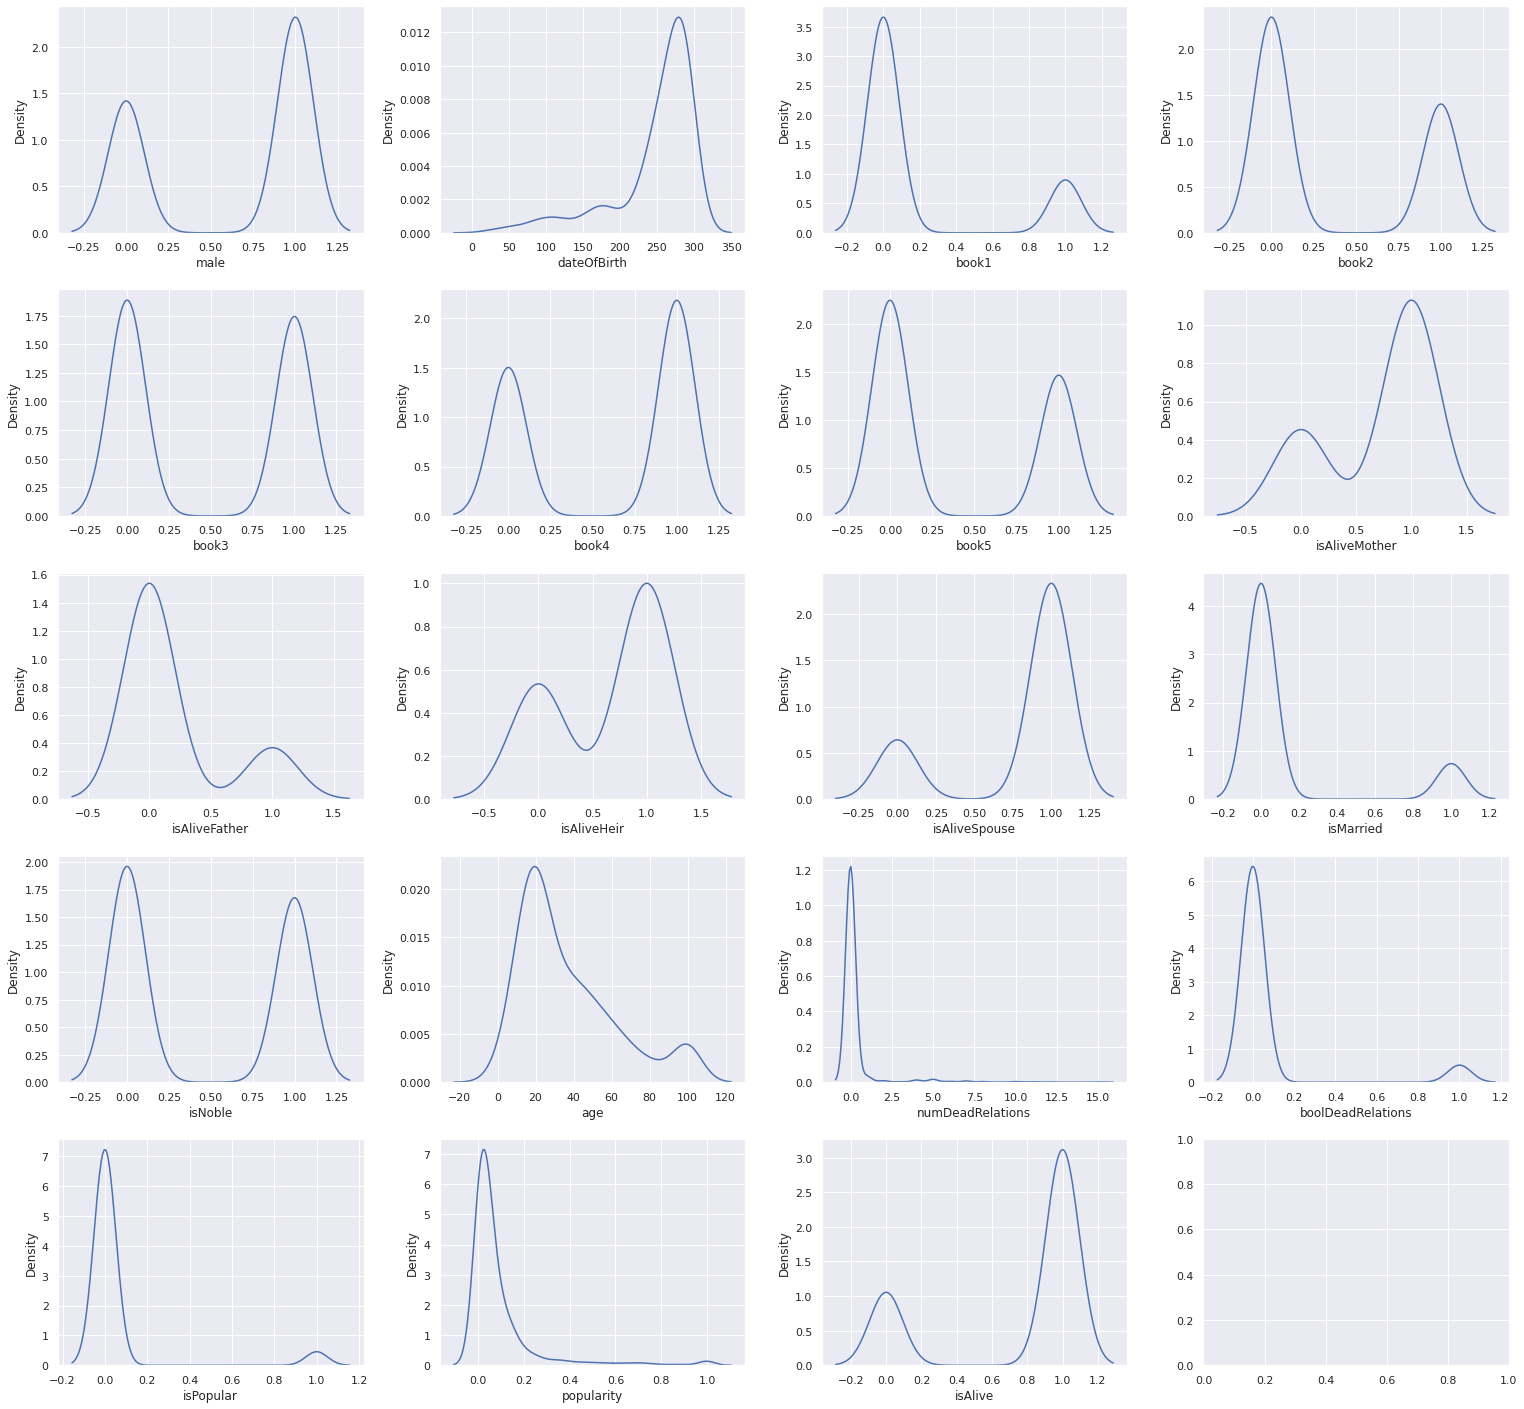

In [77]:
if PLOT_PROGRESS:
  subplot_grid(
    df.select_dtypes(include=np.number),
    lambda index, df_column, ax, column: sns.kdeplot(df_column, ax=ax)
  )

And we conclude that, after cleansening the data, there's some columns with huge imbalancement, such imbalancement do not help our model to perform properly, so they must disappear

In [78]:
df = df.drop(columns=[
  'isMarried',
  # 'boolDeadRelations',
  'numDeadRelations',
  'isPopular',
  'isAliveSpouse',
])

So that now we have a more evenly distributed dataset

6.67% - Column male plotted
13.33% - Column dateOfBirth plotted
20.0% - Column book1 plotted
26.67% - Column book2 plotted
33.33% - Column book3 plotted
40.0% - Column book4 plotted
46.67% - Column book5 plotted
53.33% - Column isAliveMother plotted
60.0% - Column isAliveFather plotted
66.67% - Column isAliveHeir plotted
73.33% - Column isNoble plotted
80.0% - Column age plotted
86.67% - Column boolDeadRelations plotted
93.33% - Column popularity plotted
100.0% - Column isAlive plotted


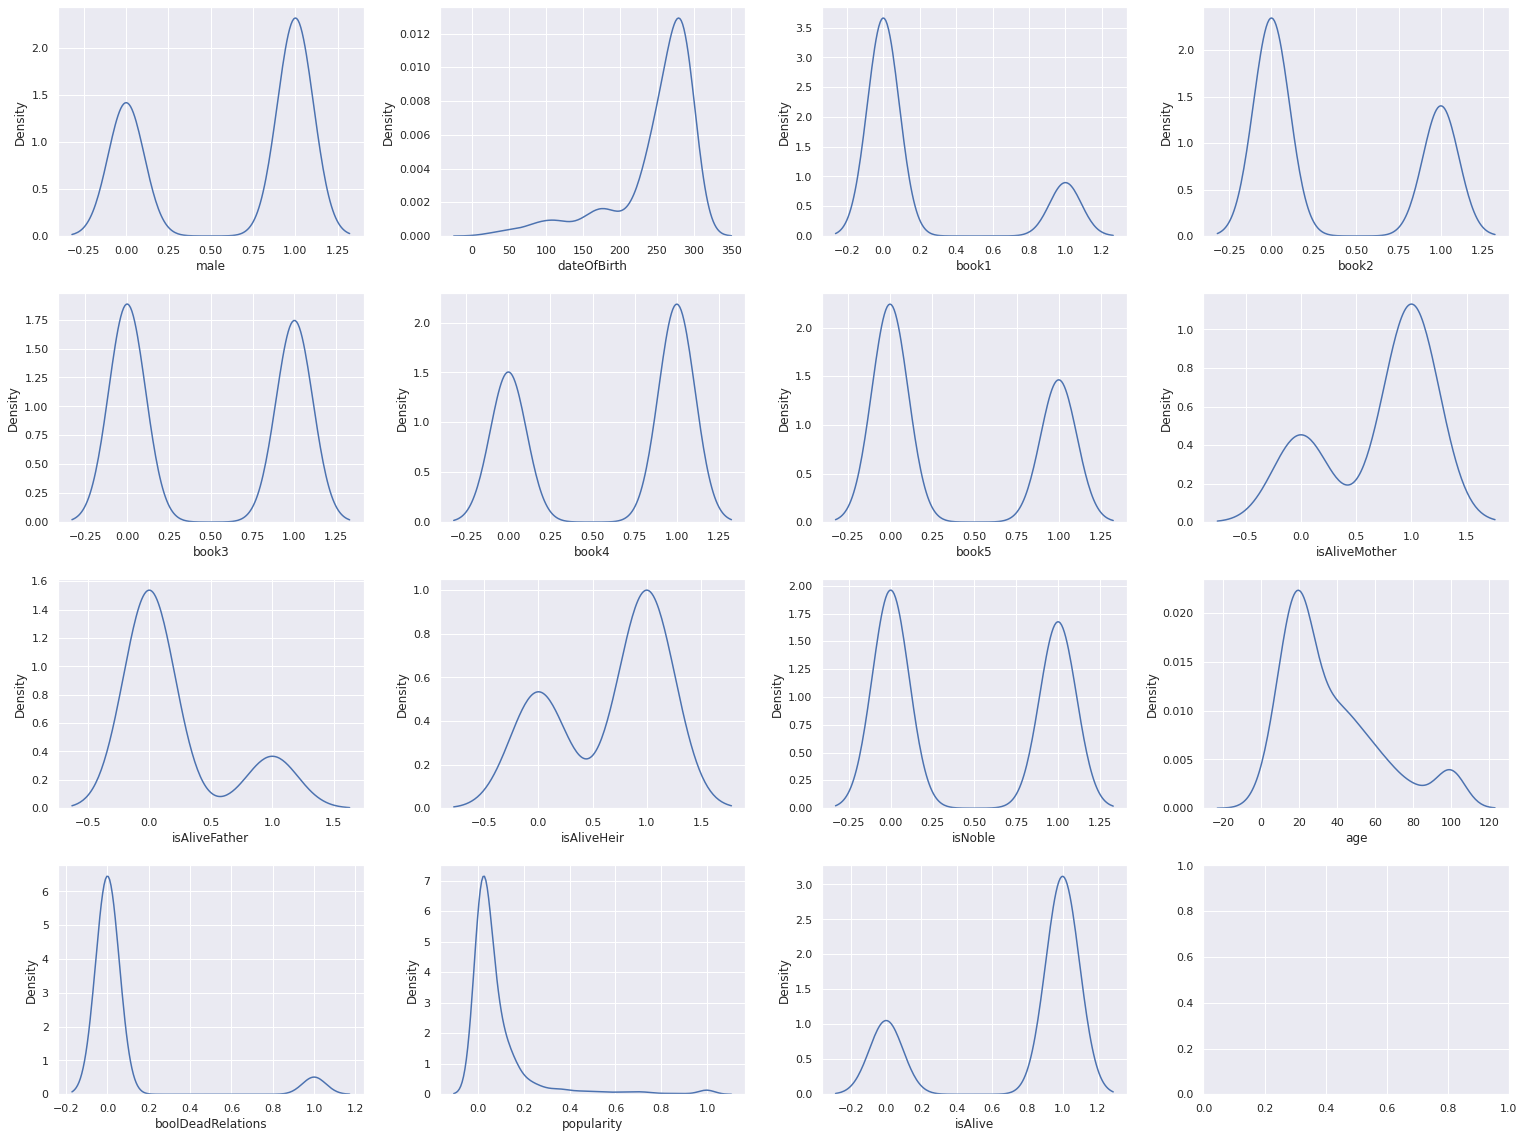

In [79]:
if PLOT_PROGRESS:
  subplot_grid(
    df.select_dtypes(include=np.number),
    lambda index, df_column, ax, column: sns.kdeplot(df_column, ax=ax)
  )

## Data Preprocessing

Preprocessing the data is to standarize the data is to make the data be all numeric, make the changes necessaries so that it is model-ready.

### Imports

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

### Standarization

All of the values should be values that our model is capable of understanding

#### Culture

We can map the culture to simplify it

In [81]:
len(df['culture'].unique())

65

In [82]:
# Simplify the cultures

def get_cult(value):
  value = value.lower()
  v = [k for (k, v) in CULTURE_DICT.items() if value in v]
  return v[0] if len(v) > 0 else value.title()

df.loc[:, "culture"] = [get_cult(x) for x in df.culture.fillna('')]
df = df.replace('', np.nan)

In [83]:
len(df['culture'].unique())

42

#### Factorizer

Converts a column to numbers

In [84]:
def col_to_dictionary(df, col_name):
  columns = [ col for col in df.columns ]
  if col_name not in columns: return False

  dataset = df.copy()
  dictionary = pd.factorize(dataset[col_name].fillna(''))
  dictionary = dict(zip(dictionary[1], dictionary[0]))

  def mapper(element):
    if (not element) or (element not in dictionary.keys()): return element

    return dictionary[element]
  dataset[col_name] = dataset[col_name].apply(mapper)

  return dataset

Map the dictionaries

In [85]:
cols_to_dictionary = [
  # 'name',
  'title',
  'culture',
  'house',
  # too many null values
  'mother',
  'father',
  'heir',
  'spouse',

  'isAliveMother',
  'isAliveFather',
  'isAliveHeir',
]

for col in cols_to_dictionary:
  if col not in df.columns:
    continue

  print(col, len(df[col].unique()))
  df = col_to_dictionary(df, col)
  print(col, len(df[col].unique()))

df[ cols_to_dictionary ].head(5)

title 262
title 53
culture 42
culture 11
house 348
house 105
mother 18
mother 2
father 21
father 2
heir 23
heir 2
spouse 254
spouse 62
isAliveMother 3
isAliveMother 2
isAliveFather 3
isAliveFather 2
isAliveHeir 3
isAliveHeir 2


title  culture  house  mother  father  heir  spouse  isAliveMother  \
1       0      0.0      0     NaN     NaN   NaN     0.0            NaN   
3       1      NaN      1     NaN     NaN   NaN     1.0            NaN   
4       2      2.0      2     NaN     NaN   NaN     2.0            NaN   
6       3      3.0      3     NaN     NaN   NaN     3.0            NaN   
22      4      NaN      4     NaN     NaN   NaN     NaN            NaN   

    isAliveFather  isAliveHeir  
1             NaN          NaN  
3             NaN          NaN  
4             NaN          NaN  
6             NaN          NaN  
22            NaN          NaN

In [86]:
df['culture'].value_counts()

1.0    270
3.0    157
6.0    133
2.0     41
5.0     23
0.0     22
4.0     18
7.0      7
9.0      2
8.0      1
Name: culture, dtype: int64

In [87]:
# df['culture'] = df['culture'].fillna(-1)

#### One hot encoding

Spreads all the values of a column into `n` columns

In [88]:
def col_to_one_hot_encoding(dataset, col_name):
  columns = [ col for col in dataset.columns ]
  if col_name not in columns: return False

  df = dataset.copy()
  df_encoded = pd.get_dummies(df[col_name], prefix=col_name, dummy_na=True)
  df = df.drop(columns=[col_name])
  df = df.join(df_encoded)

  return df

Map the one hot encoder

In [89]:
cols_to_one_hot_encoding = [
  # 'title',
  # 'culture',
  # 'house'
]

for col in cols_to_one_hot_encoding:
  df = col_to_one_hot_encoding(df, col)

_ = [ col in list(df.columns) for col in cols_to_one_hot_encoding ]

#### Text vectorizer

Vectorizes text so that it's easier for the model to understand the natural language

In [90]:
def col_to_text_vector(dataset, col_name) -> CountVectorizer:
  vectorizer = CountVectorizer()
  vectorized_column = vectorizer.fit_transform(dataset[col_name])
  return vectorized_column.toarray(), vectorizer

In [91]:
# In case you want to see how it works, uncomment this code, it's sort of tokenizing the values of the text
vectorized_column, vectorizer = col_to_text_vector(df_character_predictions, 'name')
if PLOT_PROGRESS:
  # display(vectorized_column)
  values = list(map(lambda x: np.argmax(x), vectorized_column)) 
  values = pd.DataFrame(np.array(values))
  display(values)

0
0      817
1      580
2        3
3        7
4     1536
...    ...
1941  1024
1942  1433
1943   537
1944   308
1945   942

[1946 rows x 1 columns]

Vectorize the text columns that should not be one hot encoded, nor factorized

In [92]:
cols_to_text_vectorized = [
  'name'
]

for col in cols_to_text_vectorized:
  raw_col, _ = col_to_text_vector(df, col)
  df[col] = np.array(list(map(lambda x: np.argmax(x), raw_col)))

_ = [ col in list(df.columns) for col in cols_to_text_vectorized ]

#### Number of books

The total number of books a character appears in. From **shaildeliwala**'s notebook

In [93]:
df.loc[:, "noofbooks"] = df[[x for x in df.columns if x.startswith("book")]].sum(axis = 1)

### Data types

All the data types of our DataFrame must be numeric so that it can perform and actually compute the values

In [94]:
if PLOT_PROGRESS:
  _ = pd.DataFrame(df.dtypes).value_counts()
  display(_)

int64      13
float64    11
dtype: int64

At this point there shouldn't be any string/object value, basically, any non-numeric value must be transformed or removed

### Data Normalization

All the values must be between 0 and 1 with the lowest amount of standard deviation possible so that, having all of the values in the same scale, the models can perform at it's best

In [95]:
from sklearn.preprocessing import MinMaxScaler

scaler = None

def mean_normalize(dataframe):
  global scaler

  backup_normalized_columns = dataframe.columns
  if not scaler:
    scaler = MinMaxScaler()
    scaler.fit(dataframe)

  return pd.DataFrame(scaler.transform(dataframe), columns=backup_normalized_columns)

The actual normalization, but only of the values that truly require normalization, our dependant variable does not

In [96]:
cols_to_normalize = [col for col in df.columns if col != TARGET_VARIABLE ]
df[ cols_to_normalize ] = mean_normalize(df[ cols_to_normalize ])

if PLOT_PROGRESS:
  display(df)

name     title  male   culture  dateOfBirth  mother  father  heir  \
1     0.003618  0.019231   0.0       NaN     0.204380     NaN     NaN   NaN   
3     0.865116  0.057692   1.0  0.333333     0.572993     NaN     NaN   NaN   
4     0.390181  0.076923   0.0       NaN     0.959854     NaN     NaN   NaN   
6     0.394832  0.076923   1.0       NaN     0.781022     NaN     NaN   NaN   
22    0.772093  0.076923   0.0       NaN     0.941606     NaN     NaN   NaN   
...        ...       ...   ...       ...          ...     ...     ...   ...   
1939  0.740052  0.076923   1.0       NaN          NaN     NaN     NaN   NaN   
1941  0.159173  0.076923   1.0       NaN          NaN     NaN     NaN   NaN   
1942       NaN       NaN   NaN       NaN          NaN     NaN     NaN   NaN   
1943       NaN       NaN   NaN       NaN          NaN     NaN     NaN   NaN   
1944       NaN       NaN   NaN       NaN          NaN     NaN     NaN   NaN   

         house    spouse  ...  book5  isAliveMother  isAliveFather  \
1     0.009615  0.016667  ...    0.0            NaN            NaN   
3     0.028846  0.050000  ...    0.0            NaN            NaN   
4     0.038462       NaN  ...    0.0            NaN            NaN   
6     0.057692       NaN  ...    0.0            NaN            NaN   
22    0.028846       NaN  ...    0.0            NaN            NaN   
...        ...       ...  ...    ...            ...            ...   
1939  0.278846       NaN  ...    1.0            NaN            NaN   
1941  0.144231       NaN  ...    1.0            NaN            NaN   
1942       NaN       NaN  ...    NaN            NaN            NaN   
1943       NaN       NaN  ...    NaN            NaN            NaN   
1944       NaN       NaN  ...    NaN            NaN            NaN   

      isAliveHeir  isNoble   age  boolDeadRelations  popularity  isAlive  \
1             NaN      1.0  0.23                0.0    0.183946        1   
3             NaN      1.0  0.26                0.0    0.431438        0   
4             NaN      0.0  0.16                0.0    0.033445        1   
6             NaN      0.0  0.59                0.0    0.013378        0   
22            NaN      0.0  0.21                0.0    0.030100        1   
...           ...      ...   ...                ...         ...      ...   
1939          NaN      0.0   NaN                0.0    0.096990        1   
1941          NaN      0.0   NaN                0.0    0.130435        0   
1942          NaN      NaN   NaN                NaN         NaN        0   
1943          NaN      NaN   NaN                NaN         NaN        1   
1944          NaN      NaN   NaN                NaN         NaN        1   

      noofbooks  
1           0.0  
3           0.0  
4           0.2  
6           0.2  
22          0.2  
...         ...  
1939        0.6  
1941        0.6  
1942        NaN  
1943        NaN  
1944        NaN  

[1942 rows x 24 columns]

And now all the values should be between 1 and 0, as we used one hot encoding, we've increased the total number of columns, it's out of hand to easily visualize them, so we'll just intersect the values the original dataframe and the current one

In [97]:
intersection_columns = set(df.columns) & set(df_character_predictions.columns)
if PLOT_PROGRESS:
  _ = df[ intersection_columns ].describe().transpose()
  display(_)

count      mean       std  min       25%       50%  \
mother               21.0  0.000000  0.000000  0.0  0.000000  0.000000   
isAliveHeir          23.0  0.000000  0.000000  0.0  0.000000  0.000000   
age                 428.0  0.367640  0.258443  0.0  0.180000  0.270000   
isAliveMother        21.0  0.000000  0.000000  0.0  0.000000  0.000000   
popularity         1938.0  0.089257  0.160720  0.0  0.013378  0.033445   
isNoble            1938.0  0.460268  0.498548  0.0  0.000000  0.000000   
name               1938.0  0.398275  0.267387  0.0  0.175194  0.358140   
book2              1938.0  0.372549  0.483608  0.0  0.000000  0.000000   
spouse              274.0  0.171229  0.230791  0.0  0.066667  0.066667   
isAliveFather        26.0  0.000000  0.000000  0.0  0.000000  0.000000   
dateOfBirth         428.0  0.810654  0.206463  0.0  0.781022  0.883212   
culture             672.0  0.309193  0.226091  0.0  0.111111  0.333333   
book1              1938.0  0.195562  0.396735  0.0  0.000000  0.000000   
book3              1938.0  0.479876  0.499724  0.0  0.000000  0.000000   
book4              1938.0  0.591847  0.491619  0.0  0.000000  1.000000   
father               26.0  0.000000  0.000000  0.0  0.000000  0.000000   
boolDeadRelations  1938.0  0.072755  0.259802  0.0  0.000000  0.000000   
isAlive            1942.0  0.747168  0.434747  0.0  0.000000  1.000000   
heir                 23.0  0.000000  0.000000  0.0  0.000000  0.000000   
house              1938.0  0.121398  0.184177  0.0  0.028846  0.028846   
male               1938.0  0.620227  0.485456  0.0  0.000000  1.000000   
title              1938.0  0.103606  0.104719  0.0  0.076923  0.076923   
book5              1938.0  0.394221  0.488809  0.0  0.000000  0.000000   

                        75%  max  
mother             0.000000  0.0  
isAliveHeir        0.000000  0.0  
age                0.500000  1.0  
isAliveMother      0.000000  0.0  
popularity         0.086957  1.0  
isNoble            1.000000  1.0  
name               0.600388  1.0  
book2              1.000000  1.0  
spouse             0.066667  1.0  
isAliveFather      0.000000  0.0  
dateOfBirth        0.945255  1.0  
culture            0.444444  1.0  
book1              0.000000  1.0  
book3              1.000000  1.0  
book4              1.000000  1.0  
father             0.000000  0.0  
boolDeadRelations  0.000000  1.0  
isAlive            1.000000  1.0  
heir               0.000000  0.0  
house              0.134615  1.0  
male               1.000000  1.0  
title              0.076923  1.0  
book5              1.000000  1.0

### Filling Missing values

Machine Learning models are unable to perform with missing values, that's and it should be treated once the values are the way we want them to, which means, now's the time to fix that problem.

There are various techniques, using a randomly distributed is not great, but it works, filling the `na` (Not Acknowledged) values with zeros is a good option, but we also have the possibility of using imputers that take into account statistics as to fill adequately all of those missing values.

Distributes randomly a dataset, instead of filling it with a `0`, a bad idea, but adds noise to the values, it was just to try it out, I wouldn't recomend it

In [98]:
def fill_distributed(dataset):
  """
  https://stackoverflow.com/questions/44867219/pandas-filling-na-values-to-be-filled-based-on-distribution-of-existing-values
  """
  dataframe = dataset.copy()

  for col in dataframe.columns:
    s = dataframe[col].value_counts(normalize=True)
    values = s
    indexes = s.index
    missing = dataframe[col].isnull()

    dataframe.loc[missing, col] = np.random.choice(indexes, size=len(dataframe[missing]), p=values)

  return dataframe

Our Imputer model, it'll be based on the mean strategy, it will add bias and confuse the model, is just a safer way than to randomly choose numbers, but still not a great one

In [99]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(
  # max_iter=1,
  # random_state=RANDOM_SEED,
  missing_values=np.nan,
  strategy='mean',
)

Some control variables to choose the filling method we want to use, using as a fallback the zero imputig

In [100]:
USE_RANDOMLY_DISTRIBUTED = False #@param {type:'boolean'}
USE_IMPUTER = False #@param {type:'boolean'}

The actual missing values getting filled

In [101]:
df.isna().sum().sum() * 100 / (len(df) * len(df.columns))

37.61156882938551

In [102]:
if USE_RANDOMLY_DISTRIBUTED:
  df = fill_distributed(df)
elif USE_IMPUTER:
  df = pd.DataFrame(
    imputer.fit_transform(df),
    columns=imputer.feature_names_in_
  )
else:
  # Missing Values get filled with a zero, they're replaced with zero because it
  # represents not having any value at all in our model
  df = df.fillna(0)

In [103]:
df.isna().sum().sum() * 100 / (len(df) * len(df.columns))

0.0

There was the option to drop the rows with missing values, but that'd be losing way too many information when we could just fill them

### Correlation

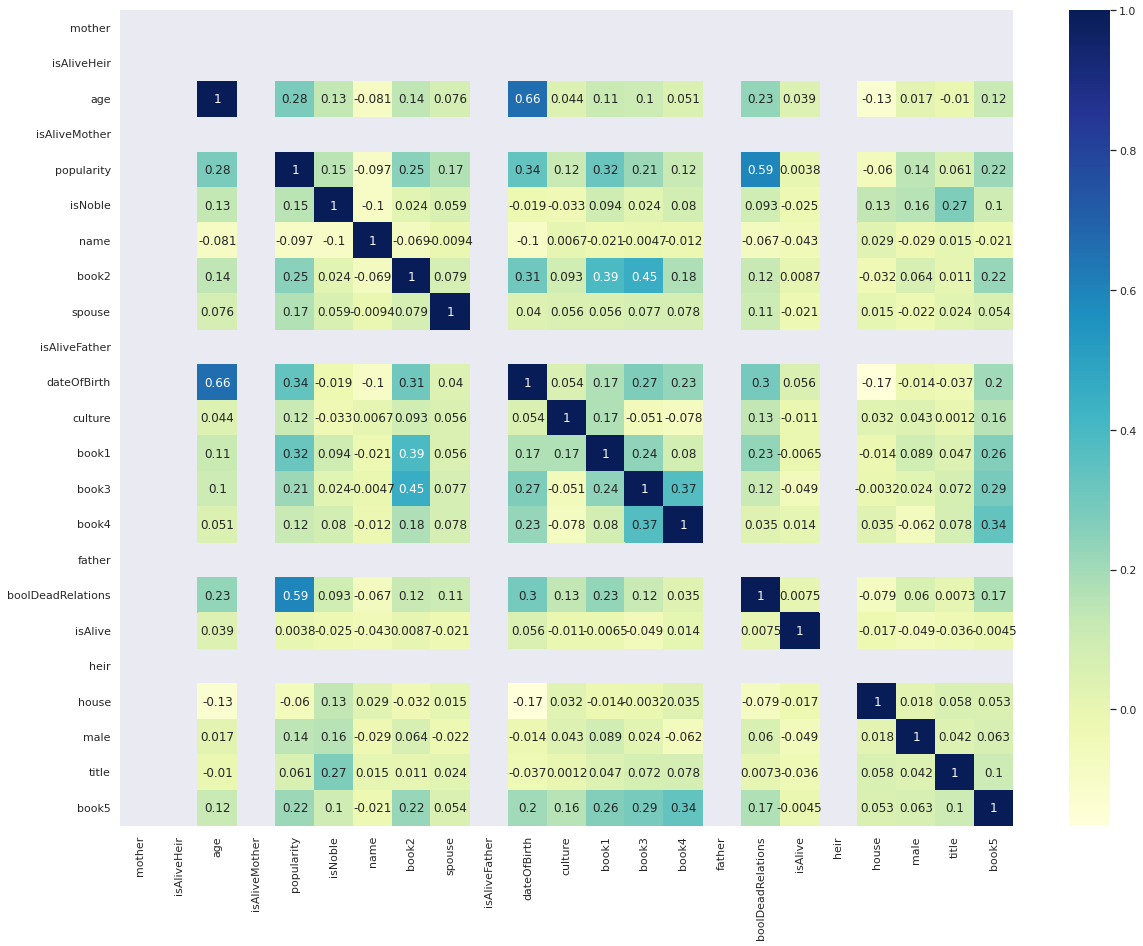

In [104]:
if PLOT_PROGRESS:
  correlation_after_normalization = plot_correlation(df[ intersection_columns ])

### Distribution

And the boxplot to see how the outliers are distributed now

4.35% - Column mother plotted
8.7% - Column isAliveHeir plotted
13.04% - Column age plotted
17.39% - Column isAliveMother plotted
21.74% - Column popularity plotted
26.09% - Column isNoble plotted
30.43% - Column name plotted
34.78% - Column book2 plotted
39.13% - Column spouse plotted
43.48% - Column isAliveFather plotted
47.83% - Column dateOfBirth plotted
52.17% - Column culture plotted
56.52% - Column book1 plotted
60.87% - Column book3 plotted
65.22% - Column book4 plotted
69.57% - Column father plotted
73.91% - Column boolDeadRelations plotted
78.26% - Column isAlive plotted
82.61% - Column heir plotted
86.96% - Column house plotted
91.3% - Column male plotted
95.65% - Column title plotted
100.0% - Column book5 plotted


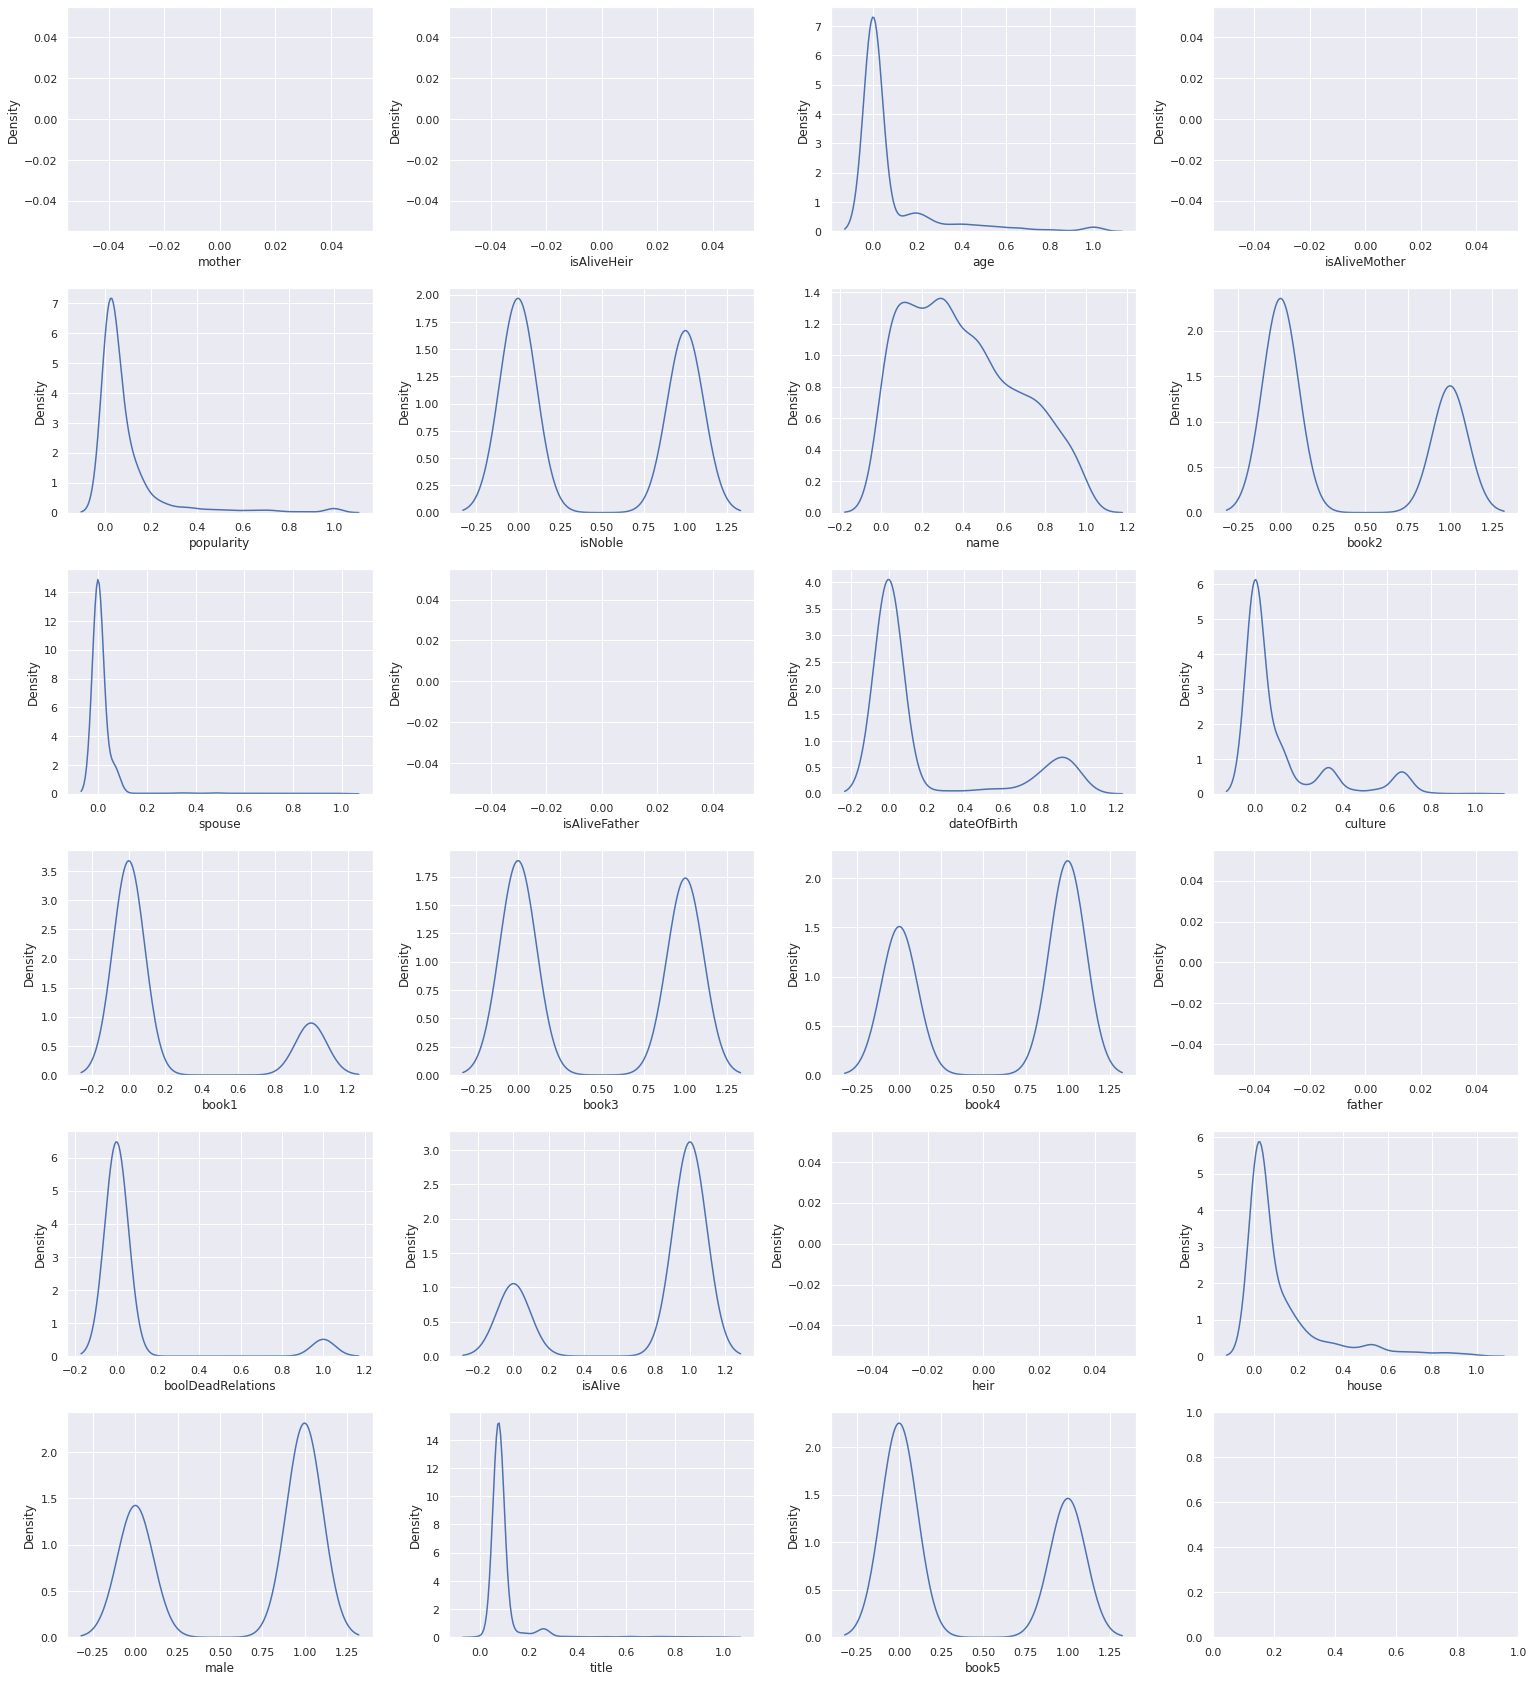

In [105]:
if PLOT_PROGRESS:
  subplot_grid(
    df[ intersection_columns ].select_dtypes(include=np.number),
    lambda index, df_column, ax, column: sns.kdeplot(df_column, ax=ax)
  )

## Data preparation

Let's do the final adjustments before jumping into the modelling and algorithms tuning, from this point forward the data should be ready for the model to use

### Backup

Once again, we must backup the information, we'll be doing the last steps before getting into the algorithms, that means, we'll make sure the data is as it should.

In [106]:
temp_df_pred = df.copy()

Total number of rows that have some missing value

In [107]:
# temp_df_pred.drop(columns=[
#   'dateOfBirth'
# ])[ temp_df_pred.isna().any(axis=1) ]

### Assignment

In [108]:
ignore = [
  TARGET_VARIABLE,
  'name',
  'dateOfBirth',

  # too many missing values
  # 'mother',
  # 'father',
  # 'heir',
  # 'spouse',
  # 'isAliveMother',
  # 'isAliveFather',
  # 'isAliveHeir',
]
train_cols = [ col for col in temp_df_pred.columns if col not in ignore ]
# train_cols = ['title', 'male', 'culture', 'house', 'book1', 'book2', 'book3', 'book4', 'book5', 'isMarried', 'isNoble', 'numDeadRelations', 'boolDeadRelations', 'isPopular', 'popularity']
# train_cols = ['male', 'isPopular', 'popularity']
X = temp_df_pred[ train_cols ]
y = temp_df_pred[TARGET_VARIABLE]

## Data Imbalancement

In classification, one of the biggest problems that adds unwanted bias to our model is to have a unbalanced dataset, which means having more examples of one type of data than another.

There are two main ways to fix it, by adjusting the data:

- Undersampling, which is the one we'll use
- Oversampling, not ideal, but a great one still

One of the best options however, is using models that take into account that imbalancement, RandomForest as an example, but it is a thing that's looked after. But we'll use undersampling, we won't have the best scores, but we will have an unbiased model and that's better on the long run

'raw_distribution'

1    1451
0     491
Name: isAlive, dtype: int64

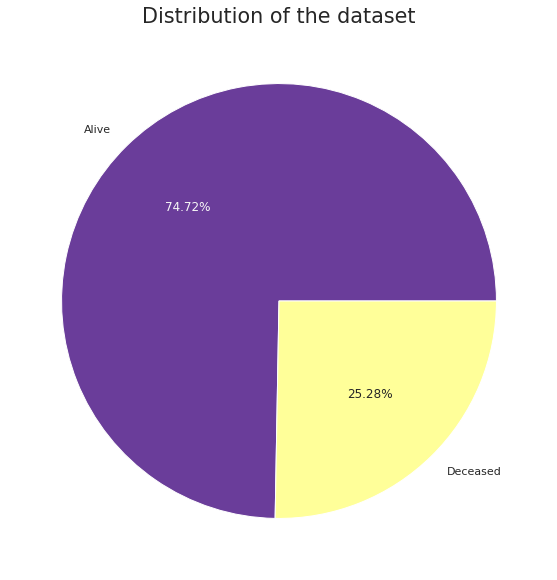

In [109]:
def plot_target_pie(
  dataframe: pd.DataFrame,
  title: str = 'Distribution of the dataset'
) -> None:
  pie_labels = ['Alive', 'Deceased']
  n_pie_labels = len(pie_labels)
  # pie_color_index = 1
  pie_color_index = 9
  raw_distribution = dataframe[TARGET_VARIABLE].value_counts()
  display(
    'raw_distribution',
    raw_distribution
  )

  fig = plt.figure(figsize=(10, 10))
  plt.title(title, fontsize='xx-large')
  ax, labels_texts, percentage_texts = plt.pie(
    raw_distribution,
    labels=pie_labels,
    colors=sns.color_palette('Paired')[pie_color_index:pie_color_index + n_pie_labels],
    autopct='%.2f%%',
  )
  percentage_texts[0].set_color('#F7F7F7')
  # percentage_texts[1].set_color('#ffffff')

if PLOT_PROGRESS:
  plot_target_pie(df)

Configuration control variables

In [110]:
USE_UNDERSAMPLER = True #@param {type:'boolean'}
USE_OVERSAMPLER = False #@param {type:'boolean'}
USE_DATA_BALANCEMENT = USE_UNDERSAMPLER or USE_OVERSAMPLER

### Undersampler

To fix data distribution problems it removes data from the groups that are unbalanced with more rows. It is a safer approach, but it is also one that decreases the score, at the end of the day, it's removing valuable information from our dataset.

In [111]:
len(X)

1942

In [112]:
def build_undersampler():
  undersampler = RandomUnderSampler(
    random_state=RANDOM_SEED,
    # sampling_strategy='majority',
    # replacement=True,
  )
  # undersampler = RepeatedEditedNearestNeighbours(
  #   n_neighbors=5,
  #   max_iter=100,
  # )

  return undersampler

if USE_UNDERSAMPLER:
  from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
  undersampler = build_undersampler()
  X_train, y_train = undersampler.fit_resample(X, y)

In [113]:
len(X_train), len(y_train)

(982, 982)

### Oversampler

Oversampler attempts to create more information from the unbalanced data. If undersampler decreases the number of elements of the majority, oversampler tries to increase the number of elements of the minority

In [114]:
len(X)

1942

In [115]:
if USE_OVERSAMPLER:
  from imblearn.over_sampling import RandomOverSampler
  oversampler = RandomOverSampler(
    random_state=RANDOM_SEED,
    sampling_strategy='minority',
  )
  X_train, y_train = oversampler.fit_resample(X, y)

In [116]:
len(X_train), len(y_train)

(982, 982)

As aforementioned, my conclusion with it's scores would be to don't do nothing at all with the imbalancement, because in this case scenario, there are more deaths than survivors, that's not a biased information, that's actually what seems to be happening

### Data Balancement

In [117]:
y_train.value_counts()

0    491
1    491
Name: isAlive, dtype: int64

'raw_distribution'

0    491
1    491
Name: isAlive, dtype: int64

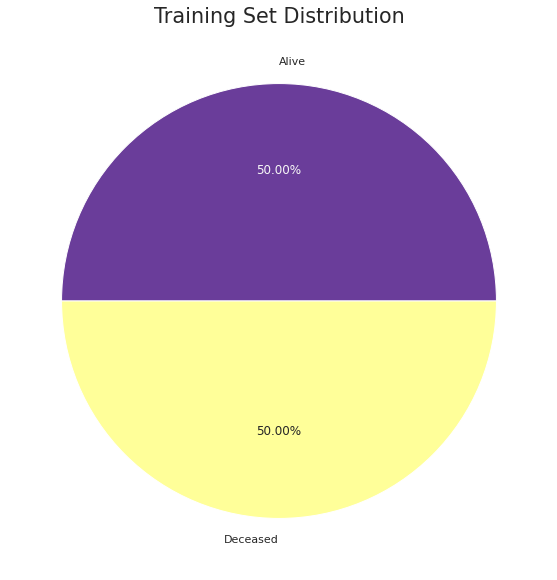

In [118]:
if PLOT_PROGRESS and USE_DATA_BALANCEMENT:
  plot_target_pie(
    pd.DataFrame({ TARGET_VARIABLE: y_train }),
    title='Training Set Distribution'
  )

### Data splitting

As to create the training and test datasets, we split the X and y into `train` and `test`

We have to take into account that, if we're fixing the imbalancement, as we should, we can now have an "unbalanced" testing data, since we've trained them evenly, it should be able to perform just as well with the minority

In [119]:
len(list(df.columns))

24

In [120]:
from sklearn.model_selection import train_test_split

if not USE_DATA_BALANCEMENT:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_SEED)
else:
  # we know for a fact that deceased are the minority class here, so let's make sure we work with that
  amount_of_minority_label = ceil(len(y_train) / 2)
  train_size = 350

  # we select the number of elements we want in our test set,
  # let's remember that we need as much training data as possible
  test_size = amount_of_minority_label - train_size
  # then we normalize that size
  test_size_normalized = test_size / amount_of_minority_label

  # they key difference here is that, stratifying our "y" value will make sure it's splitted evenly
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size_normalized, random_state=RANDOM_SEED, stratify=y_train)

### Test set imbalancement

In case we may want our test to be the rest of the dataset, which is not recomended.

If we're testing our unbalanced dataset, after balancing it, with another unbalanced set, we may get higher scores but not realize that we're having a lower performance on the minority label.

Testing with a balanced set leads to lower scores, but more precise if I'm making it make any sense.

In [121]:
FIX_TEST_IMBALANCEMENT = True #@param {type:'boolean'}

It'd be to filter by index

In [122]:
if not FIX_TEST_IMBALANCEMENT:
  X_test = X[~X.index.isin(X_train.index)].copy(deep = True).astype(np.float64)
  y_test = y[y.index.isin(X_test.index)]

Let's observe the size of our total testing set

In [123]:
len(X_test)

282

In [124]:
y_test.value_counts()

1    141
0    141
Name: isAlive, dtype: int64

'raw_distribution'

1    141
0    141
Name: isAlive, dtype: int64

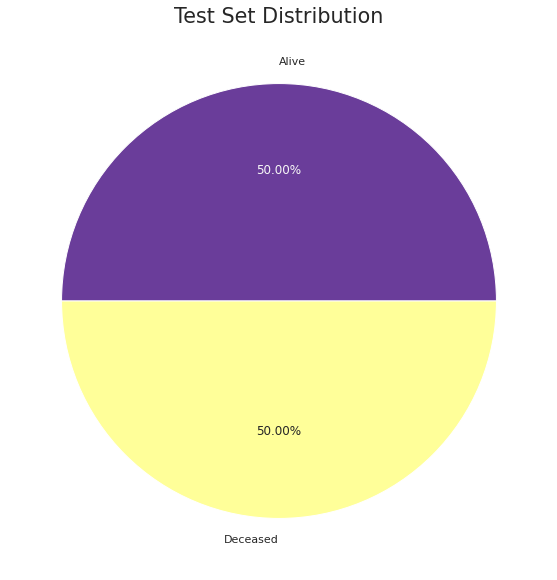

In [125]:
if PLOT_PROGRESS and USE_DATA_BALANCEMENT:
  plot_target_pie(
    pd.DataFrame({ TARGET_VARIABLE: y_test }),
    title='Test Set Distribution'
  )

Let's fix the test set imbalancement so that our scores can also be reliable. Only if you want to fix the test set imbalancement, which I recomend.

In [126]:
if FIX_TEST_IMBALANCEMENT and USE_UNDERSAMPLER:
  X_test, y_test = build_undersampler().fit_resample(X_test, y_test)

Aaaand now they're even!

'raw_distribution'

0    141
1    141
Name: isAlive, dtype: int64

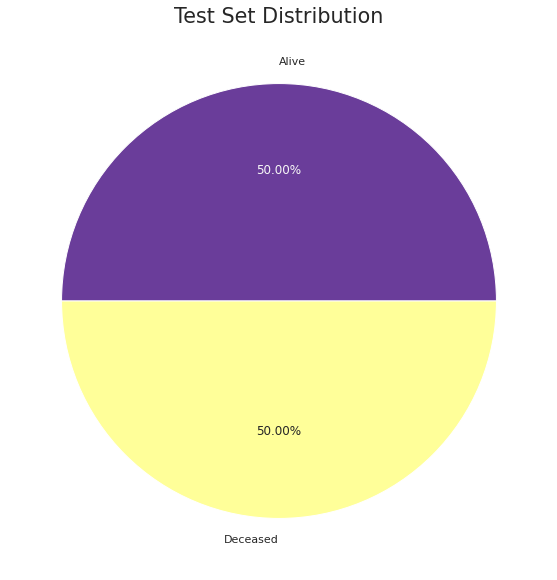

In [127]:
if PLOT_PROGRESS and USE_DATA_BALANCEMENT:
  plot_target_pie(
    pd.DataFrame({ TARGET_VARIABLE: y_test }),
    title='Test Set Distribution'
  )

## Modelling

The data is now ready, all that's left is to implement the algorithms and techniques that give us the best result, the one that we want, without going under overfitting.

Overfitting in a small dataset is almost a given, but if can apply some techniques (fixing the data imbalancement, filling some missing values, regularization, to name a few) we can have a higher change of avoiding it.

Without falling into underfitting, but that won't happen here.

### Imports

As for our algorithms and decomposition techniques, we will be using the scikit-learn library, a powerful but easy to use Python library.

Wether to import them at the top of the section or wherever is necessary is up to you, but it may be a good practice to import at the top some general elements that are guaranteed to be used.

In [128]:
from sklearn.metrics import r2_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA, FastICA
from sklearn import preprocessing
from sklearn.cluster import KMeans
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

# Models
from sklearn import linear_model
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LogisticRegression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Metrics
from sklearn.metrics import classification_report
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

### Helpers

Some functions to ease and secure some consistency while evaluating or tuning algorithms

It standarizes the output of the score so that it always uses the same format

In [129]:
def display_score(score, label = 'score'):
  print(f'{label} {round(score * 100, 2)}%')

#### Confusion Matrix

It is a table of n_labels x n_labels that let's us identify the performance of our classification model with a gaze, it shows the amount of:

- **True Negatives**, the model said it's **negative**, and it was **right**
- **False Negatives**, the model said it's **negative**, and it was **wrong**, it was positive
- **False Positives**, the model said it's **positive**, and it was **wrong**, it was negative
- **True Positives**, the model said it's **positive**, and it was **right**



```
-------------------
|  True  | False  |
-------------------
| False  |  True  |
-------------------
```



The riskier ones are usually the False Negatives, it means that, if it were to be about cancer/diabetes, we told someone they're fine, when they're really not.

It computes the confusion matrix with some default target names, and it also prints the classification report

In [130]:
default_target_names = ['Deceased', 'Alive']

def cmatrix(
  y_test,
  y_pred,
  # cmap: str = 'YlGnBu',
  # cmap: str = 'BlorRd',
  # cmap: str = 'Reds',
  # cmap: str = 'RdBu',
  cmap: str = 'Blues',
  target_names: List[str] = default_target_names,
  title: str = 'Example',
) -> np.ndarray:
  df_cm = confusion_matrix(y_test, y_pred)
  df_cm = df_cm.astype('float') / df_cm.sum(axis = 1)[:, np.newaxis]
  # df_cm = df_cm * 100

  # plt.figure(figsize = (10, 7))
  # plt.figure(figsize = (20, 10))
  _ = sns.heatmap(
    df_cm,
    square=True,
    annot=True,
    # annot_kws={"size": 13},
    annot_kws={'fontsize': 14},
    cmap=cmap,
    # fmt='g',
    xticklabels=target_names,
    yticklabels=target_names,
    cbar=True,
    cbar_kws={'orientation': 'horizontal'},
  ).set(
    xlabel='Predicted Class',
    ylabel='Actual Class',
    title=f'{title} - Confusion Matrix'
  )
  plt.show()

  print(classification_report(y_test, y_pred, target_names=target_names))

  return df_cm

The far more detailed version from shaildeliwala

In [131]:
def make_cm(p, title: str):
    cm = confusion_matrix(y_test, np.argmax(p, axis = 1))
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    _ = sns.heatmap(
      cm,
      square=True,
      xticklabels=default_target_names,
      annot=True,
      annot_kws={'fontsize': 13},
      yticklabels=default_target_names,
      cbar=True,
      cbar_kws={'orientation': 'horizontal'},
      cmap='Blues'
    ).set(
      xlabel='Predicted Class',
      ylabel='Actual Class',
      title=title
    )

#### Explainability

Some models can give you their weights, which can help, to a certain degree, help us understand how they're making decisions

In [132]:
def plot_model_explainability(
  X_explainability: pd.DataFrame,
  coeficients,
  title: str = ''
) -> None:
  df_logistic = pd.DataFrame(list(zip(X_explainability.columns, coeficients[0])))
  df_logistic = df_logistic.reindex(
    df_logistic[1].abs().sort_values().index
  ).set_index(0)
  ax = df_logistic.plot.barh(
    width=.6,
    legend="",
    figsize = (12, 9)
  )
  ax.set_title(
    title,
    y = 1.03,
    fontsize = 16.
  )
  _ = ax.set(frame_on = False, xlabel = "", xticklabels = "", ylabel = "")

  for i, label in enumerate(list(df_logistic.index)):
      score = df_logistic.loc[label][1]
      ax.annotate('%.2f' % score, (score + (-.12 if score < 0 else .02), i - .2), fontsize = 10.5)

### StandardScaler

We've already scaled the data, but just in case there's a chance to work with new, unscaled data, there's this normalization helper function, we used minmax before because of the number of outliers, but here we'll use Standard

In [133]:
def scale_data(X_train: pd.DataFrame, display: bool = False) -> pd.DataFrame:
  scaler = preprocessing.StandardScaler().fit(X_train)

  if display:
    print('mean_', scaler.mean_)
    print('scale_', scaler.scale_)

  X_scaled = scaler.transform(X_train)

  return X_scaled

### PCA

Principal Component Analysis is an unsupervised feature reduction decomposition technique that allows us to maintain almost the same information in many less attributes, it creates what's called hyperattributes

This is the helper function

In [134]:
def to_pca(
  values: pd.DataFrame,
  n_components: int = 2,
  display: bool = False,
  pca_model: PCA = None,
  y_true: pd.DataFrame = None,
  scale: bool = False
) -> Tuple[pd.DataFrame, PCA]:
  scaled_values = values
  if scale:
    scaled_values = scale_data(values)

  if not pca_model:
    pca = PCA(n_components=n_components)
    pca.fit(scaled_values, y_true)
  else:
    pca = pca_model

  if display:
    print('explained_variance_ratio_', pca.explained_variance_ratio_.sum() * 100)
    # print('singular_values_', pca.singular_values_)

  X_transform = pca.transform(scaled_values)

  return X_transform, pca

Before anything else, we must plot to see the ideal number of components, we'll use the elbow method. For that we'll use simple plotting system

In [135]:
def plot_pca_explainability(
  X_values: pd.DataFrame,
  y_values: pd.DataFrame,
  step_range = None,
) -> pd.DataFrame:
  pca_explainability = []

  if not step_range:
    n_columns = len(X_values.columns)
    n_columns = n_columns if n_columns < 10 else int(n_columns * .5)
    # n_steps = 20
    n_steps = min(10, n_columns)
    step_range = range(1, n_columns, int(n_columns / n_steps))

  for n_components in step_range:
    pca = PCA(n_components)
    pca.fit(X_values, y_values)

    pca_explainability.append([
      n_components,
      pca.explained_variance_ratio_.sum(),
    ])

  df_pca_explainability = pd.DataFrame(pca_explainability, columns=['n_components', 'explainability'])
  plt.figure(figsize=(20, 10))
  _ = sns.lineplot(
    data=df_pca_explainability,
    x='n_components',
    y='explainability'
  )
  # plt.ylim(0, 1)

  return df_pca_explainability

#### Explainability Plot

PCA reduces the number of features by n components, we can plot the number of components required to obtain a certain explainability and, using the elbow method, we can see from which number of components, adding more doesn't really increase that much the explainability, above 85% is considered great.

The less components, the faster we compute, the less explainability, that's why it's important to plot the PCA explainability

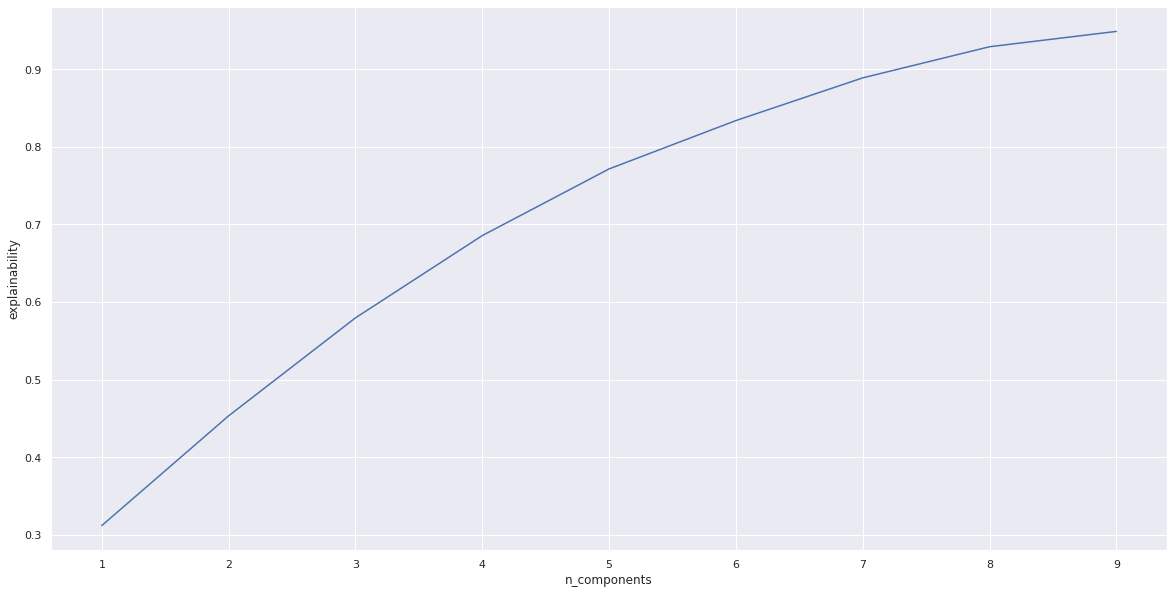

In [136]:
if PLOT_PROGRESS:
  df_pca_explainability = plot_pca_explainability(X_train, y_train)

A table view can help us have a more detailed version with the precise explainability

In [137]:
if PLOT_PROGRESS:
  df_pca_explainability

Once we've plotted it, we can apply the number of components we want

In [138]:
print('Normal')
# pca_n_components = 2
# pca_n_components = 43
# pca_n_components = 15
# pca_n_components = 15
pca_n_components = 5
# pca_n_components = 2
X_train_pca, pca_model = to_pca(X_train, y_true=y_train, n_components=pca_n_components, display=True)
X_test_pca, _ = to_pca(X_test, pca_n_components, pca_model=pca_model)

print('Bigger')
# pca_n_components_bigger = 190
# pca_n_components_bigger = 40
pca_n_components_bigger = 10
# pca_n_components_bigger = 3
X_train_pca_bigger, pca_model = to_pca(X_train, y_true=y_train, n_components=pca_n_components_bigger, display=True)
X_test_pca_bigger, _ = to_pca(X_test, pca_n_components_bigger, pca_model=pca_model)

Normal
explained_variance_ratio_ 77.13233554686174
Bigger
explained_variance_ratio_ 96.67876333618062


We also use an scaled PCA version, this one will have a much less explainability, it's just for showcasing purposes

In [139]:
print('Scaled', len(X_train.columns))
# pca_n_components_scaled = 200
# pca_n_components_scaled = 50
# pca_n_components_scaled = 10
pca_n_components_scaled = 3
X_train_pca_scaled, pca_model_scaled = to_pca(X_train, y_true=y_train, n_components=pca_n_components_scaled, display=True, scale=True)
X_test_pca_scaled, _ = to_pca(X_test, pca_n_components, pca_model=pca_model_scaled, scale=True)

Scaled 21
explained_variance_ratio_ 44.625618681850526


### ICA

Independant Component Analysis, is a decomposition technique, rather than trying to remove/decompress the most uncorrelated values, it attempts to detect the independant values in a dataset.

It may not serve much purpose in this example, but one of the main important objectives for this project was to try almost everything out. It rised a bit in popularity "lately".

On the contrary of PCA, ICA does not need to be plotted since it does not explain the variables, it extracts independant attributes.

We, once again, create a helper function, similar to the one created for PCA

In [140]:
def to_ica(
  values: pd.DataFrame,
  n_components: int = 2,
  display: bool = False,
  ica_model: PCA = None,
  y_true: pd.DataFrame = None,
  scale: bool = False
):
  scaled_values = values
  if scale:
    scaled_values = scale_data(values)

  if not ica_model:
    ica = FastICA(n_components=n_components)
    ica.fit(scaled_values, y_true)
  else:
    ica = ica_model
  if display:
    # print('explained_variance_ratio_', ica.explained_variance_ratio_.sum())
    # print('singular_values_', ica.singular_values_)
    print('ica', ica)

  X_transform = ica.fit_transform(scaled_values)

  return X_transform, ica

We apply the function

In [141]:
ica_n_components = 10
X_train_ica, ica_model = to_ica(X_train, ica_n_components, display=True)
X_test_ica, _ = to_ica(X_test, ica_n_components, ica_model=ica_model)

ica FastICA(n_components=10)


### Traditional

In case we want to set the default training values to something, to some sort of modifiction or subset, this is the place to try those things out

In [142]:
X_transform = X_train
X_test_transform = X_test

### Linear Regression

We can obviously apply, but it is highly inadequate, regression models have no place in the purpose of this project, they can not classify, they're meant to predict **continue** `(-Infinite, Infinite)` values, and we want to predict **discrete** `(0, 1)` values.

It is true that classification and regression problems, under the hood, are quire similar, but the upper layer is what matters (the activation used on the output).

In fact, the metric for binary classification (say, binary for this project, but also works for multiclass) is `f1_score`, but regression uses the `r2_score`

In [143]:
regr = linear_model.LinearRegression()
regr.fit(X_transform, y_train)
y_pred_linear_regression = regr.predict(X_test_transform)

display_score(r2_score(y_test, y_pred_linear_regression), 'Regression')

Regression 0.52%


We could try to map the outcome to parse the predictions, which would be similar to the logistic regression.

In [144]:
y_pred_linear_regressiong_mapped = np.vectorize(round)(y_pred_linear_regression)
display_score(f1_score(y_test, y_pred_linear_regressiong_mapped), 'Regression')

Regression 56.34%


Or to even apply the logarithmic function:

In [145]:
y_pred_linear_regressiong_mapped = np.vectorize(np.log)(y_pred_linear_regression)
y_pred_linear_regressiong_mapped = np.vectorize(lambda x: round(x))(y_pred_linear_regression)
display_score(f1_score(y_test, y_pred_linear_regressiong_mapped), 'Regression')

Regression 56.34%


It was used just as an example to prove the point of difference between regression and classification problems.

We want to predict wether a character will survive/remain alive, as to better predict that outcome, classification is the way to go.

Because we just really need two outcomes, will they survive? or will they not?

### Logistic Regression

Logisitc Regression is the same as Linear Regression but with a logarithmic function applied to the outcome so the value always stays between 0 and 1, wherever our decision boundary lies, that's how our model will perform, that's why regression and classification are, in fact, kind of similar.



The common configuration

In [146]:
logistic_configuration = {
  'random_state': RANDOM_SEED,
  'C': .5,
  'solver': 'liblinear',
  'multi_class': 'ovr',
}

#### Normal

In [147]:
logistic_regr = LogisticRegression(**logistic_configuration).fit(X_transform, y_train)
y_pred_logistic_regr = logistic_regr.predict(X_test_transform)
preds_logistic_regr = logistic_regr.predict_proba(X_test_transform)
logistic_regression_score = logistic_regr.score(X_test_transform, y_test)

display_score(logistic_regression_score)
# print('logistic_regression_score', round(logistic_regression_score * 100, 2))

score 55.67%


#### Decomposed with PCA

In [148]:
logistic_regr_pca = LogisticRegression(**logistic_configuration).fit(X_train_pca, y_train)
y_pred_logistic_regr_pca = logistic_regr_pca.predict(X_test_pca)
logistic_regr_pca.predict_proba(X_test_pca)
logistic_regression_pca_score = logistic_regr_pca.score(X_test_pca, y_test)

display_score(logistic_regression_pca_score)

score 48.23%


#### Decomposed with ICA

In [149]:
logistic_regr_ica = LogisticRegression(**logistic_configuration).fit(X_train_ica, y_train)
y_pred_logistic_regr_ica = logistic_regr_ica.predict(X_test_ica)
logistic_regr_ica.predict_proba(X_test_ica)
logistic_regression_ica_score = logistic_regr_ica.score(X_test_ica, y_test)

display_score(logistic_regression_ica_score)

score 54.96%


#### Explainability

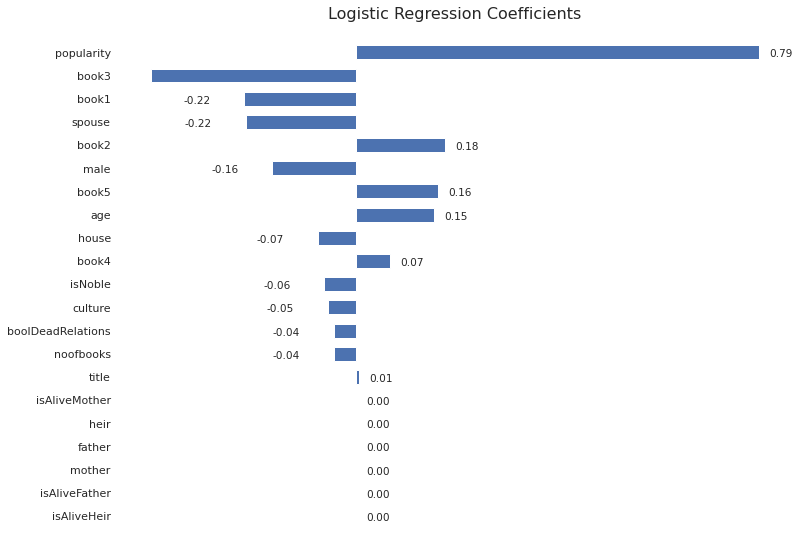

In [150]:
if PLOT_PROGRESS:
  plot_model_explainability(
    X_train,
    logistic_regr.coef_,
    title='Logistic Regression Coefficients'
  )

#### Classification report

In [151]:
logistic_regression_report = classification_report(
  y_test, y_pred_logistic_regr,
  # target_names=['Deceased', 'Alive']
)
print(logistic_regression_report)
roc_auc_score(y_test, logistic_regr.decision_function(X_test))

              precision    recall  f1-score   support

    Deceased       0.56      0.54      0.55       141
       Alive       0.55      0.57      0.56       141

    accuracy                           0.56       282
   macro avg       0.56      0.56      0.56       282
weighted avg       0.56      0.56      0.56       282



0.5643076304008853

#### Confusion Matrix

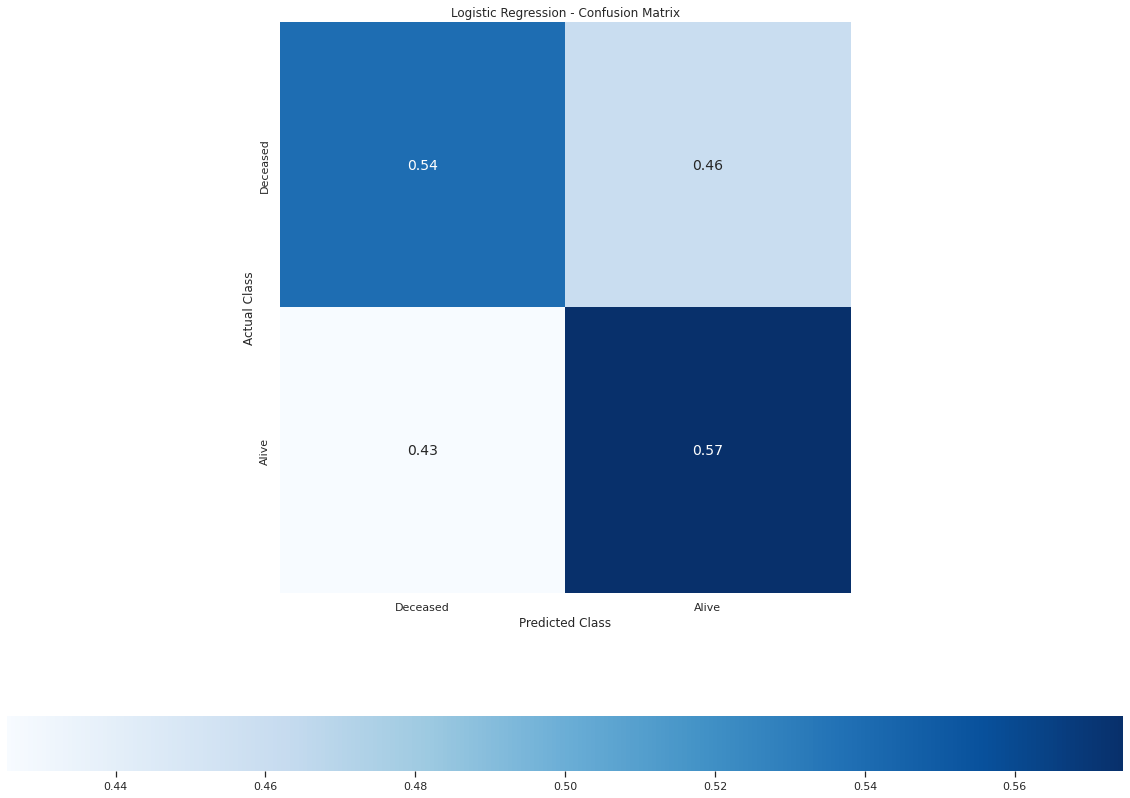

              precision    recall  f1-score   support

    Deceased       0.56      0.54      0.55       141
       Alive       0.55      0.57      0.56       141

    accuracy                           0.56       282
   macro avg       0.56      0.56      0.56       282
weighted avg       0.56      0.56      0.56       282



In [152]:
if PLOT_PROGRESS:
  logistic_regression_cmatrix = cmatrix(y_test, y_pred_logistic_regr, title='Logistic Regression')
  # logistic_regression_cmatrix = make_cm(preds_logistic_regr, "Logistic Regression")

### Polynomial Logistic Regression

It's the same than a Logistic Regression, but with polynomial features, it applies exactly the same logic than with Linear Regression, that is, to better adapt to the actual regression of the values.

Adding polynomial adds behaviour to our model, they add shape to our straight line

We compute some degrees to see it's evolution progress

In [153]:
from sklearn.preprocessing import PolynomialFeatures

In [154]:
if PLOT_PROGRESS:
  poly_results = list()

  for degree in range(1, 5):
    poly_model = PolynomialFeatures(degree=degree)
    poly_model.fit(X_transform, y_train)
    X_train_poly = poly_model.transform(X_transform)
    X_test_poly = poly_model.transform(X_test_transform)
    poly_logistic_model = LogisticRegression(**logistic_configuration).fit(X_train_poly, y_train)
    poly_logistic_score = poly_logistic_model.score(X_test_poly, y_test)
    poly_results.append({
      'degree': degree,
      'score': poly_logistic_score,
      'components': X_train_poly.shape[1],
    })
    print(f'Just finished computing {degree}th degree')

Just finished computing 1th degree
Just finished computing 2th degree
Just finished computing 3th degree
Just finished computing 4th degree


Let's plot the results to visualize them

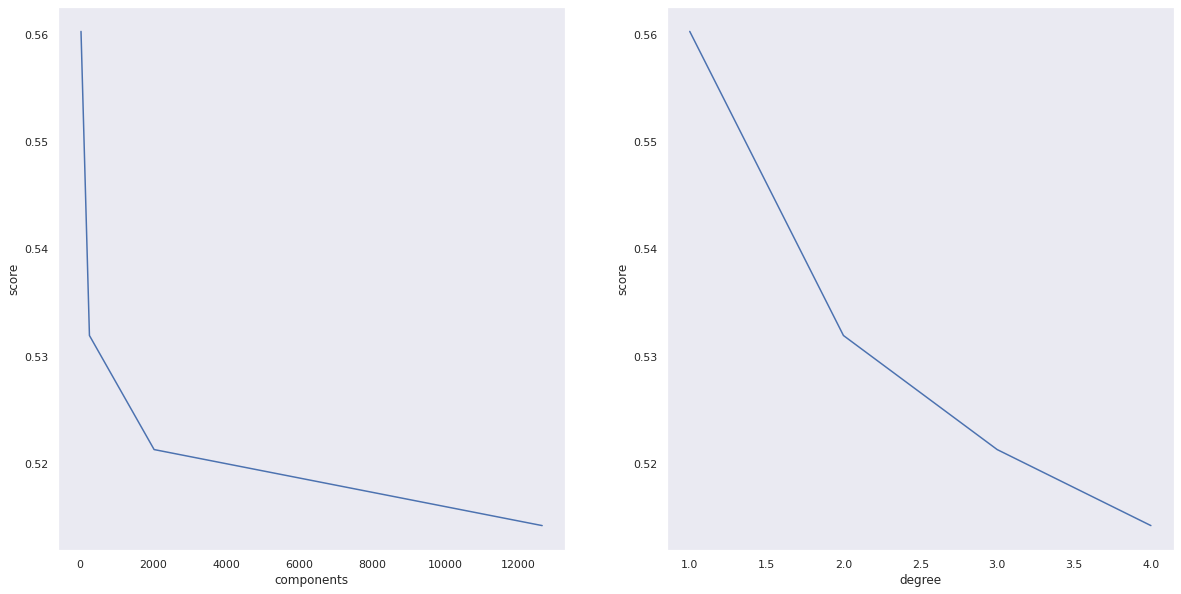

In [155]:
if PLOT_PROGRESS:
  fig, axes = plt.subplots(1, 2, figsize=(20, 10))
  poly_results_df = pd.DataFrame(poly_results)

  # per component
  sns.lineplot( data=poly_results_df, x='components', y='score', ax=axes[0] )
  axes[0].grid()

  # per degree
  sns.lineplot( data=poly_results_df, x='degree', y='score', ax=axes[1] )
  axes[1].grid()

  # plt.ylim(0, 1)
  plt.show()

In [156]:
# poly_model = PolynomialFeatures(degree=poly_results[-1]['degree'])
poly_model = PolynomialFeatures(degree=1)
poly_model.fit(X_transform, y_train)

X_train_poly = poly_model.transform(X_transform)
X_test_poly = poly_model.transform(X_test_transform)

In [157]:
poly_logistic_regr = LogisticRegression(**logistic_configuration).fit(X_train_poly, y_train)
y_pred_poly_logistic_regr = poly_logistic_regr.predict(X_test_poly)
preds_poly_logistic_regr = poly_logistic_regr.predict_proba(X_test_poly)
poly_logistic_regression_score = poly_logistic_regr.score(X_test_poly, y_test)

display_score(poly_logistic_regression_score)
# print('poly_logistic_regression_score', round(poly_logistic_regression_score * 100, 2))

score 56.03%


#### PCA Explainability

We're testing this section just because of the exponentially increasing amount of components it generates to ease it's computing exhaustion

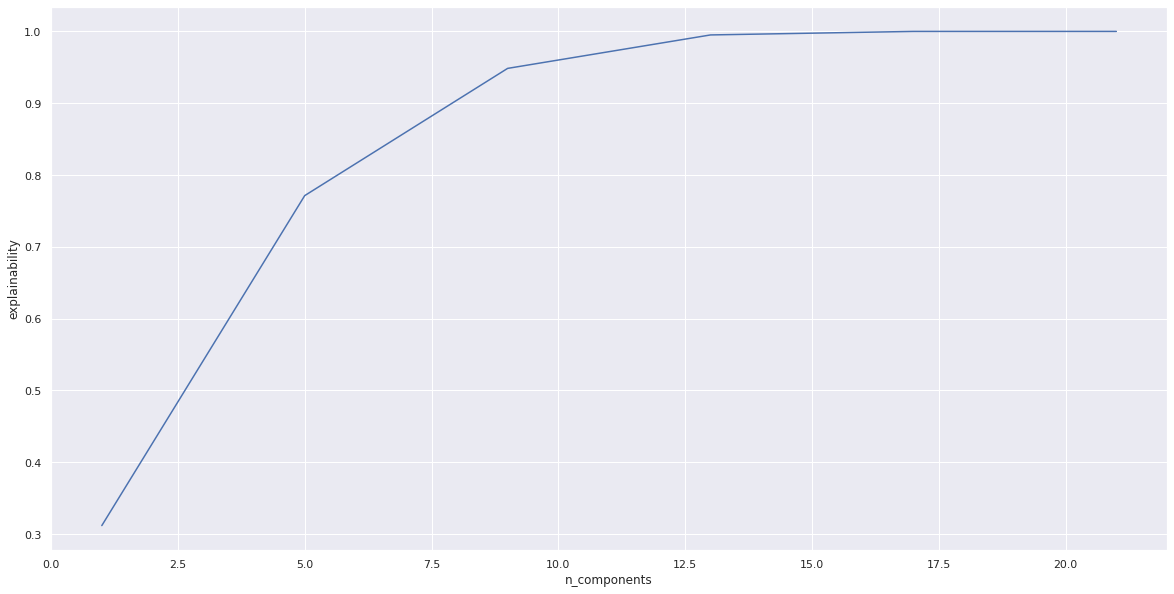

In [158]:
if PLOT_PROGRESS:
  df_poly_pca_explainability = plot_pca_explainability(
    X_train_poly,
    y_train,
    # step_range=range(1, 250, 75),
    step_range=range(1, X_train_poly.shape[1], int(X_train_poly.shape[1] / 5)),
  )

A table view for a more detailed version

In [159]:
if PLOT_PROGRESS:
  df_poly_pca_explainability

#### Decomposed with PCA


In [160]:
# poly_pca_n_components = 3
poly_pca_n_components = 8

X_train_poly_pca, poly_pca_model = to_pca(X_train_poly, poly_pca_n_components, y_true=y_train, display=True)
X_test_poly_pca, _ = to_pca(X_test_poly, poly_pca_n_components, pca_model=poly_pca_model, y_true=y_test, display=True)

explained_variance_ratio_ 92.87540291126122
explained_variance_ratio_ 92.87540291126122


In [161]:
poly_logistic_regr_pca = LogisticRegression(**logistic_configuration).fit(X_train_poly_pca, y_train)
y_pred_poly_logistic_regr_pca = poly_logistic_regr_pca.predict(X_test_poly_pca)
preds_poly_logistic_regr_pca = poly_logistic_regr_pca.predict_proba(X_test_poly_pca)
poly_logistic_regression_pca_score = poly_logistic_regr_pca.score(X_test_poly_pca, y_test)

display_score(poly_logistic_regression_pca_score)

score 57.09%


#### Decomposed with ICA

In [162]:
poly_ica_n_components = 10

X_train_poly_ica, poly_ica_model = to_ica(X_train_poly, poly_ica_n_components)
X_test_poly_ica, _ = to_ica(X_test_poly, poly_ica_n_components, ica_model=poly_ica_model)

In [163]:
poly_logistic_regr_ica = LogisticRegression(**logistic_configuration).fit(X_train_poly_ica, y_train)
y_pred_poly_logistic_regr_ica = poly_logistic_regr_ica.predict(X_test_poly_ica)
preds_poly_logistic_regr_ica = poly_logistic_regr_ica.predict_proba(X_test_poly_ica)
poly_logistic_regression_ica_score = poly_logistic_regr_ica.score(X_test_poly_ica, y_test)

display_score(poly_logistic_regression_ica_score)

score 53.19%


#### Classification report

In [164]:
if PLOT_PROGRESS:
  poly_logistic_regression_report = classification_report(
    y_test, y_pred_poly_logistic_regr,
  )
  print(poly_logistic_regression_report)
  roc_auc_score(y_test, poly_logistic_regr.decision_function(X_test_poly))

              precision    recall  f1-score   support

    Deceased       0.56      0.55      0.55       141
       Alive       0.56      0.57      0.57       141

    accuracy                           0.56       282
   macro avg       0.56      0.56      0.56       282
weighted avg       0.56      0.56      0.56       282



#### Confusion Matrix

In [165]:
if PLOT_PROGRESS:
  logistic_regression_cmatrix = cmatrix(y_test, y_pred_poly_logistic_regr, title='Polynomial Logistic Regression')

              precision    recall  f1-score   support

    Deceased       0.56      0.55      0.55       141
       Alive       0.56      0.57      0.57       141

    accuracy                           0.56       282
   macro avg       0.56      0.56      0.56       282
weighted avg       0.56      0.56      0.56       282



### KMeans Clustering

KMeans Clustering is an Unsupervised Grouping/Segmentation technique, which means, it finds clusters, groups of values that are similar.

It can be used for classification, but it's not fitted for that purpose. It is also important to note that, it tends to work better with PCA than with ICA.

In [166]:
from sklearn.cluster import KMeans

#### Best number of clusters

As we're working with clusters, instead of labels, we work with centroids, so we can choose a number of clusters/centroids that best fits our objectives, for that purpose, we can, once again, plot them and use the elbow method, as with PCA.

As we're working with the squared error, it's a negative value, the higher it gets, it means the less local error we have, so, the less the better

In [167]:
if PLOT_PROGRESS:
  number_of_clusters = range(1, 100, 5) # El número de iteraciones que queremos hacer.
  sample_kmeans = list(map(
    lambda n_clusters: KMeans(n_clusters=n_clusters),
    number_of_clusters
  ))
  kmeans_clusters_scores = list(map(
    lambda index: sample_kmeans[index].fit(X).score(X),
    range(len(sample_kmeans))
  ))

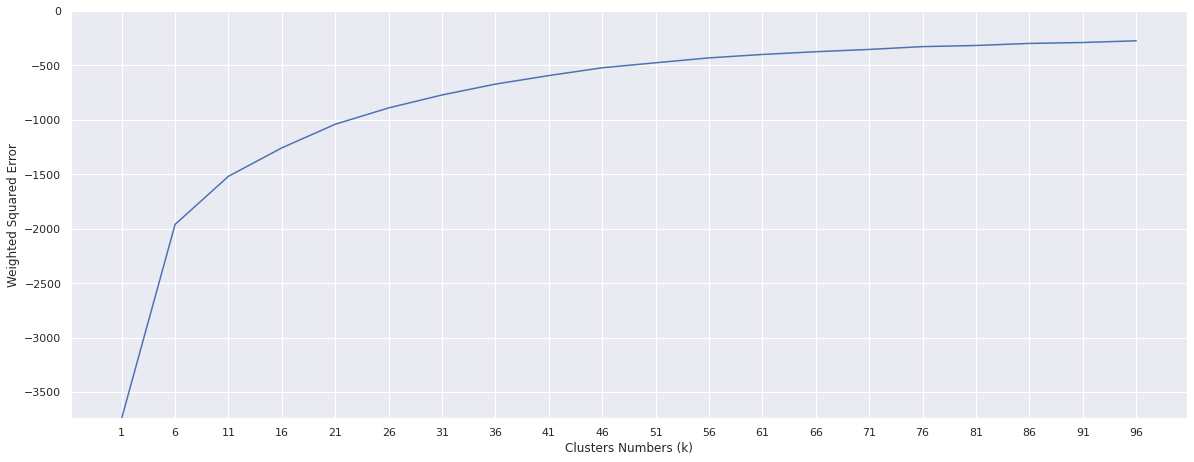

In [168]:
if PLOT_PROGRESS:
  plt.figure(figsize=(20, 7.5))
  plt.xticks(number_of_clusters)

  plt.xlabel('Clusters Numbers (k)')
  plt.ylabel('Weighted Squared Error')

  _ = plt.plot(number_of_clusters, kmeans_clusters_scores)
  plt.ylim(kmeans_clusters_scores[0], 1)
  plt.show()

#### Normal

In [169]:
kmeans = KMeans(
  n_clusters=2,
  random_state=RANDOM_SEED,
).fit(X_transform)
kmeans.labels_
y_pred_kmeans = kmeans.predict(X_test_transform)
centroids = kmeans.cluster_centers_
# display(centroids)

kmeans_score = f1_score(y_test, y_pred_kmeans)
display_score(kmeans_score)

score 57.06%


#### Decomposed with PCA

In [170]:
# X_train_pca_kmeans, kmeans_pca_model = to_pca(X_train, 3, y_true=y_train, scale=True)
# X_test_pca_kmeans, _ = to_pca(X_test, 3, pca_model=kmeans_pca_model, scale=True)

kmeans_pca = KMeans(
  n_clusters=2,
  random_state=RANDOM_SEED,
).fit(X_train_pca)
kmeans_pca.labels_
y_pred_kmeans_pca = kmeans_pca.predict(X_test_pca)
centroids = kmeans_pca.cluster_centers_

kmeans_pca_score = f1_score(y_test, y_pred_kmeans_pca)
display_score(kmeans_pca_score)

score 40.34%


#### Decomposed with ICA

In [171]:
# X_train_ica_kmeans, kmeans_ica_model = to_ica(X_train, 2, y_true=y_train, scale=True)
# X_test_ica_kmeans, _ = to_ica(X_test, 2, ica_model=kmeans_ica_model, scale=True)

kmeans_ica = KMeans(n_clusters=2, random_state=RANDOM_SEED).fit(X_train_ica)
kmeans_ica.labels_
y_pred_kmeans_ica = kmeans_ica.predict(X_test_ica)
centroids = kmeans_ica.cluster_centers_

kmeans_ica_score = f1_score(y_test, y_pred_kmeans_ica)
display_score(kmeans_ica_score)

score 42.98%


#### Confusion Matrix

In [172]:
if PLOT_PROGRESS:
  kmeans_cmatrix = cmatrix(y_test, y_pred_kmeans_ica, title='Kmeans')

              precision    recall  f1-score   support

    Deceased       0.51      0.65      0.57       141
       Alive       0.51      0.37      0.43       141

    accuracy                           0.51       282
   macro avg       0.51      0.51      0.50       282
weighted avg       0.51      0.51      0.50       282



### MiniBatch KMeans Clustering

MiniBatch KMeans is a computationally more efficient KMeans. But it's practically the same 

In [173]:
from sklearn.cluster import MiniBatchKMeans

#### Best number of clusters

We can, and should, evaluate the most adequate number of clusters for the MiniBatch Kmeans model

In [174]:
if PLOT_PROGRESS:
  number_of_clusters_minibatch = range(1, 100, 5) # El número de iteraciones que queremos hacer.
  sample_minibatch_kmeans = list(map(
    lambda n_clusters: MiniBatchKMeans(n_clusters=n_clusters),
    number_of_clusters_minibatch
  ))
  minibatch_kmeans_clusters_scores = list(map(
    lambda index: sample_minibatch_kmeans[index].fit(X).score(X),
    range(len(sample_minibatch_kmeans))
  ))

We compute, and plot, separately

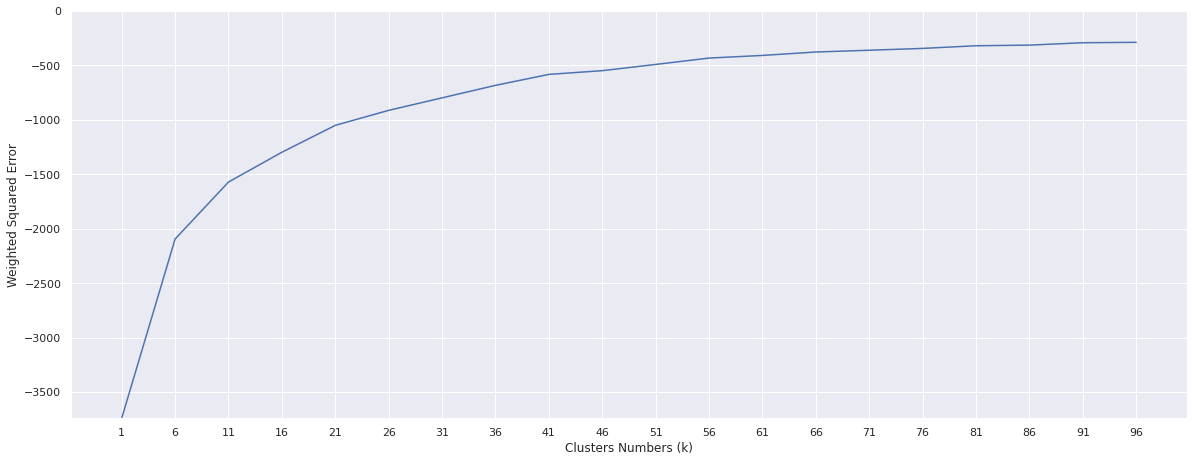

In [175]:
if PLOT_PROGRESS:
  plt.figure(figsize=(20, 7.5))
  plt.xticks(number_of_clusters_minibatch)

  plt.xlabel('Clusters Numbers (k)')
  plt.ylabel('Weighted Squared Error')

  _ = plt.plot(number_of_clusters_minibatch, minibatch_kmeans_clusters_scores)
  plt.ylim(kmeans_clusters_scores[0], 1)
  plt.show()

#### Normal

In [176]:
batch_kmeans = MiniBatchKMeans(n_clusters=2, random_state=RANDOM_SEED, batch_size=6, max_iter=10).fit(X_transform)
batch_kmeans.cluster_centers_
y_pred_batch_kmeans = batch_kmeans.predict(X_test)

minibatch_kmeans_score = f1_score(y_test, y_pred_batch_kmeans)
display_score(minibatch_kmeans_score)

score 57.06%


#### Decomposed with PCA

In [177]:
batch_kmeans_pca = MiniBatchKMeans(n_clusters=2, random_state=RANDOM_SEED, batch_size=6, max_iter=10).fit(X_train_pca)
batch_kmeans_pca.cluster_centers_
y_pred_batch_kmeans_pca = batch_kmeans_pca.predict(X_test_pca)

minibatch_kmeans_pca_score = f1_score(y_test, y_pred_batch_kmeans_pca)
display_score(minibatch_kmeans_pca_score)

score 56.88%


#### Decomposed with ICA

In [178]:
batch_kmeans_ica = MiniBatchKMeans(n_clusters=2, random_state=RANDOM_SEED, batch_size=6, max_iter=10).fit(X_train_ica)
batch_kmeans_ica.cluster_centers_
y_pred_batch_kmeans_ica = batch_kmeans_ica.predict(X_test_ica)

minibatch_kmeans_ica_score = f1_score(y_test, y_pred_batch_kmeans_ica)
display_score(minibatch_kmeans_ica_score)

score 45.34%


#### Confusion Matrix

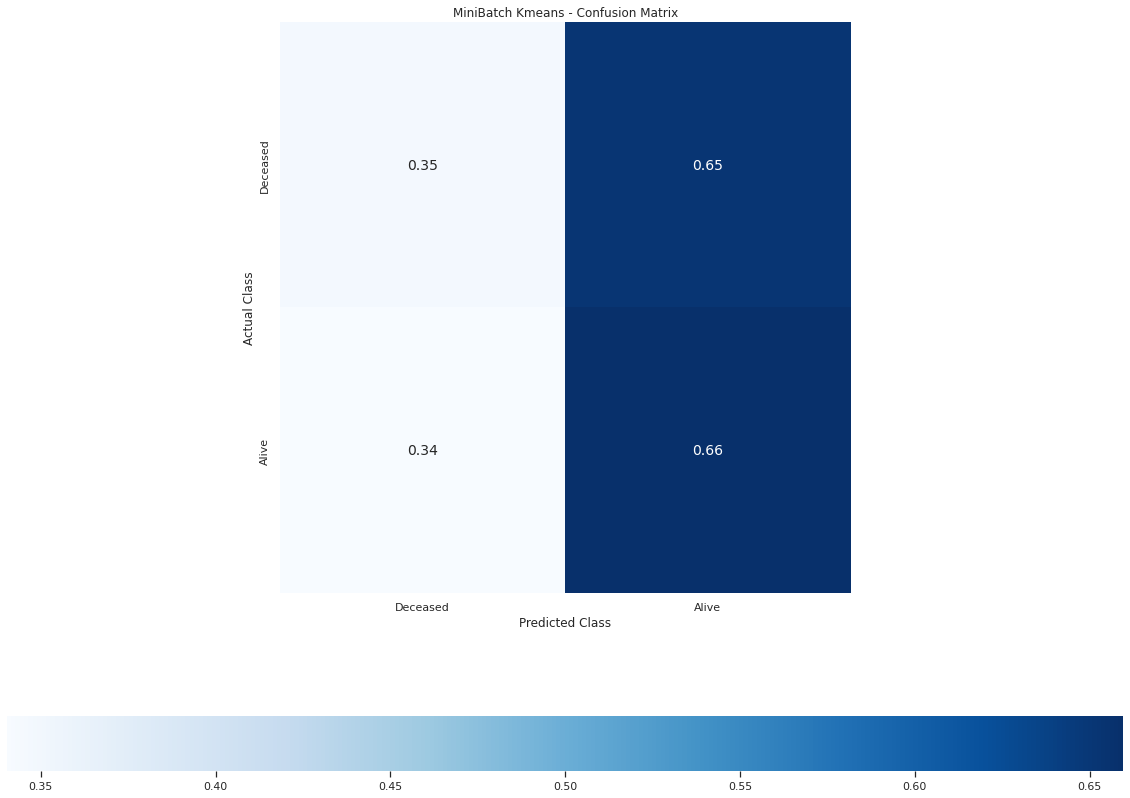

              precision    recall  f1-score   support

    Deceased       0.51      0.35      0.41       141
       Alive       0.50      0.66      0.57       141

    accuracy                           0.50       282
   macro avg       0.50      0.50      0.49       282
weighted avg       0.50      0.50      0.49       282



In [179]:
if PLOT_PROGRESS:
  minibatch_kmeans_cmatrix = cmatrix(y_test, y_pred_batch_kmeans, title='MiniBatch Kmeans')

### KNearest-Neighbour

Is a supervised machine learning algorithm, data near other tends to be of the same group, or similar to say the least

In [180]:
from sklearn.neighbors import KNeighborsClassifier

#### Best number of neighbors

As we did with all the other clustering techniques, we evaluate them

In [276]:
number_of_neighbors = range(1, 100, 1) # El número de iteraciones que queremos hacer.
sample_knn = list(map(
  lambda n_neighbors: KNeighborsClassifier(n_neighbors=n_neighbors),
  number_of_neighbors
))
knn_neighbors_scores = list(map(
  lambda index: sample_knn[index].fit(X_train, y_train).score(X_test, y_test),
  range(len(sample_knn))
))

In this case, we're not evaluating the weighted error, but the score

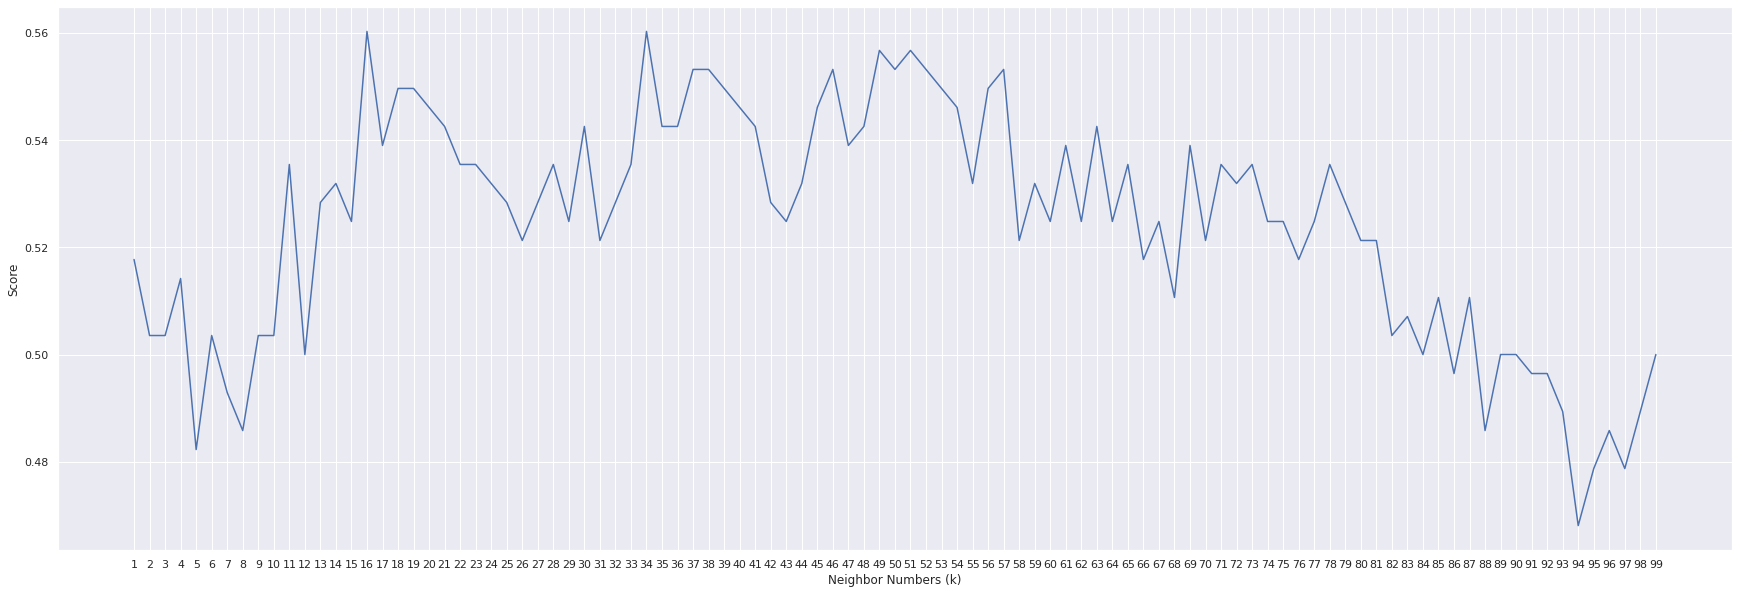

In [279]:
plt.figure(figsize=(30, 10))
plt.xticks(number_of_neighbors)

plt.xlabel('Neighbor Numbers (k)')
plt.ylabel('Score')

_ = plt.plot(number_of_neighbors, knn_neighbors_scores)
# plt.ylim(kmeans_clusters_scores[0], 1)
plt.show()

In [281]:
N_NEIGHBORS = 16 #@param{type:'integer'}

#### Normal

In [282]:
knearest_neighbors = KNeighborsClassifier(
  n_neighbors=N_NEIGHBORS,
)
knearest_neighbors.fit(X_transform, y_train)
y_pred_knearest_neighbors = knearest_neighbors.predict(X_test_transform)

knearest_neighbors_score = knearest_neighbors.score(X_test_transform, y_test)
display_score(knearest_neighbors_score)

score 56.03%


#### Decomposed with PCA

In [283]:
knearest_neighbors_pca = KNeighborsClassifier(
  n_neighbors=N_NEIGHBORS,
)
knearest_neighbors_pca.fit(X_train_pca, y_train)
y_pred_knearest_neighbors_pca = knearest_neighbors_pca.predict(X_test_pca)

knearest_neighbors_pca_score = knearest_neighbors_pca.score(X_test_pca, y_test)
display_score(knearest_neighbors_pca_score)

score 54.96%


#### Decomposed with ICA

In [284]:
knearest_neighbors_ica = KNeighborsClassifier(
  n_neighbors=N_NEIGHBORS,
)
knearest_neighbors_ica.fit(X_train_ica, y_train)
y_pred_knearest_neighbors_ica = knearest_neighbors_ica.predict(X_test_ica)

knearest_neighbors_ica_score = knearest_neighbors_ica.score(X_test_ica, y_test)
display_score(knearest_neighbors_ica_score)

score 48.23%


#### Confusion Matrix

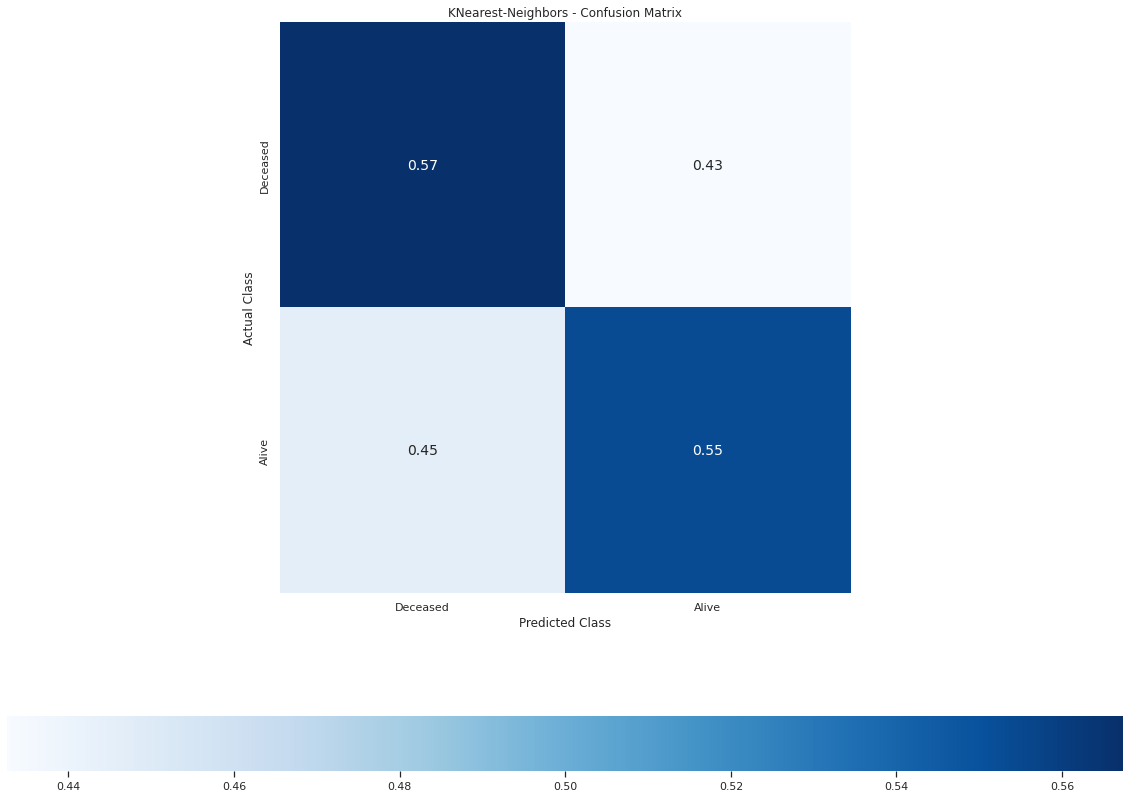

              precision    recall  f1-score   support

    Deceased       0.56      0.57      0.56       141
       Alive       0.56      0.55      0.56       141

    accuracy                           0.56       282
   macro avg       0.56      0.56      0.56       282
weighted avg       0.56      0.56      0.56       282



In [286]:
if PLOT_PROGRESS:
  knearest_neighbors_cmatrix = cmatrix(y_test, y_pred_knearest_neighbors, title='KNearest-Neighbors')

### Linear SVC

Support Vector Machine Classifier with a Linear solver, perfect for smaller datasets as it is more detailed but slower on larger datasets.

SVM models work by creating hyperplanes that transform complex problems into simpler ones that could be solved easily.

In [187]:
from sklearn.svm import LinearSVC
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#### Normal

In [188]:
# clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
linear_svc = LinearSVC(random_state=RANDOM_SEED, tol=1e-5)
linear_svc.fit(X_transform, y_train)
y_pred_svc_lineal = linear_svc.predict(X_test_transform)

svc_lineal_score = linear_svc.score(X_test_transform, y_test)
display_score(svc_lineal_score)

score 56.03%


Informe de clasificación

In [189]:
lineal_svc_report = classification_report(y_test, y_pred_svc_lineal, target_names=['Deceased', 'Alive'])
print(lineal_svc_report)

             precision    recall  f1-score   support

    Deceased      0.56      0.55      0.56       141
       Alive      0.56      0.57      0.56       141

    accuracy                          0.56       282
   macro avg      0.56      0.56      0.56       282
weighted avg      0.56      0.56      0.56       282



#### Decomposed with PCA

In [190]:
linear_svc_pca = LinearSVC(random_state=RANDOM_SEED, tol=1e-5, max_iter=25_000)
linear_svc_pca.fit(X_train_pca_bigger, y_train)
y_pred_linear_svc_pca = linear_svc_pca.predict(X_test_pca_bigger)

svc_lineal_pca_score = linear_svc_pca.score(X_test_pca_bigger, y_test)
display_score(svc_lineal_pca_score)

score 56.03%


#### Decomposed with ICA

In [191]:
linear_svc_ica = LinearSVC(random_state=RANDOM_SEED, tol=1e-5)
linear_svc_ica.fit(X_train_ica, y_train)
y_pred_linear_svc_ica = linear_svc_ica.predict(X_test_ica)

svc_lineal_ica_score = linear_svc_ica.score(X_test_ica, y_test)
display_score(svc_lineal_ica_score)

score 54.96%


#### Confusion Matrix

In [192]:
if PLOT_PROGRESS:
  svc_lineal_cmatrix = cmatrix(y_test, y_pred_svc_lineal, title='Linear SVC')

              precision    recall  f1-score   support

    Deceased       0.56      0.55      0.56       141
       Alive       0.56      0.57      0.56       141

    accuracy                           0.56       282
   macro avg       0.56      0.56      0.56       282
weighted avg       0.56      0.56      0.56       282



### Naive Bayes

Naive Bayes uses Bayes' probability theorem to solve the problem. It can get a really good score, balanced even, but it's also a faster to compute than a lot of other models, such as Support Vector Machine.

In [193]:
from sklearn.naive_bayes import GaussianNB
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

#### Normal

In [194]:
naive_bayes = GaussianNB(var_smoothing=.3)
naive_bayes.fit(X_transform, y_train)
y_pred_naive_bayes = naive_bayes.predict(X_test_transform)

naive_bayes_score = naive_bayes.score(X_test, y_test)
display_score(naive_bayes_score)

score 51.42%


#### Decomposed with PCA

In [195]:
naive_bayes_pca = GaussianNB(var_smoothing=.3)
naive_bayes_pca.fit(X_train_pca_bigger, y_train)
y_pred_naive_bayes_pca = naive_bayes_pca.predict(X_test_pca_bigger)

naive_bayes_pca_score = naive_bayes_pca.score(X_test_pca_bigger, y_test)
display_score(naive_bayes_pca_score)

score 51.06%


#### Decomposed with ICA

In [196]:
naive_bayes_ica = GaussianNB(var_smoothing=.3)
naive_bayes_ica.fit(X_train_ica, y_train)
y_pred_naive_bayes_ica = naive_bayes_ica.predict(X_test_ica)

naive_bayes_ica_score = naive_bayes_ica.score(X_test_ica, y_test)
display_score(naive_bayes_ica_score)

score 51.06%


#### Confusion Matrix

In [197]:
if PLOT_PROGRESS:
  naive_bayes_cmatrix = cmatrix(y_test, y_pred_naive_bayes, title='Naive Bayes')

              precision    recall  f1-score   support

    Deceased       0.51      0.52      0.52       141
       Alive       0.51      0.51      0.51       141

    accuracy                           0.51       282
   macro avg       0.51      0.51      0.51       282
weighted avg       0.51      0.51      0.51       282



### Decision Trees

Decision Trees are branches of if/else that attempt to find, to a given depth, a resolution that can solve the given problem. It may be heavy on the computing side, but it's a powerful and explainatory resolution.

There's usually a `max_depth` limit from wich the model makes little to no progress, in this case, that magic number turned out to be 5

In [198]:
from sklearn.tree import DecisionTreeClassifier
# https://scikit-learn.org/stable/modules/tree.html
from sklearn.tree import export_text

#### Normal

In [199]:
max_depth = 5

In [200]:
decision_tree = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=max_depth)
decision_tree.fit(X_transform, y_train)
r = export_text(decision_tree, feature_names=list(X.columns))
y_pred = decision_tree.predict(X_test_transform)

decision_tree_score = decision_tree.score(X_test_transform, y_test)
display_score(decision_tree_score)

decision_tree_og = decision_tree

score 53.9%


#### Decomposed with PCA

In [201]:
decision_tree_pca = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=max_depth)
decision_tree_pca.fit(X_train_pca_bigger, y_train)
y_pred_decision_tree_pca = decision_tree_pca.predict(X_test_pca_bigger)

decision_tree_pca_score = decision_tree_pca.score(X_test_pca_bigger, y_test)
display_score(decision_tree_pca_score)

score 52.13%


#### Decomposed with ICA

In [202]:
decision_tree_ica = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=max_depth)
decision_tree_ica.fit(X_train_ica, y_train)
y_pred_decision_tree_ica = decision_tree_ica.predict(X_test_ica)

decision_tree_ica_score = decision_tree_ica.score(X_test_ica, y_test)
display_score(decision_tree_ica_score)

score 53.55%


#### Confusion Matrix

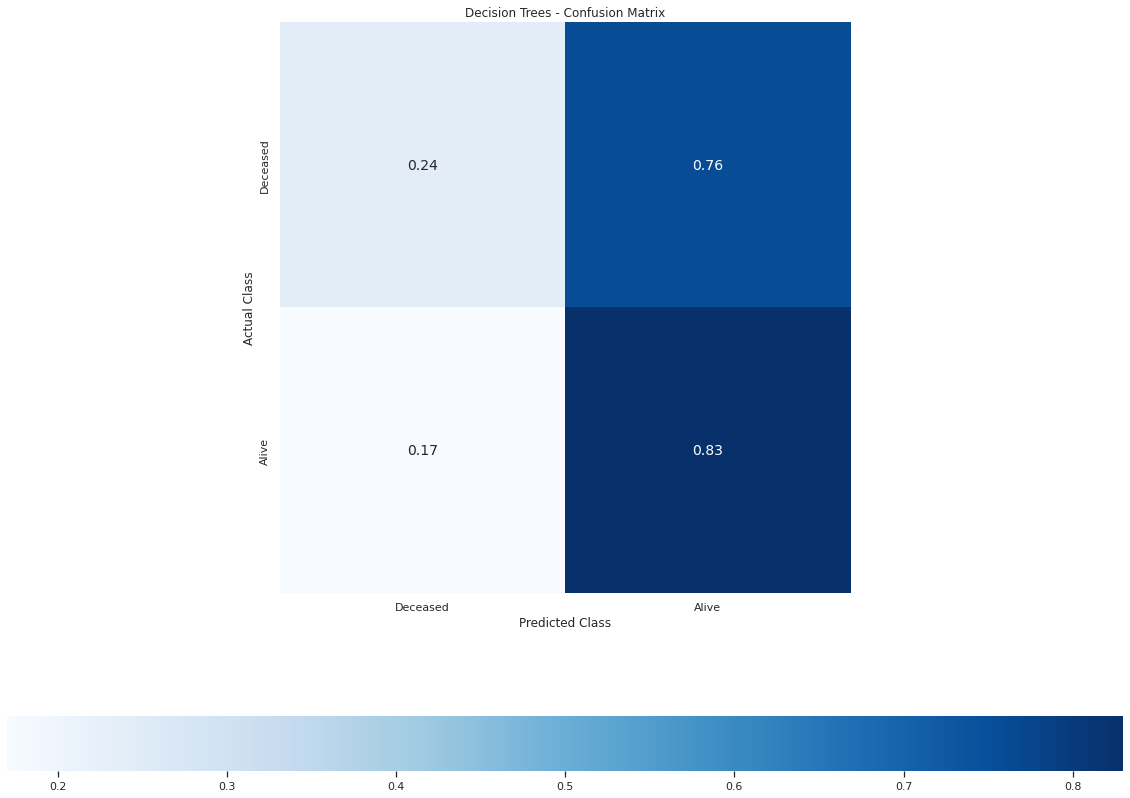

              precision    recall  f1-score   support

    Deceased       0.59      0.24      0.34       141
       Alive       0.52      0.83      0.64       141

    accuracy                           0.54       282
   macro avg       0.55      0.54      0.49       282
weighted avg       0.55      0.54      0.49       282



In [203]:
if PLOT_PROGRESS:
  decision_tree_cmatrix = cmatrix(y_test, y_pred_decision_tree_ica, title='Decision Trees')

#### Visual representation of the Decision Tree

A Decision Tree is jus a branch of "if/else" that can help us explain our model

In [204]:
if PLOT_PROGRESS:
  print(r)

|--- popularity <= 0.56
|   |--- spouse <= 0.69
|   |   |--- popularity <= 0.29
|   |   |   |--- popularity <= 0.12
|   |   |   |   |--- book3 <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- book3 >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- popularity >  0.12
|   |   |   |   |--- age <= 0.07
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age >  0.07
|   |   |   |   |   |--- class: 1
|   |   |--- popularity >  0.29
|   |   |   |--- book5 <= 0.50
|   |   |   |   |--- popularity <= 0.36
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- popularity >  0.36
|   |   |   |   |   |--- class: 0
|   |   |   |--- book5 >  0.50
|   |   |   |   |--- house <= 0.01
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- house >  0.01
|   |   |   |   |   |--- class: 0
|   |--- spouse >  0.69
|   |   |--- class: 0
|--- popularity >  0.56
|   |--- house <= 0.00
|   |   |--- class: 0
|   |--- house >  0.00
|   |   |--- age <= 0.23
|   |   |   |--- popularity <= 0.

In [205]:
if PLOT_PROGRESS:
  from sklearn import tree
  _ = tree.plot_tree(
    decision_tree,
    max_depth=2,
    feature_names=X_train.columns
  )

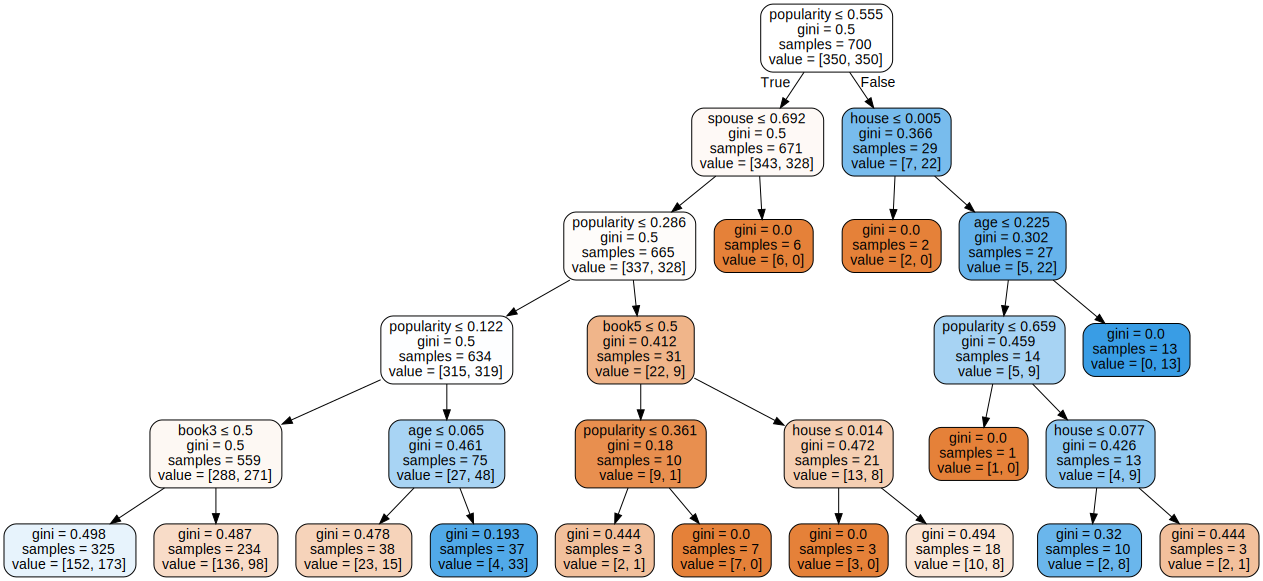

In [206]:
if PLOT_PROGRESS:
  import graphviz 

  # Solo se puede ejecutar con el resultado de los datos sin modificar, es decir, sin PCA ni ICA
  dot_data = tree.export_graphviz(
    decision_tree_og,
    out_file=None,
    feature_names=list(X.columns),
    filled=True,
    rounded=True,
    special_characters=True
  )
  graph = graphviz.Source(dot_data) 
  display(graph)

### Random Forest

In [207]:
from sklearn.ensemble import RandomForestClassifier

In [208]:
random_forest_classifier_configuration = {
  'random_state': RANDOM_SEED,
  'max_depth': 5,
  'n_estimators': 10,
  'n_jobs': -1,
}

#### Normal

In [209]:
random_forest_classifier = RandomForestClassifier(
  **random_forest_classifier_configuration
)
random_forest_classifier.fit(X_transform, y_train)
random_forest_classifier_score = random_forest_classifier.score(X_test_transform, y_test)
y_pred_random_forest_classifier = random_forest_classifier.predict(X_test_transform)

display_score(random_forest_classifier_score)

score 54.61%


#### Decomposed with PCA

In [210]:
random_forest_classifier_pca = RandomForestClassifier(
  **random_forest_classifier_configuration
)
random_forest_classifier_pca = random_forest_classifier_pca.fit(
  X_train_pca_bigger,
  y_train
)
y_pred = random_forest_classifier_pca.predict(
  X_test_pca_bigger
)
random_forest_classifier_pca_score = random_forest_classifier_pca.score(
  X_test_pca_bigger,
  y_test
)
y_pred_random_forest_classifier_pca = random_forest_classifier_pca.predict(
  X_test_pca_bigger
)
preds_random_forest_classifier_pca = random_forest_classifier_pca.predict_proba(X_test_pca_bigger)

display_score(random_forest_classifier_pca_score)

score 48.94%


#### Decomposed with ICA

In [211]:
random_forest_classifier_ica = RandomForestClassifier(
  **random_forest_classifier_configuration
)
random_forest_classifier_ica = random_forest_classifier_ica.fit(
  X_train_ica,
  y_train
)
y_pred = random_forest_classifier_ica.predict(
  X_test_ica
)
random_forest_classifier_ica_score = random_forest_classifier_ica.score(
  X_test_ica,
  y_test
)

display_score(random_forest_classifier_ica_score)

score 50.71%


#### Confusion Matrix

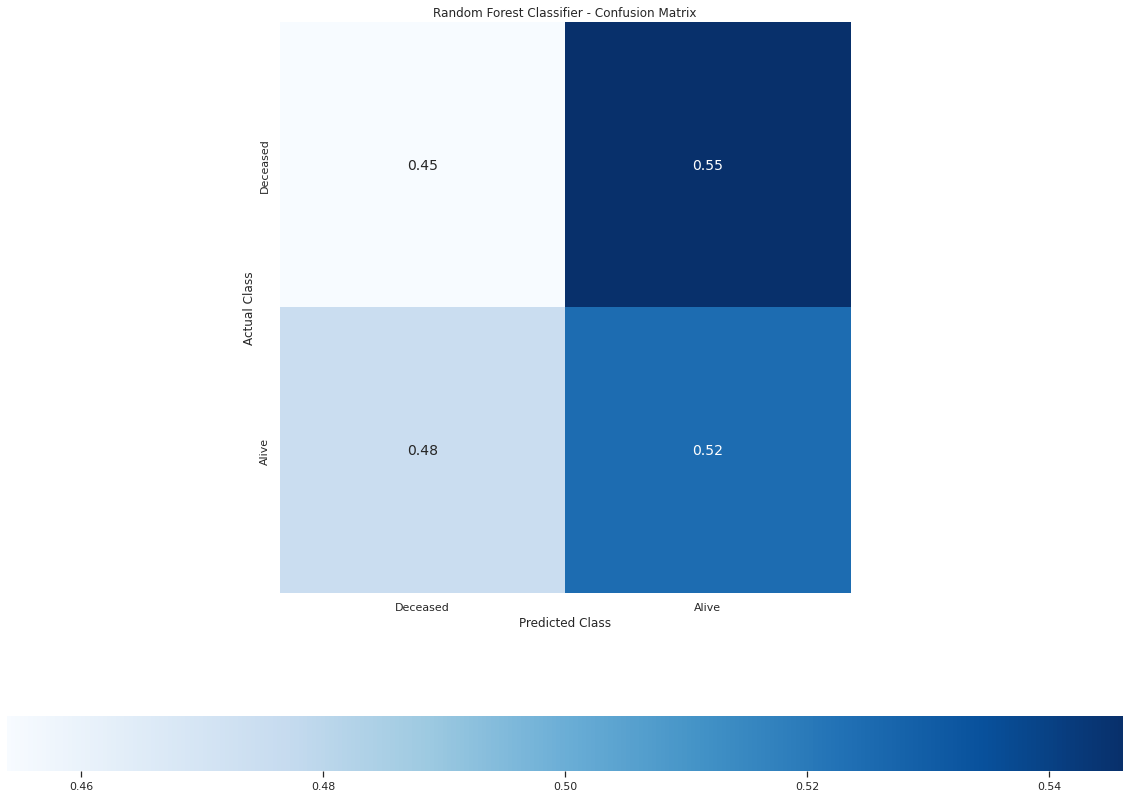

              precision    recall  f1-score   support

    Deceased       0.49      0.45      0.47       141
       Alive       0.49      0.52      0.51       141

    accuracy                           0.49       282
   macro avg       0.49      0.49      0.49       282
weighted avg       0.49      0.49      0.49       282



In [212]:
if PLOT_PROGRESS:
  random_forest_cmatrix = cmatrix(y_test, y_pred_random_forest_classifier_pca, title='Random Forest Classifier')
  # random_forest_cmatrix = make_cm(preds_random_forest_classifier_pca, "Random Forest Classifier")

#### Feature importance

Random forest let's us see the feature importance of each attribute, we don't get the explanation, just the result, but it can be a great insight

In [213]:
if PLOT_PROGRESS:
  feature_importances = list(zip(
    random_forest_classifier.feature_names_in_,
    random_forest_classifier.feature_importances_,
  ))
  feature_importances_df = pd.DataFrame(feature_importances, columns=['feature_name', 'importance'])
  feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
  feature_importances_df

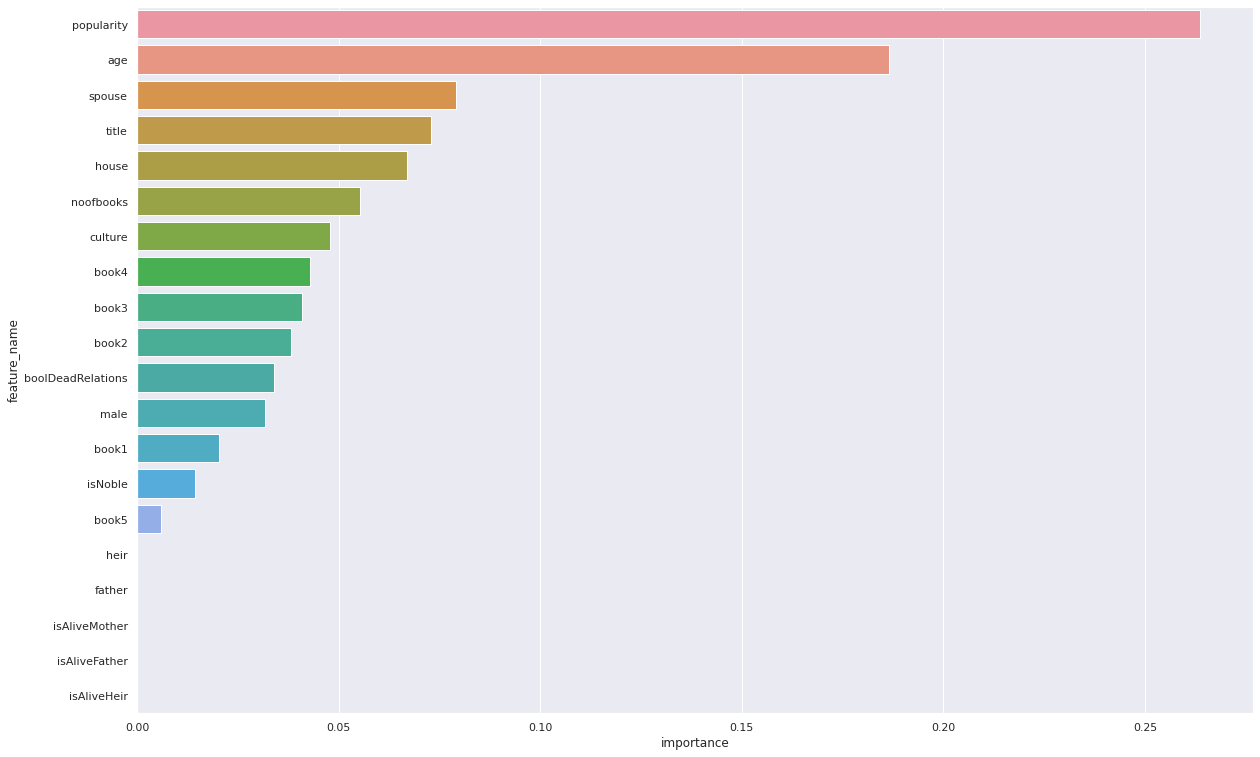

In [214]:
if PLOT_PROGRESS:
  # top_n_features = 25
  # top_n_features = 50
  top_n_features = 20
  vertical_units_per_feature = .65

  plt.figure(figsize=(20, top_n_features * vertical_units_per_feature))
  temp_features_df = feature_importances_df[:top_n_features]
  _ = sns.barplot(
    x=temp_features_df.importance,
    y=temp_features_df.feature_name,
  )

While tuning the model, having the `name` as a dictionary biased our model, so let's it's feature importance having it as a tokenized column

In [215]:
if PLOT_PROGRESS:
  feature_importances_df[ feature_importances_df['feature_name'] == 'name' ]

### Neural Networks and Deep Learning

A neural network are layers of neurons (units of input, computing, output) that use activation functions (sigmoid, linear, relu, softmax, etc.) and weights and biases to solve almost any sort of problem.

Deep Learning Classification examples from:

- https://towardsdatascience.com/classification-using-neural-networks-b8e98f3a904f
- https://www.tensorflow.org/tutorials/keras/classification?hl=es-419

#### Imports

In [216]:
import keras
from keras import layers
import tensorflow as tf
tf.random.set_seed(RANDOM_SEED)
# Import required libraries
# import pandas as pd
import matplotlib.pyplot as plt
import sklearn
# Import necessary modules
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from multiprocessing import cpu_count 

From the following example: https://www.pluralsight.com/guides/classification-keras

Some of the modifications applied were:

- Verbose is set to a value of `0` so that it does not show the iterations of the training.
- Multiprocessing is set to the cpu count minus one, while running on Google Colab that number will be one, but in a more powerfull machine, that number will boost, and so will the training speed.
- According to `KerasClassifier` the best model uses 50 `epochs` (number of iterations) and 80 `batch_size` (number of elements to process per batch)

In [217]:
keras_X_train = X_transform
keras_X_test = X_test_transform

keras_y_train = y_train
keras_y_test = y_test
# keras_y_train = to_categorical(keras_y_train)
# keras_y_test = to_categorical(keras_y_test)

# dim = len(list(X_test.columns))
dim = keras_X_train.shape[1]

#### Architecture

Builds the model with a simple architecture


```python
Input layer: FEATURES,
First hidden layer: FEATURES / 2,
Second hidden layer: FEATURES / 4,
Output layer: 2,
```

Using regularizers as to asure a good performance on the training set and to avoid overfitting on our model

In [218]:
def build_deep_learning_model(
  n_features: int = dim
):
  model = Sequential(
    name='Deep-Learning-Model',
    layers=[
      # Input Layer
      Dense(
        name='Input-Layer',
        units=n_features,
        activation='relu',
        input_dim=n_features,
        # kernel_regularizer='l1',
      ),
      # First Hidden Layer
#       Dense(
#         name='First-Hidden-Layer',
#         units=int(n_features / 2),
#         activation='relu',
#         # kernel_regularizer='l2',
#       ),
#       # Second Hidden Layer
#       Dense(
#         name='Second-Hidden-Layer',
#         units=int(n_features / 4),
#         activation='relu',
#         # kernel_regularizer='l2',
#       ),
      # Second Hidden Layer
      Dense(
        name='Second-Hidden-Layer',
        units=64,
        activation='relu',
      ),
      # Output Layer
      Dense(
        name='Output-Layer',
        units=1,
        # units=2,
        activation='sigmoid',
        # activation='softmax',
        # kernel_regularizer='l1',
      ),
    ]
  )

  # Compile the model
  model.compile(
    optimizer=tf.optimizers.Adam(
      learning_rate=0.005
    ),
    # optimizer='adam',
    loss=tf.keras.losses.binary_crossentropy,
    # loss=tf.keras.losses.categorical_crossentropy,
    # loss='squared_hinge',
    metrics=[
      'accuracy',
      # 'MeanSquaredError',
    ]
  )

  model.summary()

  return model

The training function as to have an standarized fitting in all of our examples

In [219]:
def fit_model(
  model,
  train_values: pd.DataFrame,
  test_values: pd.DataFrame,
  epochs: int = 50,
  batch_size: int = 80,
  validation_split: float = .2,
  verbose: int = 1,
  shuffle: bool = True
) -> tf.keras.callbacks.History:
  return model.fit(
    train_values,
    test_values,
    # epochs=25,
    epochs=50,
    # batch_size=128,
    batch_size=80,
    use_multiprocessing=True,
    workers=workers,
    validation_split=.2,
    callbacks=[
      tf.keras.callbacks.EarlyStopping(
        patience=2,
        monitor='val_accuracy'
      ),
    ],
    shuffle=shuffle,
    verbose=verbose
  )

The evaluation method

In [220]:
def evaluate_model(
  model,
  X_evaluation,
  y_evaluation,
  verbose: int = 1
) -> Tuple[float]:
  return model.evaluate(
    X_evaluation,
    y_evaluation,
    verbose=verbose,
    use_multiprocessing=True,
    workers=workers
  )

#### Training

After establishing our model architecture, we train it with the data

In [221]:
deep_learning_model = build_deep_learning_model(
  n_features=keras_X_train.shape[1]
)

# workers = 10
workers = cpu_count() - 1

history = fit_model(deep_learning_model, keras_X_train, keras_y_train, validation_split=.33)
y_pred_deep_learning = deep_learning_model.predict(keras_X_test)

deep_learning_train_evaluation = evaluate_model(deep_learning_model, keras_X_train, keras_y_train)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(deep_learning_train_evaluation[1], 1 - deep_learning_train_evaluation[1]))   

deep_learning_test_evaluation = evaluate_model(deep_learning_model, keras_X_test, keras_y_test)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(deep_learning_test_evaluation[1], 1 - deep_learning_test_evaluation[1]))   

deep_learning_score = deep_learning_test_evaluation[1]
display_score(deep_learning_score)

Model: "Deep-Learning-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 21)                462       
                                                                 
 Second-Hidden-Layer (Dense)  (None, 64)               1408      
                                                                 
 Output-Layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 1,935
Trainable params: 1,935
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 1s 41ms/step - loss: 0.6975 - accuracy: 0.4732 - val_loss: 0.6961 - val_accuracy: 0.4286
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.6895 - accuracy: 0.5214 - val_loss: 0.6919 - val_accuracy: 0.4857
Epoch 3/50
7/7 [===============

In [222]:
deep_learning_test_evaluation[1] + (1 - deep_learning_test_evaluation[1])

1.0

In [223]:
# No funciona por ser multioutput (el to_categorical)
# cmatrix(keras_y_test, pred_test)

In [224]:
# history.history

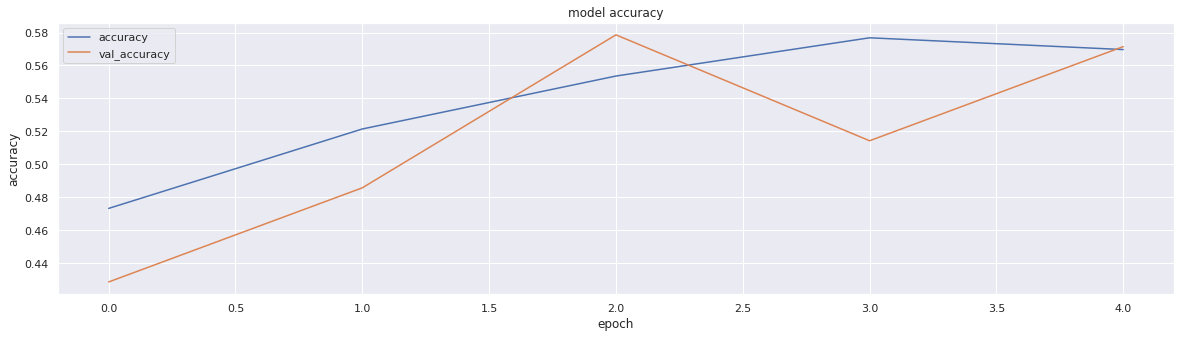

In [225]:
if PLOT_PROGRESS:
  plt.figure(figsize=(20, 5))
  plt.plot(pd.DataFrame(history.history)[ ['accuracy', 'val_accuracy'] ])
  # plt.plot(history.history['mean_squared_error'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  # plt.legend(['accuracy', 'mean_squared_error'], loc='upper left')
  plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
  plt.show()

#### Decomposed with PCA

In [226]:
deep_learning_pca_model = build_deep_learning_model(
  n_features=X_train_pca.shape[1]
)

deep_learning_pca_history = fit_model(deep_learning_pca_model, X_train_pca, keras_y_train)
y_pred_deep_learning_pca = deep_learning_pca_model.predict(X_test_pca)

deep_learning_pca_evaluation = evaluate_model(deep_learning_pca_model, X_test_pca, keras_y_test)
_, deep_learning_pca_score = deep_learning_pca_evaluation
display_score(deep_learning_pca_score)

Model: "Deep-Learning-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 5)                 30        
                                                                 
 Second-Hidden-Layer (Dense)  (None, 64)               384       
                                                                 
 Output-Layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 479
Trainable params: 479
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 1s 33ms/step - loss: 0.6965 - accuracy: 0.4804 - val_loss: 0.6937 - val_accuracy: 0.4929
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5357 - val_loss: 0.6941 - val_accuracy: 0.4571
Epoch 3/50
9/9 [====================

#### Decomposed with ICA

In [227]:
X_train_ica.shape, X_test_ica.shape, 

((700, 10), (282, 10))

In [228]:
deep_learning_ica_model = build_deep_learning_model(
  n_features=X_test_ica.shape[1]
)

deep_learning_ica_history = fit_model(deep_learning_ica_model, X_train_ica, keras_y_train)
y_pred_deep_learning_ica = deep_learning_ica_model.predict(X_test_ica)

deep_learning_ica_evaluation = evaluate_model(deep_learning_ica_model, X_test_ica, keras_y_test)
_, deep_learning_ica_score = deep_learning_ica_evaluation
display_score(deep_learning_ica_score)

Model: "Deep-Learning-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 10)                110       
                                                                 
 Second-Hidden-Layer (Dense)  (None, 64)               704       
                                                                 
 Output-Layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 879
Trainable params: 879
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 1s 31ms/step - loss: 0.6938 - accuracy: 0.4750 - val_loss: 0.6943 - val_accuracy: 0.4714
Epoch 2/50
7/7 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5036 - val_loss: 0.6941 - val_accuracy: 0.4929
Epoch 3/50
7/7 [====================

#### Confusion Matrix

In [229]:
if PLOT_PROGRESS:
  # keras_y_test_mapped = list(map(lambda x: np.argmax(x), keras_y_test))
  keras_y_test_mapped = keras_y_test
  # keras_y_pred_mapped = list(map(lambda x: np.argmax(x), y_pred_deep_learning_pca))
  keras_y_pred_mapped = list(map(lambda x: np.argmax(x), y_pred_deep_learning))
  deep_learning_cmatrix = cmatrix(keras_y_test_mapped, keras_y_pred_mapped, title='Deep Learning Neural Network')

              precision    recall  f1-score   support

    Deceased       0.50      1.00      0.67       141
       Alive       0.00      0.00      0.00       141

    accuracy                           0.50       282
   macro avg       0.25      0.50      0.33       282
weighted avg       0.25      0.50      0.33       282



#### Best estimators

For tuning, we can try multiple parameters, all at once, to try and find the best, this is really heaving on the computing, and in huuuuge, really large datasets, it's something that may take days, or even weeks, given that we're working with a really small dataset (1946 rows at most), we can do this no problem, but it does take a couple of minutes still.

Evaluates the most optimap hpyer-parameters, as per reference:

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [230]:
GET_BEST_ESTIMATORS = False #@param {type:'boolean'}

In [ ]:
# This cell will take up a lot of prcessing time, evaluate at your own risk

def get_best_estimators():
  from sklearn.model_selection import GridSearchCV
  from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
  import multiprocessing

  parameters = {'epochs':[1, 5, 10, 15, 20, 25, 50]}

  def create_model():
    # create model
    model = Sequential([
      Dense(
        units=dim,
        activation='relu',
        input_dim=dim,
        kernel_regularizer='l2',
      ),
      Dense(
        units=int(dim / 2),
        activation='relu',
        kernel_regularizer='l2',
      ),
      Dense(
        units=int(dim / 4),
        activation='relu',
        kernel_regularizer='l2',
      ),
      Dense(
        units=2,
        activation='sigmoid',
        kernel_regularizer='l2',
      ),
    ])

    # Compile model
    model.compile(optimizer='adam', loss=tf.keras.losses.squared_hinge, metrics=['accuracy',])
    return model

  # create model
  model = KerasClassifier(build_fn=create_model, verbose=0)
  # define the grid search parameters
  batch_size = [10, 20, 40, 60, 80, 100]
  # epochs = [1, 5, 10, 15, 20, 25, 50]
  epochs = [10, 50, 100]
  # workers = [5, 10, 15, 20, 25, 50]
  param_grid = dict(batch_size=batch_size, epochs=epochs)
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-multiprocessing.cpu_count() - 1, cv=3)
  grid_result = grid.fit(keras_X_train, keras_y_train)

  # summarize results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

  return grid_result

if GET_BEST_ESTIMATORS:
  grid_result = get_best_estimators()

Plot the results

In [232]:
if GET_BEST_ESTIMATORS:
  results = pd.DataFrame(grid_result.cv_results_)

In [233]:
if GET_BEST_ESTIMATORS:
  plt.figure(figsize=(20,10))
  grid_result_cols_to_hide = [
    'params'
  ]
  grid_result_cols = [ col for col in results.columns if col not in grid_result_cols_to_hide ]
  results[ grid_result_cols ].plot(figsize=(20,10))
  plt.show()

Con ayuda de:



In [234]:
if GET_BEST_ESTIMATORS:
  grid_result.best_params_

### Single-Shot

A singleshot model is a deep learning, neural network, that tries to solve the problem without hidden layers, just the input and output layers, as soon as it's inputted is outputted


```
Input Layer: FEATURES
Output Layer: 2
```

It's really powerful given how little computing power it requires

#### Architecture

In [235]:
def build_single_shot_model(n_features: int):
  model = Sequential(
    name='Single-Shot-Deep-Learning-Model',
    layers=[
      Dense(
        name='Input-Layer',
        units=1,
        activation='relu',
        input_dim=n_features,
      ),
      Dense(
        name='Output-Layer',
        units=1,
        # units=2,
        activation='sigmoid',
        # activation='softmax',
      ),
    ]
  )

  model.compile(
    optimizer=tf.optimizers.Adam(
      learning_rate=0.00001,
    ),
    loss='binary_crossentropy',
    metrics=['accuracy'],
  )

  model.summary()

  return model

#### Normal

In [236]:
single_shot_model = build_single_shot_model(
  n_features=keras_X_train.shape[1]
)
single_shot_history = fit_model(single_shot_model, keras_X_train, keras_y_train, validation_split=.33)
y_pred_single_shot = single_shot_model.predict(keras_X_test)

single_shot_loss, single_shot_score = single_shot_model.evaluate(
  keras_X_test,
  keras_y_test,
  use_multiprocessing=True,
  workers=workers
)
# print(f'Single-Shot performed with an accuracy of {round(single_shot_score * 100, 2)}%')

display_score(single_shot_score)

Model: "Single-Shot-Deep-Learning-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 1)                 22        
                                                                 
 Output-Layer (Dense)        (None, 1)                 2         
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 1s 36ms/step - loss: 0.6929 - accuracy: 0.4982 - val_loss: 0.6888 - val_accuracy: 0.5643
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6888 - val_accuracy: 0.5643
Epoch 3/50
9/9 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5071
score 50.71%


It's evolution progress

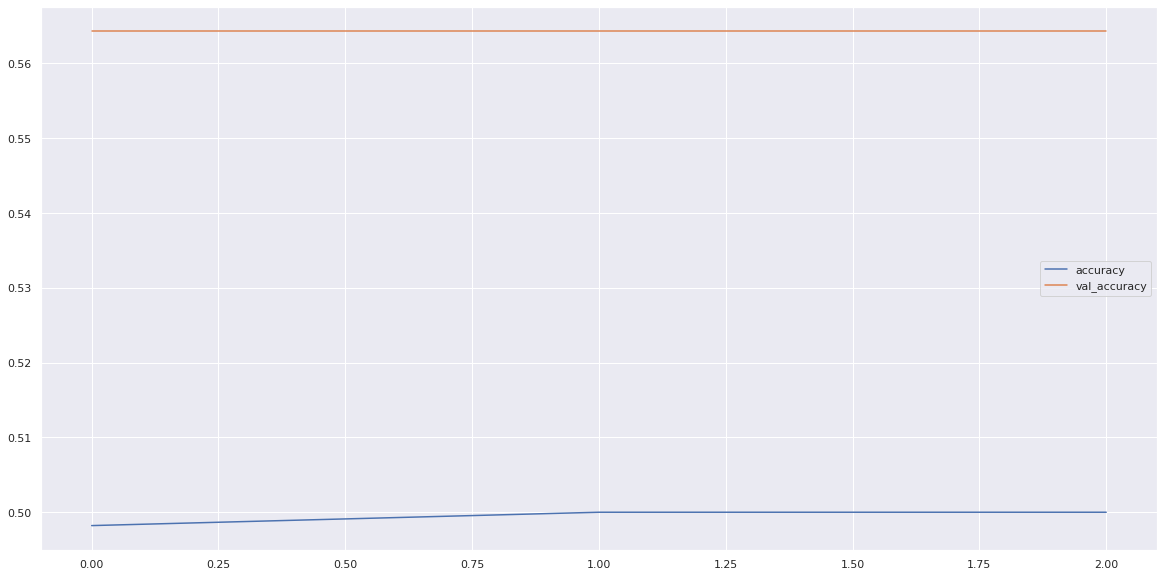

In [237]:
if PLOT_PROGRESS:
  _ = pd.DataFrame(single_shot_history.history)[
    ['accuracy', 'val_accuracy']
  ].plot(figsize=(20, 10))

#### Decomposed with PCA

In [238]:
single_shot_model_pca = build_single_shot_model(
  X_train_pca.shape[1]
)
single_shot_history = fit_model(single_shot_model_pca, X_train_pca, keras_y_train, validation_split=.3)
y_pred_single_shot_pca = single_shot_model_pca.predict(X_test_pca)

single_shot_loss_pca, single_shot_score_pca = single_shot_model_pca.evaluate(
  X_test_pca,
  keras_y_test,
  use_multiprocessing=True,
  workers=workers
)

display_score(single_shot_score_pca)

Model: "Single-Shot-Deep-Learning-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 1)                 6         
                                                                 
 Output-Layer (Dense)        (None, 1)                 2         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 1s 37ms/step - loss: 0.7618 - accuracy: 0.4821 - val_loss: 0.7268 - val_accuracy: 0.5214
Epoch 2/50
7/7 [==============================] - 0s 8ms/step - loss: 0.7618 - accuracy: 0.4893 - val_loss: 0.7268 - val_accuracy: 0.5214
Epoch 3/50
9/9 [==============================] - 0s 2ms/step - loss: 0.7654 - accuracy: 0.4894
score 48.94%


#### Decomposed with ICA

In [239]:
single_shot_model_ica = build_single_shot_model(
  X_train_ica.shape[1]
)
single_shot_history = fit_model(single_shot_model_ica, X_train_ica, keras_y_train, validation_split=.3)
y_pred_single_shot_ica = single_shot_model_ica.predict(X_test_ica)

single_shot_loss_ica, single_shot_score_ica = single_shot_model_ica.evaluate(
  X_test_ica,
  keras_y_test,
  use_multiprocessing=True,
  workers=workers
)

display_score(single_shot_score_ica)

Model: "Single-Shot-Deep-Learning-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 1)                 11        
                                                                 
 Output-Layer (Dense)        (None, 1)                 2         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 1s 34ms/step - loss: 0.6937 - accuracy: 0.4982 - val_loss: 0.6930 - val_accuracy: 0.5143
Epoch 2/50
7/7 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.4625 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/50
9/9 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5461
score 54.61%


#### Confusion Matrix

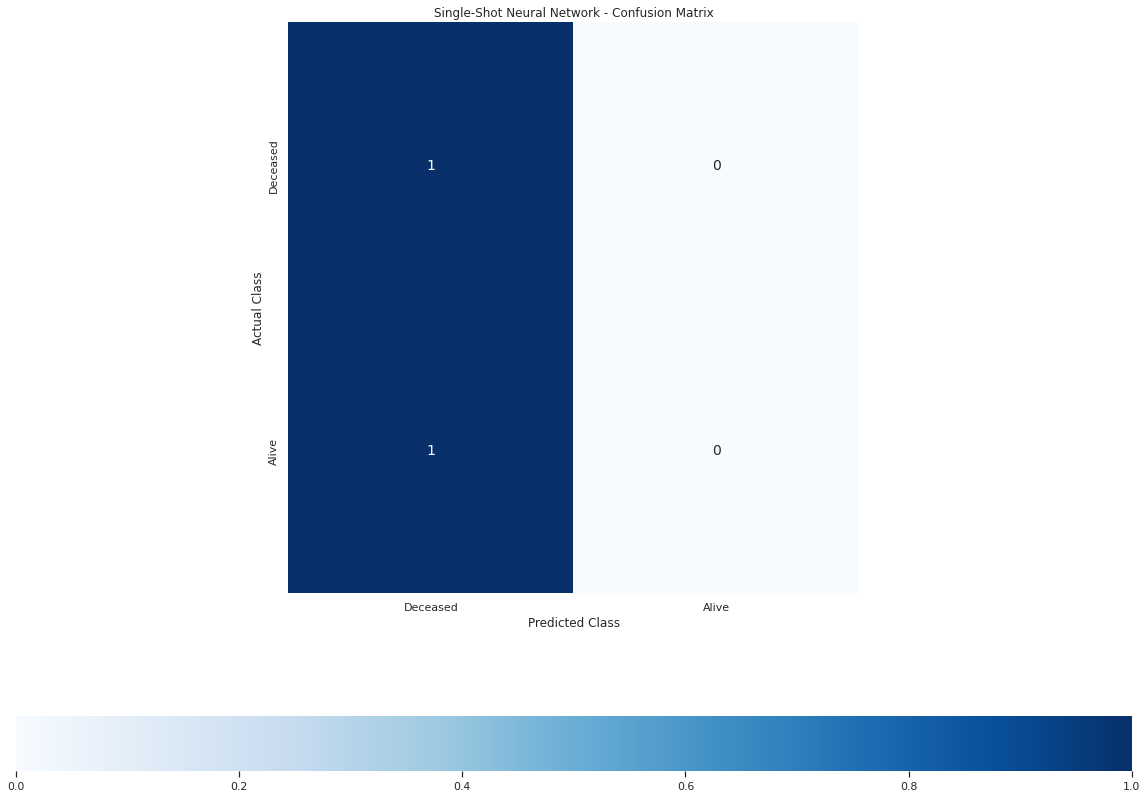

              precision    recall  f1-score   support

    Deceased       0.50      1.00      0.67       141
       Alive       0.00      0.00      0.00       141

    accuracy                           0.50       282
   macro avg       0.25      0.50      0.33       282
weighted avg       0.25      0.50      0.33       282



In [240]:
if PLOT_PROGRESS:
  # keras_y_test_mapped = list(map(lambda x: np.argmax(x), keras_y_test))
  keras_y_test_mapped = keras_y_test
  keras_y_pred_mapped = list(map(lambda x: np.argmax(x), y_pred_single_shot))
  single_shot_cmatrix = cmatrix(keras_y_test_mapped, keras_y_pred_mapped, title='Single-Shot Neural Network')

### XGBoost Classifier

Gradient Boosted Classifier is a powerfull technique that uses Lasso and Ridge regularization techniques to penalyze complex models. It is efficient, flexible and portable

In [241]:
from xgboost import XGBClassifier

#### Normal

In [242]:
xgboost_classifier = XGBClassifier(
  subsample=.2,
  colsample_bytree=.9,
  seed=RANDOM_SEED,
  max_depth=3,
)
xgboost_classifier.fit(X_transform, y_train)
y_pred_xgboost_classifier = xgboost_classifier.predict(X_test_transform)
preds_xgboost_classifier = xgboost_classifier.predict_proba(X_test_transform)

xgboost_classifier_score = xgboost_classifier.score(X_test_transform, y_test)
display_score(xgboost_classifier_score)

score 54.26%


#### Decomposed with PCA

In [243]:
xgboost_classifier_pca = XGBClassifier(
  subsample=.2,
  colsample_bytree=.9,
  seed=RANDOM_SEED,
  max_depth=3,
)
xgboost_classifier_pca.fit(X_train_pca_bigger, y_train)
y_pred_xgboost_classifier_pca = xgboost_classifier_pca.predict(X_test_pca_bigger)
preds_xgboost_classifier_pca = xgboost_classifier_pca.predict_proba(X_test_pca_bigger)

xgboost_classifier_pca_score = xgboost_classifier_pca.score(X_test_pca_bigger, y_test)
display_score(xgboost_classifier_pca_score)

score 58.16%


#### Decomposed with ICA

In [244]:
xgboost_classifier_ica = XGBClassifier(
  subsample=.3,
  colsample_bytree=.9,
  seed=RANDOM_SEED,
  max_depth=3,
)
xgboost_classifier_ica.fit(X_train_ica, y_train)
y_pred_xgboost_classifier_ica = xgboost_classifier_ica.predict(X_test_ica)
preds_xgboost_classifier_ica = xgboost_classifier_ica.predict_proba(X_test_ica)

xgboost_classifier_ica_score = xgboost_classifier_ica.score(X_test_ica, y_test)
display_score(xgboost_classifier_ica_score)

score 52.84%


#### Explainability

Straight from shaildeliwala's notebook

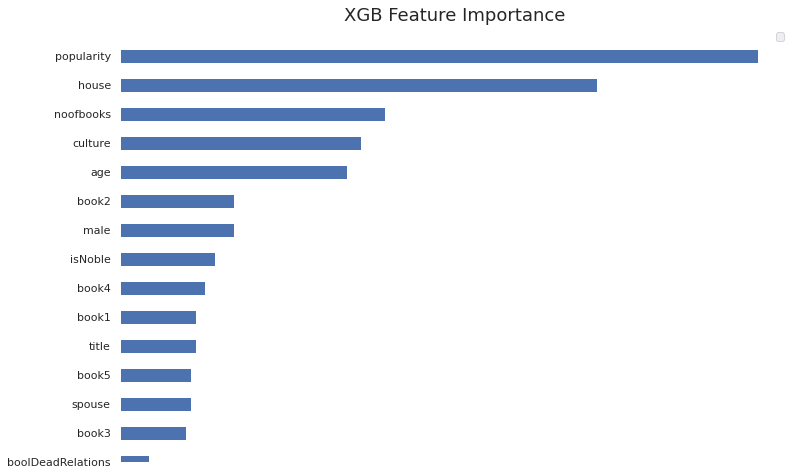

In [245]:
if PLOT_PROGRESS:
  ax = (
    pd.DataFrame(
      list(
        xgboost_classifier.get_booster().get_fscore().items()
      )
    )
    .set_index(0)
    .sort_values(1)
    .plot.barh(figsize=(12, 8))
  )
  _ = ax.set(
      frame_on = False,
      ylim = (0, len(xgboost_classifier.get_booster().get_fscore())),
      xticklabels = "",
      xlabel = "",
      ylabel = ""
    ),
  ax.legend("")
  _ = plt.title("XGB Feature Importance", fontsize = 18.)

#### Confusion Matrix

In [246]:
if PLOT_PROGRESS:
  xgboost_cmatrix = cmatrix(y_test, y_pred_xgboost_classifier_pca, title='XGB Classifier')
  # xgboost_cmatrix = make_cm(preds_xgboost_classifier, "XGB Classifier")

              precision    recall  f1-score   support

    Deceased       0.58      0.58      0.58       141
       Alive       0.58      0.58      0.58       141

    accuracy                           0.58       282
   macro avg       0.58      0.58      0.58       282
weighted avg       0.58      0.58      0.58       282



### Baseline

A baseline model would be cheating, but it is guaranteed to at least be close to a 50% score

#### Building the model

We create a dummy classifier class to fake the training

In [247]:
class BaselineClassifier():
  def __init__(self, labels: list):
    self.n_labels = len(labels)

  def fit(self, X_train, y_train) -> None:
    pass

  def predict(self, X_pred: pd.DataFrame) -> np.ndarray:
    y_pred = np.random.randint(self.n_labels, size=len(X_pred))
    return y_pred

  def score(self, X_pred, y_true) -> float:
    y_pred = self.predict(X_pred)
    return f1_score(y_true, y_pred, average='binary' if self.n_labels <= 2 else 'micro')

#### Normal

In [248]:
baseline = BaselineClassifier(
  labels=y_train.unique()
)
baseline.fit(X_transform, y_train)
y_pred_baseline = baseline.predict(X_test_transform)

baseline_score = baseline.score(X_test_transform, y_test)
display_score(baseline_score)

score 50.17%


#### Decomposed with PCA

In [249]:
baseline_pca = BaselineClassifier(
  labels=y_train.unique()
)
baseline_pca.fit(X_train_pca, y_train)
y_pred_baseline_pca = baseline_pca.predict(X_test_pca)

baseline_pca_score = baseline_pca.score(X_test_pca, y_test)
display_score(baseline_pca_score)

score 45.35%


#### Decomposed with ICA

In [250]:
baseline_ica = BaselineClassifier(
  labels=y_train.unique()
)
baseline_ica.fit(X_train_ica, y_train)
y_pred_baseline_ica = baseline_ica.predict(X_test_ica)

baseline_ica_score = baseline_ica.score(X_test_ica, y_test)
display_score(baseline_ica_score)

score 45.16%


#### Confusion Matrix

In [251]:
if PLOT_PROGRESS:
  baseline_cmatrix = cmatrix(y_test, y_pred_baseline, title='Baseline')

              precision    recall  f1-score   support

    Deceased       0.51      0.50      0.51       141
       Alive       0.51      0.52      0.51       141

    accuracy                           0.51       282
   macro avg       0.51      0.51      0.51       282
weighted avg       0.51      0.51      0.51       282



## Algorithm Comparison

Since one of the main goals of this project was to try out as many different classification algorithms as possible, we can compare their scores as their main metric, even though we'll touch upon that as we've concluded differently

Join all of the scores together

In [252]:
scores = [
  ['Logistic Regression',            logistic_regression_score,          'None', 'Supervised'   ],
  ['Logistic Regression',            logistic_regression_pca_score,      'PCA',  'Supervised'   ],
  ['Logistic Regression',            logistic_regression_ica_score,      'ICA',  'Supervised'   ],
  ['Polynomial Logistic Regression', poly_logistic_regression_score,     'None', 'Supervised'   ],
  ['Polynomial Logistic Regression', poly_logistic_regression_pca_score, 'PCA',  'Supervised'   ],
  ['Polynomial Logistic Regression', poly_logistic_regression_ica_score, 'ICA',  'Supervised'   ],
  ['Clustering K-Means',             kmeans_score,                       'None', 'Unsupervised' ],
  ['Clustering K-Means',             kmeans_pca_score,                   'PCA',  'Unsupervised' ],
  ['Clustering K-Means',             kmeans_ica_score,                   'ICA',  'Unsupervised' ],
  ['Clustering MiniBatch K-Means',   minibatch_kmeans_score,             'None', 'Unsupervised' ],
  ['Clustering MiniBatch K-Means',   minibatch_kmeans_pca_score,         'PCA',  'Unsupervised' ],
  ['Clustering MiniBatch K-Means',   minibatch_kmeans_ica_score,         'ICA',  'Unsupervised' ],
  ['Linear SVC',                     svc_lineal_score,                   'None', 'Supervised'   ],
  ['Linear SVC',                     svc_lineal_pca_score,               'PCA',  'Supervised'   ],
  ['Linear SVC',                     svc_lineal_ica_score,               'ICA',  'Supervised'   ],
  ['Naive Bayes',                    naive_bayes_score,                  'None', 'Supervised'   ],
  ['Naive Bayes',                    naive_bayes_pca_score,              'PCA',  'Supervised'   ],
  ['Naive Bayes',                    naive_bayes_ica_score,              'ICA',  'Supervised'   ],
  ['Decision Trees',                 decision_tree_score,                'None', 'Supervised'   ],
  ['Decision Trees',                 decision_tree_pca_score,            'PCA',  'Supervised'   ],
  ['Decision Trees',                 decision_tree_ica_score,            'ICA',  'Supervised'   ],
  ['Deep Learning Neural Networks',  deep_learning_score,                'None', 'Unsupervised' ],
  ['Deep Learning Neural Networks',  deep_learning_pca_score,            'PCA',  'Unsupervised' ],
  ['Deep Learning Neural Networks',  deep_learning_ica_score,            'ICA',  'Unsupervised' ],
  ['Random Forest Classifier',       random_forest_classifier_score,     'None', 'Unsupervised' ],
  ['Random Forest Classifier',       random_forest_classifier_pca_score, 'PCA',  'Unsupervised' ],
  ['Random Forest Classifier',       random_forest_classifier_ica_score, 'ICA',  'Unsupervised' ],
  ['Single Shot Neural Network',     single_shot_score,                  'None', 'Unsupervised' ],
  ['Single Shot Neural Network',     single_shot_score_pca,              'PCA',  'Unsupervised' ],
  ['Single Shot Neural Network',     single_shot_score_ica,              'ICA',  'Unsupervised' ],
  ['XGBoost Classifier',             xgboost_classifier_score,           'None', 'Unsupervised' ],
  ['XGBoost Classifier',             xgboost_classifier_pca_score,       'PCA',  'Unsupervised' ],
  ['XGBoost Classifier',             xgboost_classifier_ica_score,       'ICA',  'Unsupervised' ],
  ['Baseline',                       baseline_score,                     'None', 'Supervised'   ],
  ['Baseline',                       baseline_pca_score,                 'PCA',  'Supervised'   ],
  ['Baseline',                       baseline_ica_score,                 'ICA',  'Supervised'   ],
  ['KNearest-Neighbour',             knearest_neighbors_score,           'None', 'Supervised'   ],
  ['KNearest-Neighbour',             knearest_neighbors_pca_score,       'PCA',  'Supervised'   ],
  ['KNearest-Neighbour',             knearest_neighbors_ica_score,       'ICA',  'Supervised'   ],
]

Create the corresponding DataFrame

In [253]:
comparative_df = pd.DataFrame(
  scores,
  columns=[
    'Algorithm',
    'Score',
    'Decomposition',
    'Type',
  ],
).sort_values(by='Score', ascending=False)

Create the complete full name

In [254]:
comparative_df['Technique'] = comparative_df['Algorithm'] + ' decomposed with ' + comparative_df['Decomposition'] 
comparative_df.head(5)

Algorithm     Score Decomposition          Type  \
31              XGBoost Classifier  0.581560           PCA  Unsupervised   
4   Polynomial Logistic Regression  0.570922           PCA    Supervised   
6               Clustering K-Means  0.570552          None  Unsupervised   
9     Clustering MiniBatch K-Means  0.570552          None  Unsupervised   
10    Clustering MiniBatch K-Means  0.568750           PCA  Unsupervised   

                                            Technique  
31             XGBoost Classifier decomposed with PCA  
4   Polynomial Logistic Regression decomposed with...  
6             Clustering K-Means decomposed with None  
9   Clustering MiniBatch K-Means decomposed with None  
10   Clustering MiniBatch K-Means decomposed with PCA

Multiply by a hundred the score so it is more humanly comprehensible

In [255]:
comparative_df['Score'] *= 100

Visualize the color palette

In [256]:
sns.color_palette("hls", 18)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5445333333333333, 0.33999999999999997),
 (0.86, 0.7178666666666667, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.6554666666666664, 0.86, 0.33999999999999997),
 (0.48213333333333297, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.5445333333333332),
 (0.33999999999999997, 0.86, 0.7178666666666667),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.6554666666666664, 0.86),
 (0.33999999999999997, 0.48213333333333336, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.5445333333333334, 0.33999999999999997, 0.86),
 (0.7178666666666661, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999),
 (0.86, 0.33999999999999997, 0.6554666666666664),
 (0.86, 0.33999999999999997, 0.48213333333333297)]

Some values that we need to compute for later

In [257]:
TICKS_RATE =  .75 #@param {type: 'number'}
CLASSIFICATION_TITLE = 'Game of Thrones Classification' #@param {type: 'string'}

In [258]:
score_max = comparative_df['Score'].max()
score_min = comparative_df['Score'].min()

### Basic comparison

And now that we have the comparison DataFrame, plot it!

<Figure size 1440x1080 with 0 Axes>

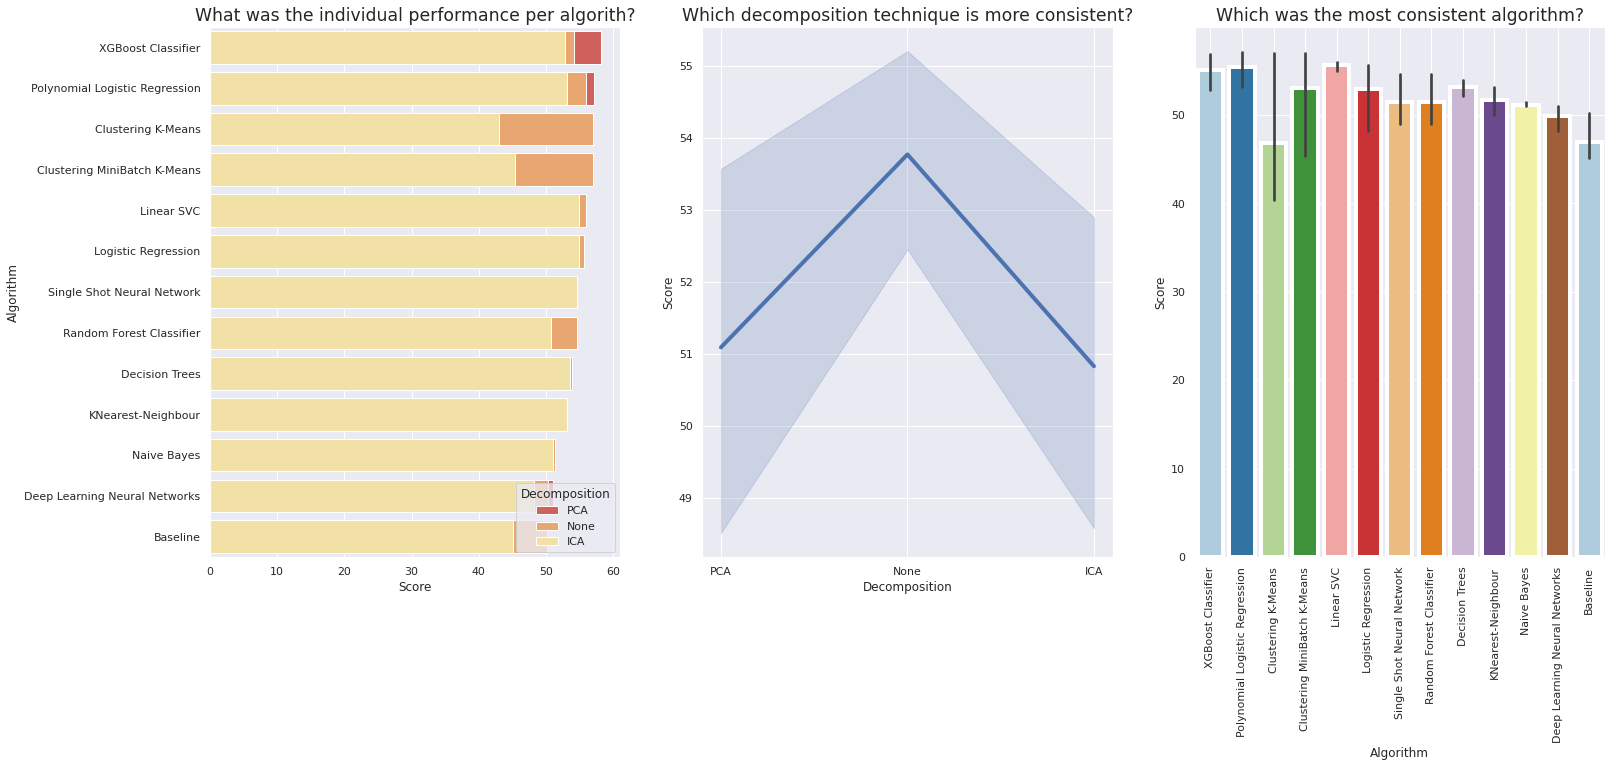

In [259]:
plt.suptitle(CLASSIFICATION_TITLE, fontsize='xx-large')

fig, axes = plt.subplots(1, 3, figsize=(25, len(scores) * .25))
g = sns.barplot(
  data=comparative_df,
  x='Score',
  y='Algorithm',
  ax=axes[0],
  hue='Decomposition',
  palette=sns.color_palette('Spectral'),
  dodge=False,
)
axes[0].set_title('What was the individual performance per algorith?', fontsize='x-large')
plt.grid()

sns.lineplot(
  data=comparative_df,
  x='Decomposition',
  y='Score',
  ax=axes[1],
  lw=4,
  palette=sns.color_palette('Paired', 3),
)

axes[1].set_title('Which decomposition technique is more consistent?', fontsize='x-large')

g = sns.barplot(
  data=comparative_df,
  x='Algorithm',
  y='Score',
  ax=axes[2],
  lw=4,
  palette=sns.color_palette('Paired'),
)
plt.xticks(rotation=90)

axes[2].set_title('Which was the most consistent algorithm?', fontsize='x-large')

plt.grid()
plt.show()

### Comparison per decomposiition technique

Uno un poco más general

<Figure size 1440x1080 with 0 Axes>

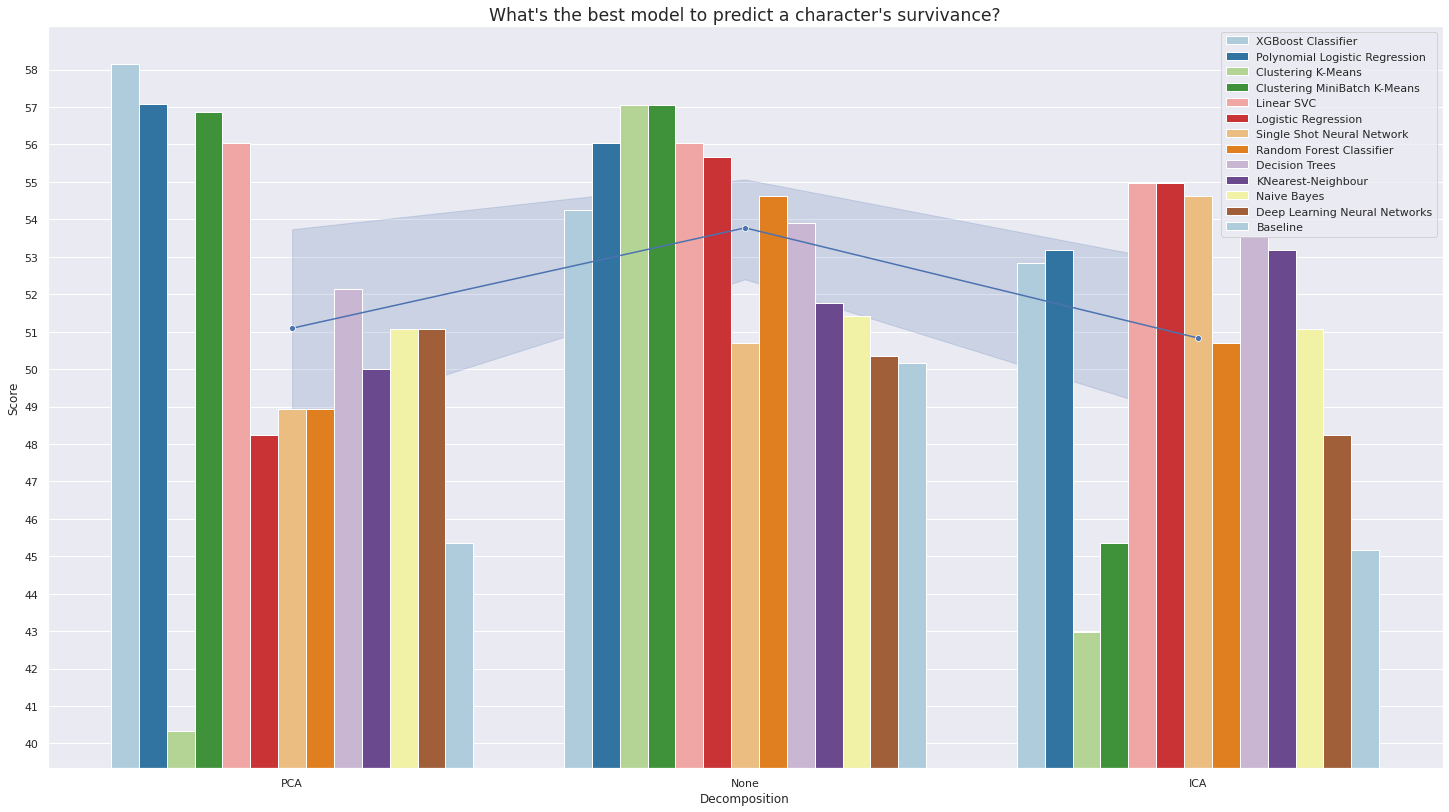

In [260]:
plt.suptitle(CLASSIFICATION_TITLE, fontsize='xx-large')

plt.figure(figsize = (25, len(scores) * .35))
comparative_plot = sns.barplot(
    data=comparative_df,
    y='Score',
    x='Decomposition',
    hue='Algorithm',
    ci=None,
    palette=sns.color_palette('Paired'),
    orient='v',
)
# comparative_plot.grid()
# comparative_plot.set_style('darkgrid')
# sns.set_style('darkgrid')
# plt.grid()

sns.lineplot(
  data=comparative_df,
  y='Score',
  x='Decomposition',
  marker='o',
)
comparative_plot.set_title("What's the best model to predict a character's survivance?", fontsize='x-large')

plt.yticks(range(
  int(score_min - 1),
  int(score_max + 1),
  ceil((score_max - score_min) / (len(comparative_df) * TICKS_RATE))
))

# Enable this to see it's full scope
# plt.ylim(0, 100)

# Enabling this, we can see the performance relative to the other algorithm's performance
plt.ylim(
  comparative_df['Score'].min() - 1,
  comparative_df['Score'].max() + 1,
)
sns.set_style('darkgrid')
# plt.grid()
plt.show()

### Supervised vs Unsupervised

This is a performance comparison only for this project, with my level of experience and knowledge about Data Science. An expert would say that Unsupervised models are usually far more powerful than supervised ones

<Figure size 1440x1080 with 0 Axes>

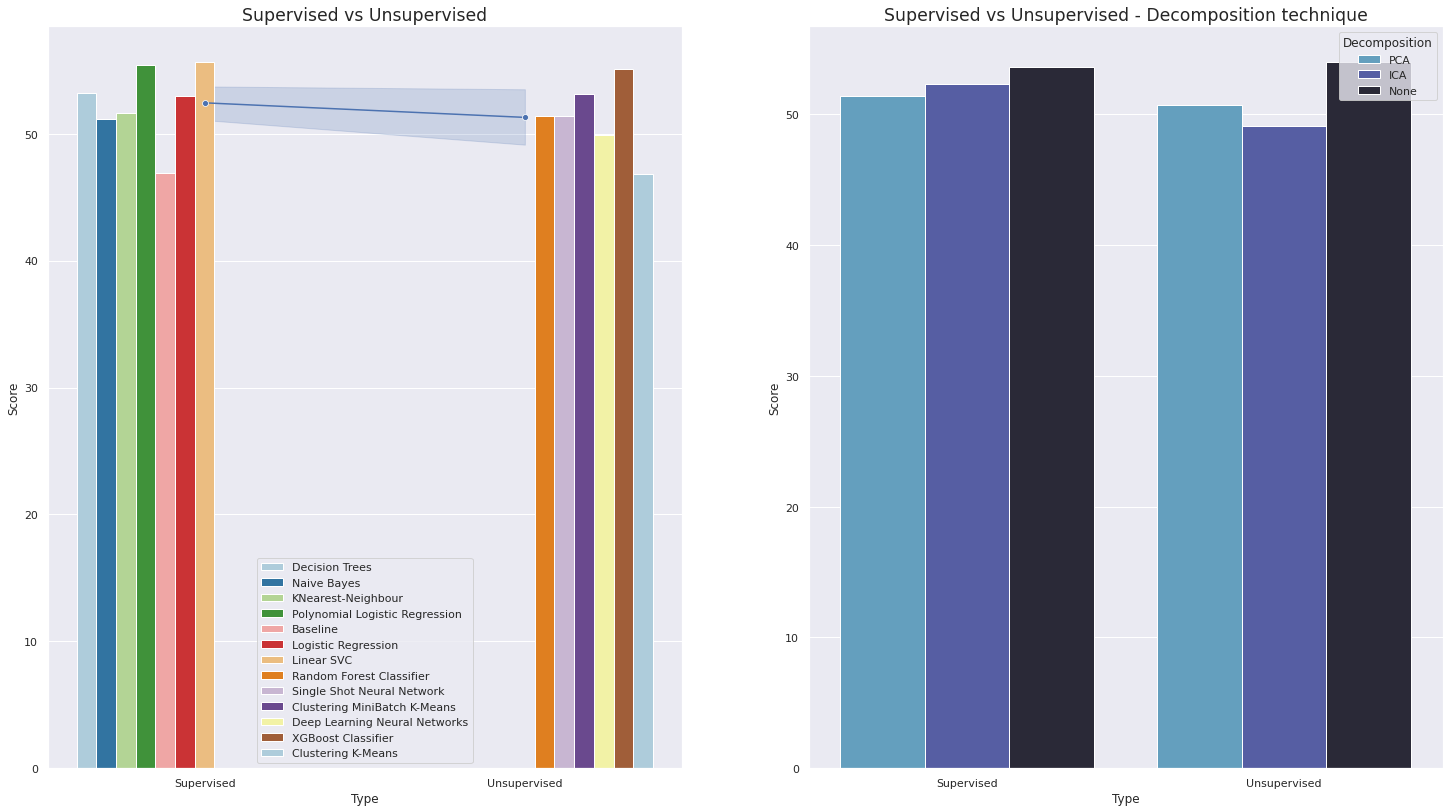

In [261]:
plt.suptitle(CLASSIFICATION_TITLE, fontsize='xx-large')

type_comparison_df = comparative_df.sort_values(
  ['Type',],
  ascending=[True,]
)

fig, axes = plt.subplots(1, 2, figsize = (25, len(scores) * .35))
comparative_plot = sns.barplot(
    data=type_comparison_df,
    y='Score',
    x='Type',
    hue='Algorithm',
    ci=None,
    palette=sns.color_palette('Paired'),
    orient='v',
    ax=axes[0],
)
sns.lineplot(
  data=type_comparison_df,
  y='Score',
  x='Type',
  marker='o',
  ax=axes[0]
)
comparative_plot.set_title('Supervised vs Unsupervised', fontsize='x-large')

comparative_plot = sns.barplot(
    data=type_comparison_df,
    y='Score',
    x='Type',
    hue='Decomposition',
    ci=None,
    orient='v',
    palette=sns.color_palette('icefire'),
    ax=axes[1],
)
comparative_plot.set_title('Supervised vs Unsupervised - Decomposition technique', fontsize='x-large')

sns.set_style('darkgrid')
# plt.grid()
plt.show()

### All at once

To finalize the plotting, let's just compare all of the algorithms with the technique used, all at once!

In [262]:
len(comparative_df)

39

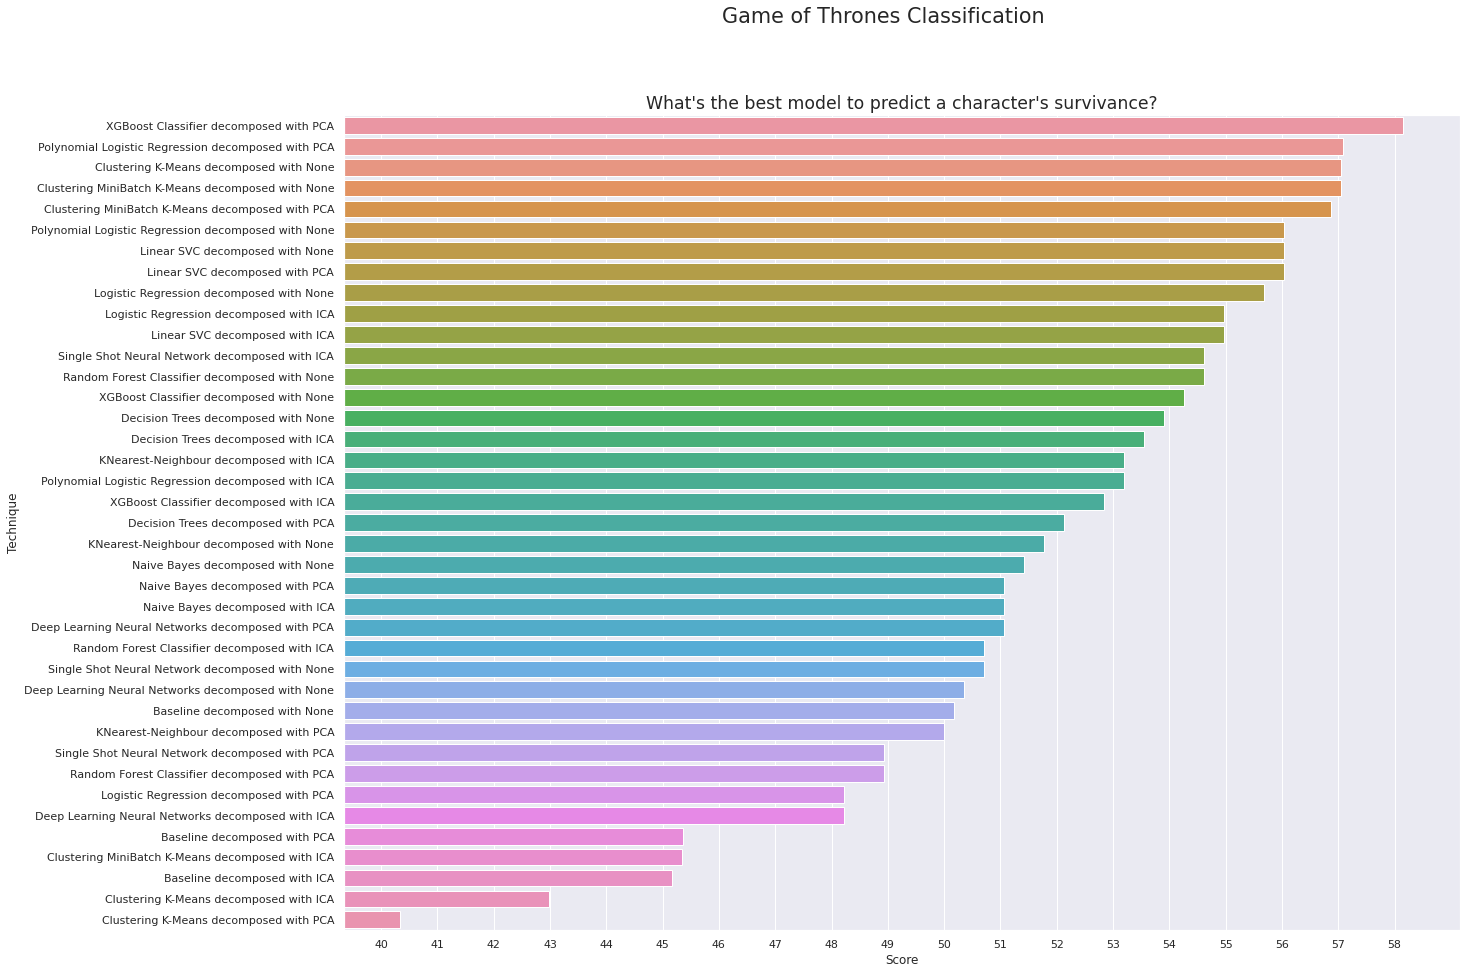

In [263]:
plt.suptitle(CLASSIFICATION_TITLE, fontsize='xx-large')
plt.title("What's the best model to predict a character's survivance?", fontsize='x-large')

_ = sns.barplot(
  data=comparative_df,
  x='Score',
  y='Technique',
)
sns.set_style('darkgrid')

# plt.grid()
plt.xticks(range(
  int(score_min - 1),
  int(score_max + 1),
  ceil((score_max- score_min) / (len(comparative_df) * TICKS_RATE))
))

# Enable this to see it's full scope
# plt.xlim(0, 100)

# Enabling this, we can see the performance relative to the other algorithm's performance
plt.xlim(
  score_min - 1,
  score_max + 1,
)
plt.show()

### Top three overall

In [264]:
comparative_df.sort_values(
  by='Score',
  ascending=False,
).head(3)

Algorithm      Score Decomposition          Type  \
31              XGBoost Classifier  58.156028           PCA  Unsupervised   
4   Polynomial Logistic Regression  57.092199           PCA    Supervised   
6               Clustering K-Means  57.055215          None  Unsupervised   

                                            Technique  
31             XGBoost Classifier decomposed with PCA  
4   Polynomial Logistic Regression decomposed with...  
6             Clustering K-Means decomposed with None

### Best model performance per technique

The best of each decomposition technique

In [265]:
comparative_df.sort_values(
  by='Score',
  ascending=False,
).groupby(
  by='Decomposition'
).head(1)

Algorithm      Score Decomposition          Type  \
31  XGBoost Classifier  58.156028           PCA  Unsupervised   
6   Clustering K-Means  57.055215          None  Unsupervised   
14          Linear SVC  54.964539           ICA    Supervised   

                                  Technique  
31   XGBoost Classifier decomposed with PCA  
6   Clustering K-Means decomposed with None  
14           Linear SVC decomposed with ICA

And the best three models per decomposition technique

In [266]:
comparative_df.sort_values(
  by=['Decomposition', 'Score'],
  ascending=[True, False],
).groupby(
  by='Decomposition'
).head(3)

Algorithm      Score Decomposition          Type  \
2              Logistic Regression  54.964539           ICA    Supervised   
14                      Linear SVC  54.964539           ICA    Supervised   
29      Single Shot Neural Network  54.609931           ICA  Unsupervised   
6               Clustering K-Means  57.055215          None  Unsupervised   
9     Clustering MiniBatch K-Means  57.055215          None  Unsupervised   
3   Polynomial Logistic Regression  56.028369          None    Supervised   
31              XGBoost Classifier  58.156028           PCA  Unsupervised   
4   Polynomial Logistic Regression  57.092199           PCA    Supervised   
10    Clustering MiniBatch K-Means  56.875000           PCA  Unsupervised   

                                            Technique  
2             Logistic Regression decomposed with ICA  
14                     Linear SVC decomposed with ICA  
29     Single Shot Neural Network decomposed with ICA  
6             Clustering K-Means decomposed with None  
9   Clustering MiniBatch K-Means decomposed with None  
3   Polynomial Logistic Regression decomposed with...  
31             XGBoost Classifier decomposed with PCA  
4   Polynomial Logistic Regression decomposed with...  
10   Clustering MiniBatch K-Means decomposed with PCA

### The poorest performance

Some of the algorithms are not tuned for it's optimal performance, nor are they properly configured due of my lack of experience

In [267]:
comparative_df.sort_values(
  by='Score',
  ascending=True,
).head(5)

Algorithm      Score Decomposition          Type  \
7             Clustering K-Means  40.336134           PCA  Unsupervised   
8             Clustering K-Means  42.975207           ICA  Unsupervised   
35                      Baseline  45.161290           ICA    Supervised   
11  Clustering MiniBatch K-Means  45.344130           ICA  Unsupervised   
34                      Baseline  45.353160           PCA    Supervised   

                                           Technique  
7             Clustering K-Means decomposed with PCA  
8             Clustering K-Means decomposed with ICA  
35                      Baseline decomposed with ICA  
11  Clustering MiniBatch K-Means decomposed with ICA  
34                      Baseline decomposed with PCA

Per decomposition technique

In [268]:
comparative_df.sort_values(
  by=['Decomposition', 'Score'],
  ascending=[True, True],
).groupby(
  by='Decomposition'
).head(1)

Algorithm      Score Decomposition          Type  \
8   Clustering K-Means  42.975207           ICA  Unsupervised   
33            Baseline  50.171821          None    Supervised   
7   Clustering K-Means  40.336134           PCA  Unsupervised   

                                 Technique  
8   Clustering K-Means decomposed with ICA  
33           Baseline decomposed with None  
7   Clustering K-Means decomposed with PCA

Three worst per decomposition technique

In [269]:
comparative_df.sort_values(
  by=['Decomposition', 'Score'],
  ascending=[True, True],
).groupby(
  by='Decomposition'
).head(3)

Algorithm      Score Decomposition          Type  \
8              Clustering K-Means  42.975207           ICA  Unsupervised   
35                       Baseline  45.161290           ICA    Supervised   
11   Clustering MiniBatch K-Means  45.344130           ICA  Unsupervised   
33                       Baseline  50.171821          None    Supervised   
21  Deep Learning Neural Networks  50.354612          None  Unsupervised   
27     Single Shot Neural Network  50.709218          None  Unsupervised   
7              Clustering K-Means  40.336134           PCA  Unsupervised   
34                       Baseline  45.353160           PCA    Supervised   
1             Logistic Regression  48.226950           PCA    Supervised   

                                            Technique  
8              Clustering K-Means decomposed with ICA  
35                       Baseline decomposed with ICA  
11   Clustering MiniBatch K-Means decomposed with ICA  
33                      Baseline decomposed with None  
21  Deep Learning Neural Networks decomposed with ...  
27    Single Shot Neural Network decomposed with None  
7              Clustering K-Means decomposed with PCA  
34                       Baseline decomposed with PCA  
1             Logistic Regression decomposed with PCA

### Comparison table

For a more detailed view of the algorithms performance, we can simply display the full DataFrame

In [270]:
comparative_df.sort_values(
  by='Score',
  ascending=False,
).head(len(comparative_df))

Algorithm      Score Decomposition          Type  \
31              XGBoost Classifier  58.156028           PCA  Unsupervised   
4   Polynomial Logistic Regression  57.092199           PCA    Supervised   
6               Clustering K-Means  57.055215          None  Unsupervised   
9     Clustering MiniBatch K-Means  57.055215          None  Unsupervised   
10    Clustering MiniBatch K-Means  56.875000           PCA  Unsupervised   
3   Polynomial Logistic Regression  56.028369          None    Supervised   
12                      Linear SVC  56.028369          None    Supervised   
13                      Linear SVC  56.028369           PCA    Supervised   
0              Logistic Regression  55.673759          None    Supervised   
14                      Linear SVC  54.964539           ICA    Supervised   
2              Logistic Regression  54.964539           ICA    Supervised   
29      Single Shot Neural Network  54.609931           ICA  Unsupervised   
24        Random Forest Classifier  54.609929          None  Unsupervised   
30              XGBoost Classifier  54.255319          None  Unsupervised   
18                  Decision Trees  53.900709          None    Supervised   
20                  Decision Trees  53.546099           ICA    Supervised   
38              KNearest-Neighbour  53.191489           ICA    Supervised   
5   Polynomial Logistic Regression  53.191489           ICA    Supervised   
32              XGBoost Classifier  52.836879           ICA  Unsupervised   
19                  Decision Trees  52.127660           PCA    Supervised   
36              KNearest-Neighbour  51.773050          None    Supervised   
15                     Naive Bayes  51.418440          None    Supervised   
16                     Naive Bayes  51.063830           PCA    Supervised   
17                     Naive Bayes  51.063830           ICA    Supervised   
22   Deep Learning Neural Networks  51.063830           PCA  Unsupervised   
26        Random Forest Classifier  50.709220           ICA  Unsupervised   
27      Single Shot Neural Network  50.709218          None  Unsupervised   
21   Deep Learning Neural Networks  50.354612          None  Unsupervised   
33                        Baseline  50.171821          None    Supervised   
37              KNearest-Neighbour  50.000000           PCA    Supervised   
28      Single Shot Neural Network  48.936170           PCA  Unsupervised   
25        Random Forest Classifier  48.936170           PCA  Unsupervised   
1              Logistic Regression  48.226950           PCA    Supervised   
23   Deep Learning Neural Networks  48.226950           ICA  Unsupervised   
34                        Baseline  45.353160           PCA    Supervised   
11    Clustering MiniBatch K-Means  45.344130           ICA  Unsupervised   
35                        Baseline  45.161290           ICA    Supervised   
8               Clustering K-Means  42.975207           ICA  Unsupervised   
7               Clustering K-Means  40.336134           PCA  Unsupervised   

                                            Technique  
31             XGBoost Classifier decomposed with PCA  
4   Polynomial Logistic Regression decomposed with...  
6             Clustering K-Means decomposed with None  
9   Clustering MiniBatch K-Means decomposed with None  
10   Clustering MiniBatch K-Means decomposed with PCA  
3   Polynomial Logistic Regression decomposed with...  
12                    Linear SVC decomposed with None  
13                     Linear SVC decomposed with PCA  
0            Logistic Regression decomposed with None  
14                     Linear SVC decomposed with ICA  
2             Logistic Regression decomposed with ICA  
29     Single Shot Neural Network decomposed with ICA  
24      Random Forest Classifier decomposed with None  
30            XGBoost Classifier decomposed with None  
18                Decision Trees decomposed with None  
20                 Decision Trees decomposed wit

## Conclusions

As to conclude with this notebook, let's do some recapitulation of some of the key concepts we've seen and some resolutions

### Metrics

`f1_score`, used for classification, it's true that it gives a score, but as we've seen by having an unbalanced test set, it meant nothing, as a model could score the highest `f1_score` and not predict a single deceased character, in fact, if we were to return always 1 (the value of the alive), we'd have ourselves a model.

So having a `confusion matrix` to check, as well as a `classification report`, it's been a must. It lets you visualize how truly well is your model performing.

### Data imbalancement

There are two main reasons why I kept the distribution "unbalanced", i.e. missing values at `0`:

- Gives a better result without adding bias as such, I am not talking about the score anymore, the confusion matrix is more accurate, much more so when the missing values are at 0.
- It makes, in my head at least, mathematical sense, that when computing the values and training the models, if a value does not exist, it is represented as the numerical value that does not represent anything. It makes that column of that row not influence, too much, in the rest of the calculations.
- And, that's how the data is, it's not bias to say that there are more alive characters than deceased, if that's how the series turns out, that's how it is, and how the model should learn

Another thing to take into account is that, the score itself, is not the best metric, the confusion matrix is, `f1_score` highly penalyzes per total amount of the label, which is fine. But the highest score doesn't necessarly mean the most acurate, or the one with the least mistakes.

### Undersampling and Oversampling

It's preferred to undersample an umbalanced dataset as to not add bias nor to create examples that are fake, while undersampling leaves a smaller dataset, it's a cleaner and one with more quality.

So, for classification problems, whenever is possible, making sure the data is distributed is a huge step

### Supervised and Unsupervised

Surprisingly, supervised performed better than unsupervised. Not to say unsupervised did not perform well, but there's a clear advantage between the two of them.

We could conclude that, as for this data set, a small dataset is not good enough for unsupervised models to really shine through, it was whenever we had a larger training dataset that they really came through

### An adequate model

Cheating a little bit, but it can give a huge insight as to what's most important for the model to actually predict the survivance of a character

In [271]:
# Copy the DataFrame
df_conclusions = df_character_predictions.copy()

# Drop values
df_conclusions = df_conclusions.drop(['S.No', 'actual', 'pred', 'alive', 'plod'], axis=1)
# df_conclusions = df_conclusions.drop(['mother', 'father', 'heir', 'spouse', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse'], axis=1)
df_conclusions = df_conclusions.drop(['dateOfBirth', 'DateoFdeath', 'age'], axis=1)

# Transform them
df_conclusions.loc[:, "culture"] = [get_cult(x) for x in df_conclusions.culture.fillna("")]
df_conclusions = df_conclusions.replace('', np.nan)
df_conclusions.loc[:, "culture"] = [get_cult(x) for x in df_conclusions.culture.fillna('')]
adequate_model_cols_to_factorize = ['mother', 'father', 'heir', 'spouse', 'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse', 'house', 'culture', 'title']
for column in adequate_model_cols_to_factorize:
  df_conclusions.loc[:, column] = pd.factorize(df_conclusions[column])[0]

# Prepare the train and test sets
X_conclusion = df_conclusions[ [ col for col in df_conclusions.select_dtypes(include=np.number).columns if col != TARGET_VARIABLE ] ]
y_conclusion = df_conclusions[TARGET_VARIABLE]
X_conclusion_train, X_conclusion_test, y_conclusion_train, y_conclusion_test = train_test_split(X_conclusion, y_conclusion, test_size=.2)

# Train and evaluate the model
conclusive_model = RandomForestClassifier( n_estimators=400, n_jobs=-1, )
conclusive_model.fit(X_conclusion_train, y_conclusion_train)
display_score(conclusive_model.score(X_conclusion_test, y_conclusion_test))

score 79.74%


Building the feature importance DataFrame

In [272]:
df_conclusive_features_importance = pd.DataFrame(
  zip(
    conclusive_model.feature_names_in_,
    conclusive_model.feature_importances_,
  ),
  columns=[
    'feature_name',
    'importance',
  ]
)

Plotting the feature importance DataFrame

In [273]:
plt.figure(figsize=(
  20,
  len(df_conclusive_features_importance.columns) * 4
))
_ = sns.barplot(
  data=df_conclusive_features_importance.sort_values(
    'importance',
    ascending=False,
  ),
  x='importance',
  y='feature_name',
)